In [1]:
cd ..

C:\Users\giaco\thesis-sbp-abm\municipality_level_analysis\municipalities_abm


In [2]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import geopandas as gpd
import os
import csv

from municipalities_abm.model import SBPAdoption

from municipalities_abm.custom_transformers import (
    TransformCensusFeatures,
    TransformClimateFeatures,
    TransformSoilFeatures,
    )

In [3]:
%matplotlib inline

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [4]:
# Line necessary to import agents in model, since the cwd of the notebook server is always the base path where you started the 
# server 
import sys
sys.path.append(".\municipalities_abm")

In [5]:
# How to display floats
pd.options.display.float_format = '{:.6f}'.format
#np.set_printoptions(precision=6)
np.set_printoptions(formatter={'float': lambda x: "{0:0.6f}".format(x)})

In [6]:
# Where to save the figures
PROJECT_ROOT_DIR = "model_validation"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=False, fig_extension="jpeg", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Real data loading

In [59]:
path_to_adoption_port_real = "./model_validation/data/SBP yearly adoption - Portugal.csv"
yearly_adoption_portugal_real = pd.read_csv(path_to_adoption_port_real, index_col=0)
yearly_adoption_portugal_real.drop(1995, inplace=True)

In [60]:
path_to_adoption_munic_real = "./model_validation/data/SBP yearly adoption - Municipalities.csv"
munic_yearly_adoption_real = pd.read_csv(path_to_adoption_munic_real, index_col=['Municipality', 'Year'])

# Model runs and data collection

In [9]:
n_runs = 100

In [10]:
start_year = 1996 # Included in the simulation
stop_year = 2021 # Not included in the simulation

### Set dataframe and function to collect municipalities yearly adoption

In [11]:
# Set dataframe to collect municipalities yearly adoption
municipalities_data = gpd.read_file("./data/municipalities_shp/shapefile_for_munic_abm.shp")
municipalities_data.rename(columns={'Municipali': 'Municipality'},
                           inplace=True)
municipalities = municipalities_data['Municipality'].values.tolist()

years = np.arange(start_year, stop_year)
munic_yearly_adoption = pd.MultiIndex.from_product([municipalities, years])
munic_yearly_adoption = munic_yearly_adoption.to_frame()
munic_yearly_adoption.drop(munic_yearly_adoption.columns, axis=1, inplace=True)
munic_yearly_adoption.index.rename(['Municipality', 'Year'], inplace=True)

In [12]:
def collect_agent_level_yearly_adoption(abm_model, n_run, df_adoption):
    """
    Function to collect data at the individual agent level
    
    Returns
    -------
    municipalities_adoption : pd DataFrame
        Multiindex DataFrame reporting for each muninicipality and for each year the ratio of SBP adopted
    """
    municipality_agents = abm_model.schedule.agents
    col_name = 'Run ' + str(n_run+1)
    df_adoption.loc[:, col_name] = None
    
    # Create a dictionary mapping to each municipality name the Series of its adoption in each year
    yearly_adoptions = [munic.yearly_adoption for munic in municipality_agents]
    map_dict = dict(zip(municipalities, yearly_adoptions))
    for k, v in map_dict.items():
        map_dict[k] = pd.Series(v)
        map_dict[k].name = col_name # Necessary to use .udpdate() method

    # For each municipality, updates the values of adoption    
    for munic in municipalities:
        df = df_adoption.loc[munic]
        df.update(map_dict[munic])
        df_adoption.loc[munic] = df.values

### Set dataframes to collect yearly adoption and cumulative yearly adoption in Portugal

In [13]:
# Set dataframes to collect yearly adoption and cumulative yearly adoption in Portugal
yearly_adoption_portugal_pred = pd.DataFrame(index=years)
yearly_adoption_portugal_pred.index.rename('Year', inplace=True)

cumulative_adoption_portugal_pred = pd.DataFrame(index=years)
cumulative_adoption_portugal_pred.index.rename('Year', inplace=True)

In [14]:
def collect_data_run(model, n_run):
    # Individual adoption
    collect_agent_level_yearly_adoption(model, n_run, munic_yearly_adoption)
    
    # Aggregate adoption
    aggr_adoption_out = model.datacollector.get_model_vars_dataframe()
    aggr_adoption_out.set_index('Year', inplace=True)
    col_name = 'Run ' + str(n_run+1)
    yearly_adoption_portugal_pred[col_name] = aggr_adoption_out['Area sown in the last year [ha/y]']
    cumulative_adoption_portugal_pred[col_name] = aggr_adoption_out['Total area of SBP sown [ha]']

In [15]:
sbp_payments_path = "./data/sbp_payments_all0.xlsx"

In [16]:
%%time
for i in range(n_runs):
    #model = SBPAdoption(initial_year=start_year, seed=i, sbp_payments_path=sbp_payments_path)
    model = SBPAdoption(initial_year=start_year, seed=i, sbp_payments_path=sbp_payments_path)
    for y in range(start_year, stop_year):
        model.step()
        print("Run n° " + str(i+1) + ": year " + str(y) + " step completed.")
    collect_data_run(model, i)

Negative adoption predicted of: [-0.000302]
Negative adoption predicted of: [-0.000025]
Negative adoption predicted of: [-0.000035]
Negative adoption predicted of: [-0.000002]
Negative adoption predicted of: [-0.000585]
Negative adoption predicted of: [-0.000230]
Negative adoption predicted of: [-0.000019]
Negative adoption predicted of: [-0.000060]
Negative adoption predicted of: [-0.000020]
Negative adoption predicted of: [-0.000200]
Negative adoption predicted of: [-0.000559]
Run n° 1: year 1996 step completed.
Negative adoption predicted of: [-0.000258]
Negative adoption predicted of: [-0.000228]
Negative adoption predicted of: [-0.000446]
Negative adoption predicted of: [-0.000960]
Negative adoption predicted of: [-0.000033]
Negative adoption predicted of: [-0.000241]
Negative adoption predicted of: [-0.000747]
Negative adoption predicted of: [-0.000089]
Negative adoption predicted of: [-0.000647]
Negative adoption predicted of: [-0.000508]
Negative adoption predicted of: [-0.0000

Negative adoption predicted of: [-0.000888]
Run n° 1: year 2012 step completed.
Negative adoption predicted of: [-0.001131]
Negative adoption predicted of: [-0.000252]
Negative adoption predicted of: [-0.003915]
Negative adoption predicted of: [-0.002601]
Negative adoption predicted of: [-0.000513]
Negative adoption predicted of: [-0.001480]
Negative adoption predicted of: [-0.000970]
Negative adoption predicted of: [-0.000250]
Negative adoption predicted of: [-0.000326]
Negative adoption predicted of: [-0.001206]
Run n° 1: year 2013 step completed.
Negative adoption predicted of: [-0.003300]
Negative adoption predicted of: [-0.001249]
Negative adoption predicted of: [-0.002185]
Negative adoption predicted of: [-0.000021]
Negative adoption predicted of: [-0.000643]
Run n° 1: year 2014 step completed.
Negative adoption predicted of: [-0.002254]
Run n° 1: year 2015 step completed.
Run n° 1: year 2016 step completed.
Negative adoption predicted of: [-0.000695]
Run n° 1: year 2017 step com

Run n° 2: year 2009 step completed.
Negative adoption predicted of: [-0.001075]
Negative adoption predicted of: [-0.003096]
Negative adoption predicted of: [-0.000306]
Negative adoption predicted of: [-0.002020]
Negative adoption predicted of: [-0.000636]
Negative adoption predicted of: [-0.001239]
Negative adoption predicted of: [-0.000018]
Negative adoption predicted of: [-0.000219]
Run n° 2: year 2010 step completed.
Negative adoption predicted of: [-0.000959]
Negative adoption predicted of: [-0.000089]
Negative adoption predicted of: [-0.000872]
Negative adoption predicted of: [-0.000804]
Negative adoption predicted of: [-0.001191]
Negative adoption predicted of: [-0.000523]
Negative adoption predicted of: [-0.000047]
Run n° 2: year 2011 step completed.
Negative adoption predicted of: [-0.000329]
Negative adoption predicted of: [-0.003997]
Negative adoption predicted of: [-0.000791]
Negative adoption predicted of: [-0.001018]
Negative adoption predicted of: [-0.000723]
Negative ado

C:\Users\giaco\anaconda3\envs\mesa_geo_ml\lib\site-packages\pandas\core\frame.py:6386: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = expressions.where(mask, this, that)


Negative adoption predicted of: [-0.000025]
Negative adoption predicted of: [-0.000035]
Negative adoption predicted of: [-0.000002]
Negative adoption predicted of: [-0.000167]
Negative adoption predicted of: [-0.000230]
Negative adoption predicted of: [-0.000031]
Negative adoption predicted of: [-0.000060]
Negative adoption predicted of: [-0.000020]
Negative adoption predicted of: [-0.000200]
Negative adoption predicted of: [-0.000126]
Negative adoption predicted of: [-0.000255]
Negative adoption predicted of: [-0.000293]
Run n° 3: year 1996 step completed.
Negative adoption predicted of: [-0.000517]
Negative adoption predicted of: [-0.000062]
Negative adoption predicted of: [-0.000397]
Negative adoption predicted of: [-0.000686]
Negative adoption predicted of: [-0.000564]
Negative adoption predicted of: [-0.000468]
Negative adoption predicted of: [-0.000120]
Negative adoption predicted of: [-0.000493]
Negative adoption predicted of: [-0.000672]
Negative adoption predicted of: [-0.0005

Run n° 3: year 2009 step completed.
Negative adoption predicted of: [-0.001307]
Negative adoption predicted of: [-0.000036]
Negative adoption predicted of: [-0.003249]
Negative adoption predicted of: [-0.000117]
Negative adoption predicted of: [-0.000575]
Negative adoption predicted of: [-0.001517]
Negative adoption predicted of: [-0.001069]
Negative adoption predicted of: [-0.000846]
Run n° 3: year 2010 step completed.
Negative adoption predicted of: [-0.000685]
Negative adoption predicted of: [-0.002752]
Negative adoption predicted of: [-0.001600]
Negative adoption predicted of: [-0.000822]
Negative adoption predicted of: [-0.000314]
Run n° 3: year 2011 step completed.
Negative adoption predicted of: [-0.001646]
Negative adoption predicted of: [-0.000507]
Negative adoption predicted of: [-0.004085]
Negative adoption predicted of: [-0.001261]
Negative adoption predicted of: [-0.001341]
Negative adoption predicted of: [-0.000687]
Negative adoption predicted of: [-0.000442]
Negative ado

C:\Users\giaco\anaconda3\envs\mesa_geo_ml\lib\site-packages\pandas\core\frame.py:6386: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = expressions.where(mask, this, that)


Negative adoption predicted of: [-0.000302]
Negative adoption predicted of: [-0.000025]
Negative adoption predicted of: [-0.000035]
Negative adoption predicted of: [-0.000002]
Negative adoption predicted of: [-0.000019]
Negative adoption predicted of: [-0.000031]
Negative adoption predicted of: [-0.000060]
Negative adoption predicted of: [-0.000020]
Negative adoption predicted of: [-0.000200]
Negative adoption predicted of: [-0.000126]
Negative adoption predicted of: [-0.000239]
Negative adoption predicted of: [-0.000255]
Negative adoption predicted of: [-0.000143]
Negative adoption predicted of: [-0.000293]
Run n° 4: year 1996 step completed.
Negative adoption predicted of: [-0.000343]
Negative adoption predicted of: [-0.000306]
Negative adoption predicted of: [-0.000419]
Negative adoption predicted of: [-0.000946]
Negative adoption predicted of: [-0.000228]
Negative adoption predicted of: [-0.000050]
Negative adoption predicted of: [-0.000610]
Negative adoption predicted of: [-0.0000

Run n° 4: year 2009 step completed.
Negative adoption predicted of: [-0.000795]
Negative adoption predicted of: [-0.000928]
Run n° 4: year 2010 step completed.
Negative adoption predicted of: [-0.002924]
Negative adoption predicted of: [-0.000147]
Negative adoption predicted of: [-0.001241]
Run n° 4: year 2011 step completed.
Negative adoption predicted of: [-0.000561]
Negative adoption predicted of: [-0.002784]
Negative adoption predicted of: [-0.000745]
Negative adoption predicted of: [-0.000445]
Run n° 4: year 2012 step completed.
Negative adoption predicted of: [-0.003546]
Negative adoption predicted of: [-0.002541]
Negative adoption predicted of: [-0.000377]
Negative adoption predicted of: [-0.000500]
Negative adoption predicted of: [-0.000710]
Run n° 4: year 2013 step completed.
Negative adoption predicted of: [-0.000161]
Negative adoption predicted of: [-0.002119]
Negative adoption predicted of: [-0.001835]
Run n° 4: year 2014 step completed.
Negative adoption predicted of: [-0.

C:\Users\giaco\anaconda3\envs\mesa_geo_ml\lib\site-packages\pandas\core\frame.py:6386: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = expressions.where(mask, this, that)


Negative adoption predicted of: [-0.000302]
Negative adoption predicted of: [-0.000025]
Negative adoption predicted of: [-0.000035]
Negative adoption predicted of: [-0.000002]
Negative adoption predicted of: [-0.000585]
Negative adoption predicted of: [-0.000167]
Negative adoption predicted of: [-0.000230]
Negative adoption predicted of: [-0.000019]
Negative adoption predicted of: [-0.000031]
Negative adoption predicted of: [-0.000060]
Negative adoption predicted of: [-0.000020]
Negative adoption predicted of: [-0.000126]
Negative adoption predicted of: [-0.000239]
Negative adoption predicted of: [-0.000143]
Run n° 5: year 1996 step completed.
Negative adoption predicted of: [-0.000310]
Negative adoption predicted of: [-0.000237]
Negative adoption predicted of: [-0.000117]
Negative adoption predicted of: [-0.000752]
Negative adoption predicted of: [-0.000662]
Negative adoption predicted of: [-0.000512]
Negative adoption predicted of: [-0.000287]
Negative adoption predicted of: [-0.0005

Run n° 5: year 2012 step completed.
Negative adoption predicted of: [-0.001067]
Negative adoption predicted of: [-0.000294]
Negative adoption predicted of: [-0.003919]
Negative adoption predicted of: [-0.001781]
Negative adoption predicted of: [-0.000749]
Negative adoption predicted of: [-0.000689]
Negative adoption predicted of: [-0.000157]
Negative adoption predicted of: [-0.000179]
Run n° 5: year 2013 step completed.
Negative adoption predicted of: [-0.003274]
Negative adoption predicted of: [-0.000080]
Run n° 5: year 2014 step completed.
Negative adoption predicted of: [-0.000035]
Negative adoption predicted of: [-0.002171]
Negative adoption predicted of: [-0.000614]
Negative adoption predicted of: [-0.000006]
Run n° 5: year 2015 step completed.
Negative adoption predicted of: [-0.000845]
Run n° 5: year 2016 step completed.
Negative adoption predicted of: [-0.000383]
Run n° 5: year 2017 step completed.
Run n° 5: year 2018 step completed.
Run n° 5: year 2019 step completed.
Run n° 5

C:\Users\giaco\anaconda3\envs\mesa_geo_ml\lib\site-packages\pandas\core\frame.py:6386: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = expressions.where(mask, this, that)


Negative adoption predicted of: [-0.000302]
Negative adoption predicted of: [-0.000025]
Negative adoption predicted of: [-0.000035]
Negative adoption predicted of: [-0.000585]
Negative adoption predicted of: [-0.000230]
Negative adoption predicted of: [-0.000019]
Negative adoption predicted of: [-0.000031]
Negative adoption predicted of: [-0.000060]
Negative adoption predicted of: [-0.000200]
Negative adoption predicted of: [-0.000126]
Negative adoption predicted of: [-0.000255]
Negative adoption predicted of: [-0.000143]
Negative adoption predicted of: [-0.000293]
Run n° 6: year 1996 step completed.
Negative adoption predicted of: [-0.000295]
Negative adoption predicted of: [-0.000256]
Negative adoption predicted of: [-0.000956]
Negative adoption predicted of: [-0.000671]
Negative adoption predicted of: [-0.000244]
Negative adoption predicted of: [-0.000733]
Negative adoption predicted of: [-0.000081]
Negative adoption predicted of: [-0.000001]
Negative adoption predicted of: [-0.0004

Negative adoption predicted of: [-0.001002]
Negative adoption predicted of: [-0.000340]
Run n° 6: year 2011 step completed.
Negative adoption predicted of: [-0.003329]
Negative adoption predicted of: [-0.001024]
Negative adoption predicted of: [-0.000553]
Negative adoption predicted of: [-0.000399]
Run n° 6: year 2012 step completed.
Negative adoption predicted of: [-0.001108]
Negative adoption predicted of: [-0.000285]
Negative adoption predicted of: [-0.003877]
Negative adoption predicted of: [-0.001896]
Negative adoption predicted of: [-0.000702]
Negative adoption predicted of: [-0.000821]
Run n° 6: year 2013 step completed.
Negative adoption predicted of: [-0.003231]
Negative adoption predicted of: [-0.000038]
Run n° 6: year 2014 step completed.
Negative adoption predicted of: [-0.000139]
Negative adoption predicted of: [-0.002733]
Negative adoption predicted of: [-0.001597]
Negative adoption predicted of: [-0.000797]
Negative adoption predicted of: [-0.000053]
Negative adoption pr

C:\Users\giaco\anaconda3\envs\mesa_geo_ml\lib\site-packages\pandas\core\frame.py:6386: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = expressions.where(mask, this, that)


Negative adoption predicted of: [-0.000302]
Negative adoption predicted of: [-0.000025]
Negative adoption predicted of: [-0.000035]
Negative adoption predicted of: [-0.000002]
Negative adoption predicted of: [-0.000167]
Negative adoption predicted of: [-0.000230]
Negative adoption predicted of: [-0.000031]
Negative adoption predicted of: [-0.000060]
Negative adoption predicted of: [-0.000020]
Negative adoption predicted of: [-0.000200]
Negative adoption predicted of: [-0.000126]
Negative adoption predicted of: [-0.000239]
Negative adoption predicted of: [-0.000255]
Negative adoption predicted of: [-0.000143]
Run n° 7: year 1996 step completed.
Negative adoption predicted of: [-0.000381]
Negative adoption predicted of: [-0.000302]
Negative adoption predicted of: [-0.000445]
Negative adoption predicted of: [-0.000984]
Negative adoption predicted of: [-0.000651]
Negative adoption predicted of: [-0.000016]
Negative adoption predicted of: [-0.000247]
Negative adoption predicted of: [-0.0007

Negative adoption predicted of: [-0.000726]
Negative adoption predicted of: [-0.000126]
Negative adoption predicted of: [-0.000558]
Negative adoption predicted of: [-0.001289]
Run n° 7: year 2013 step completed.
Negative adoption predicted of: [-0.000856]
Negative adoption predicted of: [-0.000201]
Negative adoption predicted of: [-0.003363]
Negative adoption predicted of: [-0.001269]
Negative adoption predicted of: [-0.000170]
Negative adoption predicted of: [-0.000500]
Negative adoption predicted of: [-0.000918]
Run n° 7: year 2014 step completed.
Negative adoption predicted of: [-0.001851]
Run n° 7: year 2015 step completed.
Negative adoption predicted of: [-0.000004]
Negative adoption predicted of: [-0.001204]
Run n° 7: year 2016 step completed.
Run n° 7: year 2017 step completed.
Negative adoption predicted of: [-0.000210]
Negative adoption predicted of: [-0.000419]
Run n° 7: year 2018 step completed.
Run n° 7: year 2019 step completed.
Run n° 7: year 2020 step completed.


C:\Users\giaco\anaconda3\envs\mesa_geo_ml\lib\site-packages\pandas\core\frame.py:6386: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = expressions.where(mask, this, that)


Negative adoption predicted of: [-0.000302]
Negative adoption predicted of: [-0.000025]
Negative adoption predicted of: [-0.000035]
Negative adoption predicted of: [-0.000167]
Negative adoption predicted of: [-0.000230]
Negative adoption predicted of: [-0.000019]
Negative adoption predicted of: [-0.000031]
Negative adoption predicted of: [-0.000060]
Negative adoption predicted of: [-0.000020]
Negative adoption predicted of: [-0.000126]
Negative adoption predicted of: [-0.000239]
Negative adoption predicted of: [-0.000293]
Run n° 8: year 1996 step completed.
Negative adoption predicted of: [-0.000386]
Negative adoption predicted of: [-0.000307]
Negative adoption predicted of: [-0.000650]
Negative adoption predicted of: [-0.000016]
Negative adoption predicted of: [-0.000251]
Negative adoption predicted of: [-0.000718]
Negative adoption predicted of: [-0.000083]
Negative adoption predicted of: [-0.000630]
Negative adoption predicted of: [-0.000547]
Negative adoption predicted of: [-0.0004

Negative adoption predicted of: [-0.000421]
Negative adoption predicted of: [-0.000909]
Run n° 8: year 2012 step completed.
Negative adoption predicted of: [-0.000906]
Negative adoption predicted of: [-0.000407]
Negative adoption predicted of: [-0.004037]
Negative adoption predicted of: [-0.001421]
Negative adoption predicted of: [-0.000912]
Negative adoption predicted of: [-0.001155]
Negative adoption predicted of: [-0.000290]
Negative adoption predicted of: [-0.000438]
Negative adoption predicted of: [-0.000241]
Negative adoption predicted of: [-0.000727]
Negative adoption predicted of: [-0.001396]
Run n° 8: year 2013 step completed.
Negative adoption predicted of: [-0.000579]
Negative adoption predicted of: [-0.000128]
Negative adoption predicted of: [-0.001112]
Negative adoption predicted of: [-0.000337]
Negative adoption predicted of: [-0.000032]
Negative adoption predicted of: [-0.000951]
Run n° 8: year 2014 step completed.
Negative adoption predicted of: [-0.002512]
Negative ado

C:\Users\giaco\anaconda3\envs\mesa_geo_ml\lib\site-packages\pandas\core\frame.py:6386: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = expressions.where(mask, this, that)


Negative adoption predicted of: [-0.000025]
Negative adoption predicted of: [-0.000035]
Negative adoption predicted of: [-0.000002]
Negative adoption predicted of: [-0.000585]
Negative adoption predicted of: [-0.000230]
Negative adoption predicted of: [-0.000031]
Negative adoption predicted of: [-0.000060]
Negative adoption predicted of: [-0.000020]
Negative adoption predicted of: [-0.000200]
Run n° 9: year 1996 step completed.
Negative adoption predicted of: [-0.000431]
Negative adoption predicted of: [-0.000348]
Negative adoption predicted of: [-0.000422]
Negative adoption predicted of: [-0.000032]
Negative adoption predicted of: [-0.000230]
Negative adoption predicted of: [-0.000717]
Negative adoption predicted of: [-0.000609]
Negative adoption predicted of: [-0.000279]
Negative adoption predicted of: [-0.000072]
Negative adoption predicted of: [-0.000007]
Negative adoption predicted of: [-0.000488]
Negative adoption predicted of: [-0.000189]
Negative adoption predicted of: [-0.0005

Negative adoption predicted of: [-0.000435]
Negative adoption predicted of: [-0.000159]
Negative adoption predicted of: [-0.001117]
Run n° 9: year 2012 step completed.
Negative adoption predicted of: [-0.003469]
Negative adoption predicted of: [-0.000349]
Negative adoption predicted of: [-0.000431]
Negative adoption predicted of: [-0.000238]
Negative adoption predicted of: [-0.000815]
Run n° 9: year 2013 step completed.
Negative adoption predicted of: [-0.000010]
Negative adoption predicted of: [-0.000377]
Negative adoption predicted of: [-0.000184]
Negative adoption predicted of: [-0.000905]
Run n° 9: year 2014 step completed.
Negative adoption predicted of: [-0.000575]
Negative adoption predicted of: [-0.003212]
Negative adoption predicted of: [-0.000134]
Negative adoption predicted of: [-0.000531]
Run n° 9: year 2015 step completed.
Negative adoption predicted of: [-0.000263]
Negative adoption predicted of: [-0.002196]
Negative adoption predicted of: [-0.000221]
Negative adoption pr

C:\Users\giaco\anaconda3\envs\mesa_geo_ml\lib\site-packages\pandas\core\frame.py:6386: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = expressions.where(mask, this, that)


Negative adoption predicted of: [-0.000302]
Negative adoption predicted of: [-0.000025]
Negative adoption predicted of: [-0.000035]
Negative adoption predicted of: [-0.000002]
Negative adoption predicted of: [-0.000585]
Negative adoption predicted of: [-0.000167]
Negative adoption predicted of: [-0.000230]
Negative adoption predicted of: [-0.000019]
Negative adoption predicted of: [-0.000031]
Negative adoption predicted of: [-0.000060]
Negative adoption predicted of: [-0.000020]
Negative adoption predicted of: [-0.000200]
Negative adoption predicted of: [-0.000126]
Negative adoption predicted of: [-0.000255]
Negative adoption predicted of: [-0.000293]
Run n° 10: year 1996 step completed.
Negative adoption predicted of: [-0.000400]
Negative adoption predicted of: [-0.000319]
Negative adoption predicted of: [-0.000439]
Negative adoption predicted of: [-0.000978]
Negative adoption predicted of: [-0.000033]
Negative adoption predicted of: [-0.000250]
Negative adoption predicted of: [-0.000

Negative adoption predicted of: [-0.000935]
Negative adoption predicted of: [-0.002191]
Negative adoption predicted of: [-0.000772]
Negative adoption predicted of: [-0.001445]
Run n° 10: year 2009 step completed.
Negative adoption predicted of: [-0.002743]
Negative adoption predicted of: [-0.001283]
Negative adoption predicted of: [-0.001533]
Negative adoption predicted of: [-0.000209]
Run n° 10: year 2010 step completed.
Negative adoption predicted of: [-0.001046]
Negative adoption predicted of: [-0.003415]
Negative adoption predicted of: [-0.000562]
Negative adoption predicted of: [-0.002099]
Negative adoption predicted of: [-0.000500]
Negative adoption predicted of: [-0.000292]
Run n° 10: year 2011 step completed.
Negative adoption predicted of: [-0.000436]
Negative adoption predicted of: [-0.000888]
Negative adoption predicted of: [-0.000154]
Run n° 10: year 2012 step completed.
Negative adoption predicted of: [-0.000948]
Negative adoption predicted of: [-0.003629]
Negative adoptio

C:\Users\giaco\anaconda3\envs\mesa_geo_ml\lib\site-packages\pandas\core\frame.py:6386: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = expressions.where(mask, this, that)


Negative adoption predicted of: [-0.000302]
Negative adoption predicted of: [-0.000025]
Negative adoption predicted of: [-0.000035]
Negative adoption predicted of: [-0.000002]
Negative adoption predicted of: [-0.000167]
Negative adoption predicted of: [-0.000230]
Negative adoption predicted of: [-0.000019]
Negative adoption predicted of: [-0.000031]
Negative adoption predicted of: [-0.000060]
Negative adoption predicted of: [-0.000020]
Negative adoption predicted of: [-0.000200]
Negative adoption predicted of: [-0.000239]
Negative adoption predicted of: [-0.000255]
Negative adoption predicted of: [-0.000143]
Run n° 11: year 1996 step completed.
Negative adoption predicted of: [-0.000362]
Negative adoption predicted of: [-0.000285]
Negative adoption predicted of: [-0.000674]
Negative adoption predicted of: [-0.000235]
Negative adoption predicted of: [-0.000738]
Negative adoption predicted of: [-0.000076]
Negative adoption predicted of: [-0.000640]
Negative adoption predicted of: [-0.000

Run n° 11: year 2010 step completed.
Negative adoption predicted of: [-0.001127]
Negative adoption predicted of: [-0.000229]
Negative adoption predicted of: [-0.003813]
Negative adoption predicted of: [-0.000951]
Negative adoption predicted of: [-0.000888]
Negative adoption predicted of: [-0.001258]
Negative adoption predicted of: [-0.000135]
Run n° 11: year 2011 step completed.
Negative adoption predicted of: [-0.000154]
Negative adoption predicted of: [-0.003887]
Negative adoption predicted of: [-0.001011]
Negative adoption predicted of: [-0.002617]
Negative adoption predicted of: [-0.000779]
Negative adoption predicted of: [-0.001326]
Run n° 11: year 2012 step completed.
Negative adoption predicted of: [-0.000941]
Negative adoption predicted of: [-0.000169]
Negative adoption predicted of: [-0.003832]
Negative adoption predicted of: [-0.001135]
Negative adoption predicted of: [-0.002827]
Negative adoption predicted of: [-0.000619]
Negative adoption predicted of: [-0.000100]
Negative 

C:\Users\giaco\anaconda3\envs\mesa_geo_ml\lib\site-packages\pandas\core\frame.py:6386: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = expressions.where(mask, this, that)


Negative adoption predicted of: [-0.000302]
Negative adoption predicted of: [-0.000025]
Negative adoption predicted of: [-0.000035]
Negative adoption predicted of: [-0.000002]
Negative adoption predicted of: [-0.000230]
Negative adoption predicted of: [-0.000019]
Negative adoption predicted of: [-0.000031]
Negative adoption predicted of: [-0.000060]
Negative adoption predicted of: [-0.000020]
Negative adoption predicted of: [-0.000200]
Negative adoption predicted of: [-0.000126]
Run n° 12: year 1996 step completed.
Negative adoption predicted of: [-0.000359]
Negative adoption predicted of: [-0.000282]
Negative adoption predicted of: [-0.000247]
Negative adoption predicted of: [-0.000739]
Negative adoption predicted of: [-0.000094]
Negative adoption predicted of: [-0.000642]
Negative adoption predicted of: [-0.000505]
Negative adoption predicted of: [-0.000084]
Negative adoption predicted of: [-0.000533]
Negative adoption predicted of: [-0.000719]
Negative adoption predicted of: [-0.000

Negative adoption predicted of: [-0.001199]
Run n° 12: year 2011 step completed.
Negative adoption predicted of: [-0.001164]
Negative adoption predicted of: [-0.000023]
Negative adoption predicted of: [-0.003723]
Negative adoption predicted of: [-0.001345]
Negative adoption predicted of: [-0.000577]
Negative adoption predicted of: [-0.000945]
Negative adoption predicted of: [-0.000921]
Negative adoption predicted of: [-0.000920]
Run n° 12: year 2012 step completed.
Negative adoption predicted of: [-0.000219]
Negative adoption predicted of: [-0.003886]
Negative adoption predicted of: [-0.001644]
Negative adoption predicted of: [-0.002569]
Negative adoption predicted of: [-0.000484]
Negative adoption predicted of: [-0.000727]
Negative adoption predicted of: [-0.000968]
Negative adoption predicted of: [-0.000003]
Negative adoption predicted of: [-0.000999]
Run n° 12: year 2013 step completed.
Negative adoption predicted of: [-0.001034]
Negative adoption predicted of: [-0.000079]
Negative 

C:\Users\giaco\anaconda3\envs\mesa_geo_ml\lib\site-packages\pandas\core\frame.py:6386: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = expressions.where(mask, this, that)


Negative adoption predicted of: [-0.000302]
Negative adoption predicted of: [-0.000025]
Negative adoption predicted of: [-0.000035]
Negative adoption predicted of: [-0.000002]
Negative adoption predicted of: [-0.000230]
Negative adoption predicted of: [-0.000019]
Negative adoption predicted of: [-0.000031]
Negative adoption predicted of: [-0.000060]
Negative adoption predicted of: [-0.000020]
Negative adoption predicted of: [-0.000200]
Negative adoption predicted of: [-0.000239]
Negative adoption predicted of: [-0.000255]
Negative adoption predicted of: [-0.000143]
Negative adoption predicted of: [-0.000293]
Run n° 13: year 1996 step completed.
Negative adoption predicted of: [-0.000316]
Negative adoption predicted of: [-0.000242]
Negative adoption predicted of: [-0.000462]
Negative adoption predicted of: [-0.000957]
Negative adoption predicted of: [-0.000668]
Negative adoption predicted of: [-0.000737]
Negative adoption predicted of: [-0.000659]
Negative adoption predicted of: [-0.000

Run n° 13: year 2011 step completed.
Negative adoption predicted of: [-0.003099]
Negative adoption predicted of: [-0.000593]
Negative adoption predicted of: [-0.000263]
Negative adoption predicted of: [-0.000357]
Run n° 13: year 2012 step completed.
Negative adoption predicted of: [-0.001065]
Negative adoption predicted of: [-0.000141]
Negative adoption predicted of: [-0.003886]
Negative adoption predicted of: [-0.001171]
Negative adoption predicted of: [-0.002581]
Negative adoption predicted of: [-0.000536]
Negative adoption predicted of: [-0.000833]
Negative adoption predicted of: [-0.001071]
Run n° 13: year 2013 step completed.
Negative adoption predicted of: [-0.000161]
Negative adoption predicted of: [-0.002836]
Run n° 13: year 2014 step completed.
Negative adoption predicted of: [-0.000183]
Negative adoption predicted of: [-0.002308]
Run n° 13: year 2015 step completed.
Negative adoption predicted of: [-0.000920]
Negative adoption predicted of: [-0.001547]
Negative adoption predi

C:\Users\giaco\anaconda3\envs\mesa_geo_ml\lib\site-packages\pandas\core\frame.py:6386: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = expressions.where(mask, this, that)


Negative adoption predicted of: [-0.000302]
Negative adoption predicted of: [-0.000025]
Negative adoption predicted of: [-0.000035]
Negative adoption predicted of: [-0.000585]
Negative adoption predicted of: [-0.000167]
Negative adoption predicted of: [-0.000230]
Negative adoption predicted of: [-0.000019]
Negative adoption predicted of: [-0.000031]
Negative adoption predicted of: [-0.000060]
Negative adoption predicted of: [-0.000020]
Negative adoption predicted of: [-0.000200]
Negative adoption predicted of: [-0.000255]
Negative adoption predicted of: [-0.000143]
Negative adoption predicted of: [-0.000293]
Run n° 14: year 1996 step completed.
Negative adoption predicted of: [-0.000306]
Negative adoption predicted of: [-0.000233]
Negative adoption predicted of: [-0.000992]
Negative adoption predicted of: [-0.000690]
Negative adoption predicted of: [-0.000239]
Negative adoption predicted of: [-0.000769]
Negative adoption predicted of: [-0.000663]
Negative adoption predicted of: [-0.000

Run n° 14: year 2013 step completed.
Negative adoption predicted of: [-0.000030]
Negative adoption predicted of: [-0.000078]
Negative adoption predicted of: [-0.000599]
Run n° 14: year 2014 step completed.
Negative adoption predicted of: [-0.000551]
Run n° 14: year 2015 step completed.
Run n° 14: year 2016 step completed.
Negative adoption predicted of: [-0.002256]
Negative adoption predicted of: [-0.000410]
Negative adoption predicted of: [-0.000071]
Run n° 14: year 2017 step completed.
Run n° 14: year 2018 step completed.
Negative adoption predicted of: [-0.000327]
Negative adoption predicted of: [-0.000144]
Run n° 14: year 2019 step completed.
Run n° 14: year 2020 step completed.


C:\Users\giaco\anaconda3\envs\mesa_geo_ml\lib\site-packages\pandas\core\frame.py:6386: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = expressions.where(mask, this, that)


Negative adoption predicted of: [-0.000302]
Negative adoption predicted of: [-0.000025]
Negative adoption predicted of: [-0.000035]
Negative adoption predicted of: [-0.000002]
Negative adoption predicted of: [-0.000167]
Negative adoption predicted of: [-0.000230]
Negative adoption predicted of: [-0.000019]
Negative adoption predicted of: [-0.000031]
Negative adoption predicted of: [-0.000060]
Negative adoption predicted of: [-0.000020]
Negative adoption predicted of: [-0.000126]
Negative adoption predicted of: [-0.000239]
Negative adoption predicted of: [-0.000255]
Negative adoption predicted of: [-0.000143]
Negative adoption predicted of: [-0.000293]
Run n° 15: year 1996 step completed.
Negative adoption predicted of: [-0.000350]
Negative adoption predicted of: [-0.000268]
Negative adoption predicted of: [-0.000679]
Negative adoption predicted of: [-0.000237]
Negative adoption predicted of: [-0.000771]
Negative adoption predicted of: [-0.000645]
Negative adoption predicted of: [-0.000

Run n° 15: year 2009 step completed.
Negative adoption predicted of: [-0.001146]
Negative adoption predicted of: [-0.002507]
Negative adoption predicted of: [-0.001200]
Negative adoption predicted of: [-0.001960]
Negative adoption predicted of: [-0.000079]
Run n° 15: year 2010 step completed.
Negative adoption predicted of: [-0.000765]
Negative adoption predicted of: [-0.002583]
Negative adoption predicted of: [-0.001420]
Run n° 15: year 2011 step completed.
Negative adoption predicted of: [-0.000997]
Negative adoption predicted of: [-0.003495]
Negative adoption predicted of: [-0.000212]
Negative adoption predicted of: [-0.000200]
Negative adoption predicted of: [-0.000448]
Negative adoption predicted of: [-0.000868]
Run n° 15: year 2012 step completed.
Negative adoption predicted of: [-0.001091]
Negative adoption predicted of: [-0.000056]
Negative adoption predicted of: [-0.003784]
Negative adoption predicted of: [-0.000466]
Negative adoption predicted of: [-0.000670]
Negative adoptio

C:\Users\giaco\anaconda3\envs\mesa_geo_ml\lib\site-packages\pandas\core\frame.py:6386: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = expressions.where(mask, this, that)


Negative adoption predicted of: [-0.000302]
Negative adoption predicted of: [-0.000025]
Negative adoption predicted of: [-0.000002]
Negative adoption predicted of: [-0.000230]
Negative adoption predicted of: [-0.000019]
Negative adoption predicted of: [-0.000031]
Negative adoption predicted of: [-0.000060]
Negative adoption predicted of: [-0.000020]
Negative adoption predicted of: [-0.000200]
Negative adoption predicted of: [-0.000126]
Negative adoption predicted of: [-0.000239]
Negative adoption predicted of: [-0.000255]
Run n° 16: year 1996 step completed.
Negative adoption predicted of: [-0.000187]
Negative adoption predicted of: [-0.000483]
Negative adoption predicted of: [-0.000240]
Negative adoption predicted of: [-0.000780]
Negative adoption predicted of: [-0.000140]
Negative adoption predicted of: [-0.000707]
Negative adoption predicted of: [-0.000477]
Negative adoption predicted of: [-0.000253]
Negative adoption predicted of: [-0.000542]
Negative adoption predicted of: [-0.000

Negative adoption predicted of: [-0.000242]
Negative adoption predicted of: [-0.000252]
Run n° 16: year 2015 step completed.
Run n° 16: year 2016 step completed.
Negative adoption predicted of: [-0.002266]
Negative adoption predicted of: [-0.000155]
Negative adoption predicted of: [-0.000111]
Negative adoption predicted of: [-0.000208]
Run n° 16: year 2017 step completed.
Run n° 16: year 2018 step completed.
Negative adoption predicted of: [-0.000223]
Negative adoption predicted of: [-0.000216]
Run n° 16: year 2019 step completed.
Run n° 16: year 2020 step completed.


C:\Users\giaco\anaconda3\envs\mesa_geo_ml\lib\site-packages\pandas\core\frame.py:6386: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = expressions.where(mask, this, that)


Negative adoption predicted of: [-0.000302]
Negative adoption predicted of: [-0.000025]
Negative adoption predicted of: [-0.000035]
Negative adoption predicted of: [-0.000167]
Negative adoption predicted of: [-0.000230]
Negative adoption predicted of: [-0.000019]
Negative adoption predicted of: [-0.000031]
Negative adoption predicted of: [-0.000060]
Negative adoption predicted of: [-0.000200]
Negative adoption predicted of: [-0.000126]
Negative adoption predicted of: [-0.000143]
Negative adoption predicted of: [-0.000293]
Run n° 17: year 1996 step completed.
Negative adoption predicted of: [-0.000307]
Negative adoption predicted of: [-0.000235]
Negative adoption predicted of: [-0.000992]
Negative adoption predicted of: [-0.000689]
Negative adoption predicted of: [-0.000032]
Negative adoption predicted of: [-0.000239]
Negative adoption predicted of: [-0.000753]
Negative adoption predicted of: [-0.000663]
Negative adoption predicted of: [-0.000514]
Negative adoption predicted of: [-0.000

Negative adoption predicted of: [-0.000109]
Run n° 17: year 2014 step completed.
Negative adoption predicted of: [-0.000455]
Negative adoption predicted of: [-0.002804]
Run n° 17: year 2015 step completed.
Negative adoption predicted of: [-0.000290]
Negative adoption predicted of: [-0.002738]
Negative adoption predicted of: [-0.000006]
Run n° 17: year 2016 step completed.
Run n° 17: year 2017 step completed.
Negative adoption predicted of: [-0.000482]
Run n° 17: year 2018 step completed.
Run n° 17: year 2019 step completed.
Run n° 17: year 2020 step completed.


C:\Users\giaco\anaconda3\envs\mesa_geo_ml\lib\site-packages\pandas\core\frame.py:6386: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = expressions.where(mask, this, that)


Negative adoption predicted of: [-0.000302]
Negative adoption predicted of: [-0.000025]
Negative adoption predicted of: [-0.000035]
Negative adoption predicted of: [-0.000945]
Negative adoption predicted of: [-0.000230]
Negative adoption predicted of: [-0.000019]
Negative adoption predicted of: [-0.000031]
Negative adoption predicted of: [-0.000060]
Negative adoption predicted of: [-0.000020]
Negative adoption predicted of: [-0.000200]
Negative adoption predicted of: [-0.000126]
Negative adoption predicted of: [-0.000255]
Negative adoption predicted of: [-0.000143]
Negative adoption predicted of: [-0.000293]
Run n° 18: year 1996 step completed.
Negative adoption predicted of: [-0.000334]
Negative adoption predicted of: [-0.000259]
Negative adoption predicted of: [-0.000458]
Negative adoption predicted of: [-0.000664]
Negative adoption predicted of: [-0.000015]
Negative adoption predicted of: [-0.000255]
Negative adoption predicted of: [-0.000509]
Negative adoption predicted of: [-0.000

Negative adoption predicted of: [-0.000225]
Negative adoption predicted of: [-0.000086]
Run n° 18: year 2012 step completed.
Negative adoption predicted of: [-0.003528]
Negative adoption predicted of: [-0.000204]
Run n° 18: year 2013 step completed.
Negative adoption predicted of: [-0.001197]
Negative adoption predicted of: [-0.000336]
Negative adoption predicted of: [-0.001500]
Negative adoption predicted of: [-0.000298]
Negative adoption predicted of: [-0.000355]
Negative adoption predicted of: [-0.000348]
Negative adoption predicted of: [-0.000545]
Negative adoption predicted of: [-0.001221]
Run n° 18: year 2014 step completed.
Negative adoption predicted of: [-0.000247]
Run n° 18: year 2015 step completed.
Negative adoption predicted of: [-0.000441]
Negative adoption predicted of: [-0.001535]
Negative adoption predicted of: [-0.000526]
Negative adoption predicted of: [-0.000403]
Negative adoption predicted of: [-0.000339]
Negative adoption predicted of: [-0.000360]
Run n° 18: year 

C:\Users\giaco\anaconda3\envs\mesa_geo_ml\lib\site-packages\pandas\core\frame.py:6386: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = expressions.where(mask, this, that)


Negative adoption predicted of: [-0.000302]
Negative adoption predicted of: [-0.000025]
Negative adoption predicted of: [-0.000035]
Negative adoption predicted of: [-0.000585]
Negative adoption predicted of: [-0.000230]
Negative adoption predicted of: [-0.000019]
Negative adoption predicted of: [-0.000031]
Negative adoption predicted of: [-0.000060]
Negative adoption predicted of: [-0.000020]
Negative adoption predicted of: [-0.000239]
Negative adoption predicted of: [-0.000255]
Negative adoption predicted of: [-0.000143]
Run n° 19: year 1996 step completed.
Negative adoption predicted of: [-0.000349]
Negative adoption predicted of: [-0.000273]
Negative adoption predicted of: [-0.000100]
Negative adoption predicted of: [-0.000742]
Negative adoption predicted of: [-0.000646]
Negative adoption predicted of: [-0.000535]
Negative adoption predicted of: [-0.000505]
Negative adoption predicted of: [-0.000535]
Negative adoption predicted of: [-0.000640]
Negative adoption predicted of: [-0.000

Negative adoption predicted of: [-0.000970]
Run n° 19: year 2013 step completed.
Negative adoption predicted of: [-0.002839]
Negative adoption predicted of: [-0.000552]
Run n° 19: year 2014 step completed.
Negative adoption predicted of: [-0.000468]
Negative adoption predicted of: [-0.002885]
Negative adoption predicted of: [-0.000189]
Negative adoption predicted of: [-0.000262]
Negative adoption predicted of: [-0.000362]
Negative adoption predicted of: [-0.001312]
Run n° 19: year 2015 step completed.
Run n° 19: year 2016 step completed.
Negative adoption predicted of: [-0.000233]
Run n° 19: year 2017 step completed.
Run n° 19: year 2018 step completed.
Run n° 19: year 2019 step completed.
Run n° 19: year 2020 step completed.


C:\Users\giaco\anaconda3\envs\mesa_geo_ml\lib\site-packages\pandas\core\frame.py:6386: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = expressions.where(mask, this, that)


Negative adoption predicted of: [-0.000302]
Negative adoption predicted of: [-0.000025]
Negative adoption predicted of: [-0.000035]
Negative adoption predicted of: [-0.000002]
Negative adoption predicted of: [-0.000167]
Negative adoption predicted of: [-0.000230]
Negative adoption predicted of: [-0.000019]
Negative adoption predicted of: [-0.000031]
Negative adoption predicted of: [-0.000060]
Negative adoption predicted of: [-0.000020]
Negative adoption predicted of: [-0.000200]
Negative adoption predicted of: [-0.000239]
Negative adoption predicted of: [-0.000255]
Negative adoption predicted of: [-0.000143]
Run n° 20: year 1996 step completed.
Negative adoption predicted of: [-0.000318]
Negative adoption predicted of: [-0.000666]
Negative adoption predicted of: [-0.000033]
Negative adoption predicted of: [-0.000728]
Negative adoption predicted of: [-0.000624]
Negative adoption predicted of: [-0.000026]
Negative adoption predicted of: [-0.000497]
Negative adoption predicted of: [-0.000

Negative adoption predicted of: [-0.000418]
Negative adoption predicted of: [-0.000258]
Negative adoption predicted of: [-0.000201]
Negative adoption predicted of: [-0.000439]
Negative adoption predicted of: [-0.001378]
Run n° 20: year 2013 step completed.
Negative adoption predicted of: [-0.000641]
Negative adoption predicted of: [-0.003081]
Negative adoption predicted of: [-0.001256]
Negative adoption predicted of: [-0.000346]
Run n° 20: year 2014 step completed.
Negative adoption predicted of: [-0.000366]
Negative adoption predicted of: [-0.002115]
Negative adoption predicted of: [-0.000691]
Negative adoption predicted of: [-0.000188]
Run n° 20: year 2015 step completed.
Run n° 20: year 2016 step completed.
Negative adoption predicted of: [-0.000264]
Negative adoption predicted of: [-0.000387]
Negative adoption predicted of: [-0.001125]
Run n° 20: year 2017 step completed.
Run n° 20: year 2018 step completed.
Run n° 20: year 2019 step completed.
Run n° 20: year 2020 step completed.


C:\Users\giaco\anaconda3\envs\mesa_geo_ml\lib\site-packages\pandas\core\frame.py:6386: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = expressions.where(mask, this, that)


Negative adoption predicted of: [-0.000302]
Negative adoption predicted of: [-0.000025]
Negative adoption predicted of: [-0.000035]
Negative adoption predicted of: [-0.000002]
Negative adoption predicted of: [-0.000167]
Negative adoption predicted of: [-0.000230]
Negative adoption predicted of: [-0.000019]
Negative adoption predicted of: [-0.000031]
Negative adoption predicted of: [-0.000060]
Negative adoption predicted of: [-0.000020]
Negative adoption predicted of: [-0.000200]
Negative adoption predicted of: [-0.000126]
Negative adoption predicted of: [-0.000239]
Negative adoption predicted of: [-0.000293]
Run n° 21: year 1996 step completed.
Negative adoption predicted of: [-0.000364]
Negative adoption predicted of: [-0.000280]
Negative adoption predicted of: [-0.000441]
Negative adoption predicted of: [-0.000654]
Negative adoption predicted of: [-0.000241]
Negative adoption predicted of: [-0.000741]
Negative adoption predicted of: [-0.000134]
Negative adoption predicted of: [-0.000

Run n° 21: year 2014 step completed.
Negative adoption predicted of: [-0.000048]
Negative adoption predicted of: [-0.002398]
Run n° 21: year 2015 step completed.
Negative adoption predicted of: [-0.002803]
Run n° 21: year 2016 step completed.
Negative adoption predicted of: [-0.002083]
Negative adoption predicted of: [-0.000289]
Run n° 21: year 2017 step completed.
Negative adoption predicted of: [-0.000777]
Run n° 21: year 2018 step completed.
Negative adoption predicted of: [-0.000253]
Run n° 21: year 2019 step completed.
Run n° 21: year 2020 step completed.


C:\Users\giaco\anaconda3\envs\mesa_geo_ml\lib\site-packages\pandas\core\frame.py:6386: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = expressions.where(mask, this, that)


Negative adoption predicted of: [-0.000302]
Negative adoption predicted of: [-0.000025]
Negative adoption predicted of: [-0.000035]
Negative adoption predicted of: [-0.000002]
Negative adoption predicted of: [-0.000585]
Negative adoption predicted of: [-0.000167]
Negative adoption predicted of: [-0.000230]
Negative adoption predicted of: [-0.000019]
Negative adoption predicted of: [-0.000031]
Negative adoption predicted of: [-0.000060]
Negative adoption predicted of: [-0.000020]
Negative adoption predicted of: [-0.000200]
Negative adoption predicted of: [-0.000126]
Negative adoption predicted of: [-0.000255]
Negative adoption predicted of: [-0.000143]
Negative adoption predicted of: [-0.000293]
Run n° 22: year 1996 step completed.
Negative adoption predicted of: [-0.000385]
Negative adoption predicted of: [-0.000306]
Negative adoption predicted of: [-0.000443]
Negative adoption predicted of: [-0.000955]
Negative adoption predicted of: [-0.000016]
Negative adoption predicted of: [-0.000

Run n° 22: year 2011 step completed.
Negative adoption predicted of: [-0.001138]
Negative adoption predicted of: [-0.000083]
Negative adoption predicted of: [-0.003850]
Negative adoption predicted of: [-0.001107]
Negative adoption predicted of: [-0.000768]
Negative adoption predicted of: [-0.001226]
Negative adoption predicted of: [-0.000281]
Negative adoption predicted of: [-0.000947]
Run n° 22: year 2012 step completed.
Negative adoption predicted of: [-0.001280]
Negative adoption predicted of: [-0.000608]
Negative adoption predicted of: [-0.004109]
Negative adoption predicted of: [-0.001760]
Negative adoption predicted of: [-0.001008]
Negative adoption predicted of: [-0.001169]
Negative adoption predicted of: [-0.000056]
Negative adoption predicted of: [-0.000133]
Negative adoption predicted of: [-0.000390]
Negative adoption predicted of: [-0.000598]
Negative adoption predicted of: [-0.001469]
Run n° 22: year 2013 step completed.
Negative adoption predicted of: [-0.000036]
Negative 

C:\Users\giaco\anaconda3\envs\mesa_geo_ml\lib\site-packages\pandas\core\frame.py:6386: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = expressions.where(mask, this, that)


Negative adoption predicted of: [-0.000302]
Negative adoption predicted of: [-0.000025]
Negative adoption predicted of: [-0.000035]
Negative adoption predicted of: [-0.000002]
Negative adoption predicted of: [-0.000167]
Negative adoption predicted of: [-0.000230]
Negative adoption predicted of: [-0.000031]
Negative adoption predicted of: [-0.000060]
Negative adoption predicted of: [-0.000020]
Negative adoption predicted of: [-0.000200]
Negative adoption predicted of: [-0.000255]
Negative adoption predicted of: [-0.000143]
Negative adoption predicted of: [-0.000293]
Run n° 23: year 1996 step completed.
Negative adoption predicted of: [-0.000413]
Negative adoption predicted of: [-0.000972]
Negative adoption predicted of: [-0.000072]
Negative adoption predicted of: [-0.000227]
Negative adoption predicted of: [-0.000711]
Negative adoption predicted of: [-0.000600]
Negative adoption predicted of: [-0.000023]
Negative adoption predicted of: [-0.000486]
Negative adoption predicted of: [-0.000

Negative adoption predicted of: [-0.000237]
Negative adoption predicted of: [-0.000658]
Negative adoption predicted of: [-0.000608]
Run n° 23: year 2012 step completed.
Negative adoption predicted of: [-0.003168]
Negative adoption predicted of: [-0.000874]
Negative adoption predicted of: [-0.002190]
Negative adoption predicted of: [-0.000510]
Negative adoption predicted of: [-0.000299]
Run n° 23: year 2013 step completed.
Negative adoption predicted of: [-0.001445]
Negative adoption predicted of: [-0.000096]
Negative adoption predicted of: [-0.000689]
Negative adoption predicted of: [-0.000677]
Run n° 23: year 2014 step completed.
Negative adoption predicted of: [-0.003002]
Negative adoption predicted of: [-0.000896]
Negative adoption predicted of: [-0.000275]
Negative adoption predicted of: [-0.000184]
Run n° 23: year 2015 step completed.
Negative adoption predicted of: [-0.002395]
Negative adoption predicted of: [-0.000664]
Run n° 23: year 2016 step completed.
Negative adoption predi

C:\Users\giaco\anaconda3\envs\mesa_geo_ml\lib\site-packages\pandas\core\frame.py:6386: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = expressions.where(mask, this, that)


Negative adoption predicted of: [-0.000025]
Negative adoption predicted of: [-0.000035]
Negative adoption predicted of: [-0.000002]
Negative adoption predicted of: [-0.000585]
Negative adoption predicted of: [-0.000167]
Negative adoption predicted of: [-0.000230]
Negative adoption predicted of: [-0.000019]
Negative adoption predicted of: [-0.000031]
Negative adoption predicted of: [-0.000060]
Negative adoption predicted of: [-0.000126]
Negative adoption predicted of: [-0.000239]
Negative adoption predicted of: [-0.000255]
Negative adoption predicted of: [-0.000143]
Run n° 24: year 1996 step completed.
Negative adoption predicted of: [-0.000426]
Negative adoption predicted of: [-0.000655]
Negative adoption predicted of: [-0.000228]
Negative adoption predicted of: [-0.000703]
Negative adoption predicted of: [-0.000053]
Negative adoption predicted of: [-0.000489]
Negative adoption predicted of: [-0.000508]
Negative adoption predicted of: [-0.000689]
Negative adoption predicted of: [-0.000

Negative adoption predicted of: [-0.000704]
Negative adoption predicted of: [-0.000789]
Run n° 24: year 2012 step completed.
Negative adoption predicted of: [-0.000898]
Negative adoption predicted of: [-0.003675]
Negative adoption predicted of: [-0.000398]
Negative adoption predicted of: [-0.000643]
Negative adoption predicted of: [-0.000060]
Negative adoption predicted of: [-0.000726]
Run n° 24: year 2013 step completed.
Negative adoption predicted of: [-0.000255]
Negative adoption predicted of: [-0.002926]
Run n° 24: year 2014 step completed.
Negative adoption predicted of: [-0.000595]
Negative adoption predicted of: [-0.000527]
Negative adoption predicted of: [-0.003428]
Negative adoption predicted of: [-0.000854]
Negative adoption predicted of: [-0.000107]
Negative adoption predicted of: [-0.000905]
Negative adoption predicted of: [-0.000858]
Negative adoption predicted of: [-0.000723]
Run n° 24: year 2015 step completed.
Negative adoption predicted of: [-0.001433]
Run n° 24: year 

C:\Users\giaco\anaconda3\envs\mesa_geo_ml\lib\site-packages\pandas\core\frame.py:6386: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = expressions.where(mask, this, that)


Negative adoption predicted of: [-0.000302]
Negative adoption predicted of: [-0.000025]
Negative adoption predicted of: [-0.000035]
Negative adoption predicted of: [-0.000002]
Negative adoption predicted of: [-0.000230]
Negative adoption predicted of: [-0.000019]
Negative adoption predicted of: [-0.000031]
Negative adoption predicted of: [-0.000060]
Negative adoption predicted of: [-0.000020]
Negative adoption predicted of: [-0.000200]
Negative adoption predicted of: [-0.000126]
Negative adoption predicted of: [-0.000239]
Negative adoption predicted of: [-0.000255]
Negative adoption predicted of: [-0.000143]
Run n° 25: year 1996 step completed.
Negative adoption predicted of: [-0.000382]
Negative adoption predicted of: [-0.000297]
Negative adoption predicted of: [-0.000436]
Negative adoption predicted of: [-0.000648]
Negative adoption predicted of: [-0.000100]
Negative adoption predicted of: [-0.000732]
Negative adoption predicted of: [-0.000631]
Negative adoption predicted of: [-0.000

Negative adoption predicted of: [-0.000283]
Run n° 25: year 2012 step completed.
Negative adoption predicted of: [-0.000627]
Negative adoption predicted of: [-0.002986]
Negative adoption predicted of: [-0.002471]
Negative adoption predicted of: [-0.000256]
Negative adoption predicted of: [-0.000252]
Run n° 25: year 2013 step completed.
Negative adoption predicted of: [-0.000041]
Negative adoption predicted of: [-0.002209]
Negative adoption predicted of: [-0.001070]
Negative adoption predicted of: [-0.000253]
Negative adoption predicted of: [-0.000136]
Negative adoption predicted of: [-0.000548]
Negative adoption predicted of: [-0.001308]
Run n° 25: year 2014 step completed.
Negative adoption predicted of: [-0.000665]
Run n° 25: year 2015 step completed.
Run n° 25: year 2016 step completed.
Negative adoption predicted of: [-0.001286]
Run n° 25: year 2017 step completed.
Run n° 25: year 2018 step completed.
Run n° 25: year 2019 step completed.
Run n° 25: year 2020 step completed.


C:\Users\giaco\anaconda3\envs\mesa_geo_ml\lib\site-packages\pandas\core\frame.py:6386: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = expressions.where(mask, this, that)


Negative adoption predicted of: [-0.000302]
Negative adoption predicted of: [-0.000035]
Negative adoption predicted of: [-0.000002]
Negative adoption predicted of: [-0.000585]
Negative adoption predicted of: [-0.000167]
Negative adoption predicted of: [-0.000230]
Negative adoption predicted of: [-0.000019]
Negative adoption predicted of: [-0.000031]
Negative adoption predicted of: [-0.000060]
Negative adoption predicted of: [-0.000020]
Negative adoption predicted of: [-0.000200]
Negative adoption predicted of: [-0.000126]
Negative adoption predicted of: [-0.000239]
Negative adoption predicted of: [-0.000293]
Run n° 26: year 1996 step completed.
Negative adoption predicted of: [-0.000310]
Negative adoption predicted of: [-0.000454]
Negative adoption predicted of: [-0.000987]
Negative adoption predicted of: [-0.000689]
Negative adoption predicted of: [-0.000249]
Negative adoption predicted of: [-0.000739]
Negative adoption predicted of: [-0.000662]
Negative adoption predicted of: [-0.000

Negative adoption predicted of: [-0.000057]
Run n° 26: year 2013 step completed.
Negative adoption predicted of: [-0.001072]
Negative adoption predicted of: [-0.000352]
Negative adoption predicted of: [-0.003847]
Negative adoption predicted of: [-0.000521]
Negative adoption predicted of: [-0.000193]
Negative adoption predicted of: [-0.000779]
Negative adoption predicted of: [-0.001203]
Run n° 26: year 2014 step completed.
Negative adoption predicted of: [-0.002781]
Negative adoption predicted of: [-0.000055]
Run n° 26: year 2015 step completed.
Negative adoption predicted of: [-0.001242]
Run n° 26: year 2016 step completed.
Negative adoption predicted of: [-0.000717]
Negative adoption predicted of: [-0.000196]
Run n° 26: year 2017 step completed.
Run n° 26: year 2018 step completed.
Run n° 26: year 2019 step completed.
Run n° 26: year 2020 step completed.


C:\Users\giaco\anaconda3\envs\mesa_geo_ml\lib\site-packages\pandas\core\frame.py:6386: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = expressions.where(mask, this, that)


Negative adoption predicted of: [-0.000302]
Negative adoption predicted of: [-0.000025]
Negative adoption predicted of: [-0.000035]
Negative adoption predicted of: [-0.000230]
Negative adoption predicted of: [-0.000031]
Negative adoption predicted of: [-0.000060]
Negative adoption predicted of: [-0.000020]
Negative adoption predicted of: [-0.000200]
Negative adoption predicted of: [-0.000126]
Negative adoption predicted of: [-0.000239]
Negative adoption predicted of: [-0.000255]
Negative adoption predicted of: [-0.000143]
Run n° 27: year 1996 step completed.
Negative adoption predicted of: [-0.000400]
Negative adoption predicted of: [-0.000319]
Negative adoption predicted of: [-0.000430]
Negative adoption predicted of: [-0.000950]
Negative adoption predicted of: [-0.000643]
Negative adoption predicted of: [-0.000099]
Negative adoption predicted of: [-0.000232]
Negative adoption predicted of: [-0.000727]
Negative adoption predicted of: [-0.000061]
Negative adoption predicted of: [-0.000

Negative adoption predicted of: [-0.000615]
Run n° 27: year 2010 step completed.
Negative adoption predicted of: [-0.000939]
Negative adoption predicted of: [-0.002525]
Negative adoption predicted of: [-0.000092]
Negative adoption predicted of: [-0.001153]
Run n° 27: year 2011 step completed.
Negative adoption predicted of: [-0.000855]
Negative adoption predicted of: [-0.002755]
Negative adoption predicted of: [-0.002431]
Negative adoption predicted of: [-0.000065]
Negative adoption predicted of: [-0.000439]
Run n° 27: year 2012 step completed.
Negative adoption predicted of: [-0.003331]
Negative adoption predicted of: [-0.002584]
Negative adoption predicted of: [-0.000321]
Negative adoption predicted of: [-0.000860]
Run n° 27: year 2013 step completed.
Negative adoption predicted of: [-0.001119]
Negative adoption predicted of: [-0.000619]
Negative adoption predicted of: [-0.000439]
Negative adoption predicted of: [-0.001333]
Negative adoption predicted of: [-0.000388]
Negative adoptio

C:\Users\giaco\anaconda3\envs\mesa_geo_ml\lib\site-packages\pandas\core\frame.py:6386: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = expressions.where(mask, this, that)


Negative adoption predicted of: [-0.000302]
Negative adoption predicted of: [-0.000025]
Negative adoption predicted of: [-0.000035]
Negative adoption predicted of: [-0.000002]
Negative adoption predicted of: [-0.000585]
Negative adoption predicted of: [-0.000167]
Negative adoption predicted of: [-0.000230]
Negative adoption predicted of: [-0.000031]
Negative adoption predicted of: [-0.000060]
Negative adoption predicted of: [-0.000020]
Negative adoption predicted of: [-0.000672]
Negative adoption predicted of: [-0.000126]
Negative adoption predicted of: [-0.000239]
Negative adoption predicted of: [-0.000255]
Run n° 28: year 1996 step completed.
Negative adoption predicted of: [-0.000276]
Negative adoption predicted of: [-0.000265]
Negative adoption predicted of: [-0.000439]
Negative adoption predicted of: [-0.000981]
Negative adoption predicted of: [-0.000645]
Negative adoption predicted of: [-0.000015]
Negative adoption predicted of: [-0.000726]
Negative adoption predicted of: [-0.000

Negative adoption predicted of: [-0.000045]
Negative adoption predicted of: [-0.000401]
Run n° 28: year 2014 step completed.
Negative adoption predicted of: [-0.000134]
Negative adoption predicted of: [-0.002519]
Negative adoption predicted of: [-0.000519]
Negative adoption predicted of: [-0.000058]
Negative adoption predicted of: [-0.000208]
Run n° 28: year 2015 step completed.
Negative adoption predicted of: [-0.002319]
Negative adoption predicted of: [-0.000598]
Negative adoption predicted of: [-0.000156]
Negative adoption predicted of: [-0.000033]
Run n° 28: year 2016 step completed.
Negative adoption predicted of: [-0.001721]
Negative adoption predicted of: [-0.000061]
Negative adoption predicted of: [-0.000146]
Run n° 28: year 2017 step completed.
Negative adoption predicted of: [-0.000357]
Run n° 28: year 2018 step completed.
Run n° 28: year 2019 step completed.
Run n° 28: year 2020 step completed.


C:\Users\giaco\anaconda3\envs\mesa_geo_ml\lib\site-packages\pandas\core\frame.py:6386: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = expressions.where(mask, this, that)


Negative adoption predicted of: [-0.000302]
Negative adoption predicted of: [-0.000025]
Negative adoption predicted of: [-0.000035]
Negative adoption predicted of: [-0.000002]
Negative adoption predicted of: [-0.000945]
Negative adoption predicted of: [-0.000585]
Negative adoption predicted of: [-0.000230]
Negative adoption predicted of: [-0.000019]
Negative adoption predicted of: [-0.000031]
Negative adoption predicted of: [-0.000060]
Negative adoption predicted of: [-0.000020]
Negative adoption predicted of: [-0.000200]
Negative adoption predicted of: [-0.000255]
Negative adoption predicted of: [-0.000143]
Run n° 29: year 1996 step completed.
Negative adoption predicted of: [-0.000372]
Negative adoption predicted of: [-0.000293]
Negative adoption predicted of: [-0.000447]
Negative adoption predicted of: [-0.000673]
Negative adoption predicted of: [-0.000033]
Negative adoption predicted of: [-0.000252]
Negative adoption predicted of: [-0.000089]
Negative adoption predicted of: [-0.000

Negative adoption predicted of: [-0.000197]
Negative adoption predicted of: [-0.001150]
Run n° 29: year 2013 step completed.
Negative adoption predicted of: [-0.000515]
Negative adoption predicted of: [-0.003108]
Negative adoption predicted of: [-0.000426]
Run n° 29: year 2014 step completed.
Negative adoption predicted of: [-0.001143]
Negative adoption predicted of: [-0.000119]
Negative adoption predicted of: [-0.002742]
Negative adoption predicted of: [-0.000017]
Negative adoption predicted of: [-0.000535]
Run n° 29: year 2015 step completed.
Negative adoption predicted of: [-0.001365]
Run n° 29: year 2016 step completed.
Negative adoption predicted of: [-0.000064]
Run n° 29: year 2017 step completed.
Run n° 29: year 2018 step completed.
Run n° 29: year 2019 step completed.
Run n° 29: year 2020 step completed.


C:\Users\giaco\anaconda3\envs\mesa_geo_ml\lib\site-packages\pandas\core\frame.py:6386: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = expressions.where(mask, this, that)


Negative adoption predicted of: [-0.000302]
Negative adoption predicted of: [-0.000035]
Negative adoption predicted of: [-0.000002]
Negative adoption predicted of: [-0.000230]
Negative adoption predicted of: [-0.000031]
Negative adoption predicted of: [-0.000060]
Negative adoption predicted of: [-0.000020]
Negative adoption predicted of: [-0.000126]
Negative adoption predicted of: [-0.000239]
Negative adoption predicted of: [-0.000143]
Negative adoption predicted of: [-0.000293]
Run n° 30: year 1996 step completed.
Negative adoption predicted of: [-0.000363]
Negative adoption predicted of: [-0.000285]
Negative adoption predicted of: [-0.000439]
Negative adoption predicted of: [-0.000983]
Negative adoption predicted of: [-0.000056]
Negative adoption predicted of: [-0.000239]
Negative adoption predicted of: [-0.000738]
Negative adoption predicted of: [-0.000640]
Negative adoption predicted of: [-0.000502]
Negative adoption predicted of: [-0.000718]
Negative adoption predicted of: [-0.000

Negative adoption predicted of: [-0.000400]
Run n° 30: year 2013 step completed.
Negative adoption predicted of: [-0.000232]
Negative adoption predicted of: [-0.003221]
Negative adoption predicted of: [-0.000599]
Negative adoption predicted of: [-0.000377]
Negative adoption predicted of: [-0.000328]
Run n° 30: year 2014 step completed.
Negative adoption predicted of: [-0.000628]
Negative adoption predicted of: [-0.002886]
Negative adoption predicted of: [-0.002414]
Negative adoption predicted of: [-0.000138]
Negative adoption predicted of: [-0.000392]
Negative adoption predicted of: [-0.000612]
Run n° 30: year 2015 step completed.
Negative adoption predicted of: [-0.001577]
Run n° 30: year 2016 step completed.
Negative adoption predicted of: [-0.000478]
Run n° 30: year 2017 step completed.
Run n° 30: year 2018 step completed.
Run n° 30: year 2019 step completed.
Run n° 30: year 2020 step completed.


C:\Users\giaco\anaconda3\envs\mesa_geo_ml\lib\site-packages\pandas\core\frame.py:6386: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = expressions.where(mask, this, that)


Negative adoption predicted of: [-0.000302]
Negative adoption predicted of: [-0.000025]
Negative adoption predicted of: [-0.000035]
Negative adoption predicted of: [-0.000002]
Negative adoption predicted of: [-0.000167]
Negative adoption predicted of: [-0.000230]
Negative adoption predicted of: [-0.000019]
Negative adoption predicted of: [-0.000031]
Negative adoption predicted of: [-0.000060]
Negative adoption predicted of: [-0.000020]
Negative adoption predicted of: [-0.000200]
Negative adoption predicted of: [-0.000126]
Negative adoption predicted of: [-0.000239]
Negative adoption predicted of: [-0.000143]
Run n° 31: year 1996 step completed.
Negative adoption predicted of: [-0.000225]
Negative adoption predicted of: [-0.000198]
Negative adoption predicted of: [-0.000463]
Negative adoption predicted of: [-0.000958]
Negative adoption predicted of: [-0.000689]
Negative adoption predicted of: [-0.000032]
Negative adoption predicted of: [-0.000243]
Negative adoption predicted of: [-0.000

Run n° 31: year 2009 step completed.
Negative adoption predicted of: [-0.000901]
Negative adoption predicted of: [-0.002612]
Negative adoption predicted of: [-0.000128]
Negative adoption predicted of: [-0.001063]
Negative adoption predicted of: [-0.000084]
Run n° 31: year 2010 step completed.
Negative adoption predicted of: [-0.003118]
Negative adoption predicted of: [-0.000548]
Negative adoption predicted of: [-0.000988]
Run n° 31: year 2011 step completed.
Negative adoption predicted of: [-0.000513]
Negative adoption predicted of: [-0.002831]
Negative adoption predicted of: [-0.000638]
Negative adoption predicted of: [-0.000320]
Run n° 31: year 2012 step completed.
Negative adoption predicted of: [-0.000238]
Negative adoption predicted of: [-0.001815]
Negative adoption predicted of: [-0.000718]
Negative adoption predicted of: [-0.004229]
Negative adoption predicted of: [-0.000814]
Negative adoption predicted of: [-0.001135]
Negative adoption predicted of: [-0.000738]
Negative adoptio

C:\Users\giaco\anaconda3\envs\mesa_geo_ml\lib\site-packages\pandas\core\frame.py:6386: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = expressions.where(mask, this, that)


Negative adoption predicted of: [-0.000302]
Negative adoption predicted of: [-0.000025]
Negative adoption predicted of: [-0.000035]
Negative adoption predicted of: [-0.000002]
Negative adoption predicted of: [-0.000230]
Negative adoption predicted of: [-0.000019]
Negative adoption predicted of: [-0.000031]
Negative adoption predicted of: [-0.000060]
Negative adoption predicted of: [-0.000020]
Negative adoption predicted of: [-0.000126]
Negative adoption predicted of: [-0.000255]
Negative adoption predicted of: [-0.000143]
Run n° 32: year 1996 step completed.
Negative adoption predicted of: [-0.000312]
Negative adoption predicted of: [-0.000239]
Negative adoption predicted of: [-0.000452]
Negative adoption predicted of: [-0.000963]
Negative adoption predicted of: [-0.000669]
Negative adoption predicted of: [-0.000248]
Negative adoption predicted of: [-0.000817]
Negative adoption predicted of: [-0.000111]
Negative adoption predicted of: [-0.000513]
Negative adoption predicted of: [-0.000

Run n° 32: year 2015 step completed.
Run n° 32: year 2016 step completed.
Negative adoption predicted of: [-0.000560]
Run n° 32: year 2017 step completed.
Negative adoption predicted of: [-0.000889]
Run n° 32: year 2018 step completed.
Run n° 32: year 2019 step completed.
Run n° 32: year 2020 step completed.


C:\Users\giaco\anaconda3\envs\mesa_geo_ml\lib\site-packages\pandas\core\frame.py:6386: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = expressions.where(mask, this, that)


Negative adoption predicted of: [-0.000302]
Negative adoption predicted of: [-0.000025]
Negative adoption predicted of: [-0.000035]
Negative adoption predicted of: [-0.000002]
Negative adoption predicted of: [-0.000230]
Negative adoption predicted of: [-0.000019]
Negative adoption predicted of: [-0.000031]
Negative adoption predicted of: [-0.000060]
Negative adoption predicted of: [-0.000200]
Negative adoption predicted of: [-0.000126]
Negative adoption predicted of: [-0.000255]
Negative adoption predicted of: [-0.000143]
Run n° 33: year 1996 step completed.
Negative adoption predicted of: [-0.000272]
Negative adoption predicted of: [-0.000235]
Negative adoption predicted of: [-0.000984]
Negative adoption predicted of: [-0.000675]
Negative adoption predicted of: [-0.000118]
Negative adoption predicted of: [-0.000236]
Negative adoption predicted of: [-0.000740]
Negative adoption predicted of: [-0.000642]
Negative adoption predicted of: [-0.000504]
Negative adoption predicted of: [-0.000

Run n° 33: year 2013 step completed.
Negative adoption predicted of: [-0.001091]
Negative adoption predicted of: [-0.000107]
Negative adoption predicted of: [-0.001298]
Negative adoption predicted of: [-0.000265]
Negative adoption predicted of: [-0.000136]
Run n° 33: year 2014 step completed.
Negative adoption predicted of: [-0.000631]
Negative adoption predicted of: [-0.002831]
Negative adoption predicted of: [-0.000955]
Negative adoption predicted of: [-0.002453]
Negative adoption predicted of: [-0.000078]
Negative adoption predicted of: [-0.000408]
Negative adoption predicted of: [-0.000655]
Run n° 33: year 2015 step completed.
Negative adoption predicted of: [-0.000007]
Negative adoption predicted of: [-0.001771]
Negative adoption predicted of: [-0.000304]
Negative adoption predicted of: [-0.000008]
Run n° 33: year 2016 step completed.
Negative adoption predicted of: [-0.000528]
Run n° 33: year 2017 step completed.
Run n° 33: year 2018 step completed.
Run n° 33: year 2019 step comp

C:\Users\giaco\anaconda3\envs\mesa_geo_ml\lib\site-packages\pandas\core\frame.py:6386: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = expressions.where(mask, this, that)


Negative adoption predicted of: [-0.000302]
Negative adoption predicted of: [-0.000025]
Negative adoption predicted of: [-0.000035]
Negative adoption predicted of: [-0.000002]
Negative adoption predicted of: [-0.000945]
Negative adoption predicted of: [-0.000585]
Negative adoption predicted of: [-0.000167]
Negative adoption predicted of: [-0.000230]
Negative adoption predicted of: [-0.000019]
Negative adoption predicted of: [-0.000031]
Negative adoption predicted of: [-0.000060]
Negative adoption predicted of: [-0.000020]
Negative adoption predicted of: [-0.000200]
Negative adoption predicted of: [-0.000126]
Negative adoption predicted of: [-0.000255]
Negative adoption predicted of: [-0.000143]
Negative adoption predicted of: [-0.000293]
Run n° 34: year 1996 step completed.
Negative adoption predicted of: [-0.000458]
Negative adoption predicted of: [-0.000372]
Negative adoption predicted of: [-0.000419]
Negative adoption predicted of: [-0.000647]
Negative adoption predicted of: [-0.000

Negative adoption predicted of: [-0.000327]
Run n° 34: year 2012 step completed.
Negative adoption predicted of: [-0.000537]
Negative adoption predicted of: [-0.003166]
Negative adoption predicted of: [-0.002091]
Run n° 34: year 2013 step completed.
Negative adoption predicted of: [-0.000407]
Negative adoption predicted of: [-0.001288]
Negative adoption predicted of: [-0.000263]
Negative adoption predicted of: [-0.003588]
Negative adoption predicted of: [-0.002721]
Negative adoption predicted of: [-0.000382]
Negative adoption predicted of: [-0.000964]
Negative adoption predicted of: [-0.000372]
Negative adoption predicted of: [-0.001032]
Run n° 34: year 2014 step completed.
Negative adoption predicted of: [-0.000190]
Negative adoption predicted of: [-0.002678]
Negative adoption predicted of: [-0.000676]
Negative adoption predicted of: [-0.000625]
Run n° 34: year 2015 step completed.
Negative adoption predicted of: [-0.001551]
Run n° 34: year 2016 step completed.
Negative adoption predi

C:\Users\giaco\anaconda3\envs\mesa_geo_ml\lib\site-packages\pandas\core\frame.py:6386: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = expressions.where(mask, this, that)


Negative adoption predicted of: [-0.000302]
Negative adoption predicted of: [-0.000025]
Negative adoption predicted of: [-0.000035]
Negative adoption predicted of: [-0.000002]
Negative adoption predicted of: [-0.000230]
Negative adoption predicted of: [-0.000019]
Negative adoption predicted of: [-0.000060]
Negative adoption predicted of: [-0.000020]
Negative adoption predicted of: [-0.000255]
Negative adoption predicted of: [-0.000293]
Run n° 35: year 1996 step completed.
Negative adoption predicted of: [-0.000326]
Negative adoption predicted of: [-0.000245]
Negative adoption predicted of: [-0.000238]
Negative adoption predicted of: [-0.000778]
Negative adoption predicted of: [-0.000655]
Negative adoption predicted of: [-0.000511]
Negative adoption predicted of: [-0.000182]
Negative adoption predicted of: [-0.000662]
Negative adoption predicted of: [-0.000763]
Negative adoption predicted of: [-0.000012]
Negative adoption predicted of: [-0.000162]
Negative adoption predicted of: [-0.000

Negative adoption predicted of: [-0.001129]
Negative adoption predicted of: [-0.000631]
Run n° 35: year 2011 step completed.
Negative adoption predicted of: [-0.000530]
Negative adoption predicted of: [-0.000218]
Negative adoption predicted of: [-0.000892]
Negative adoption predicted of: [-0.000573]
Run n° 35: year 2012 step completed.
Negative adoption predicted of: [-0.001259]
Negative adoption predicted of: [-0.000269]
Negative adoption predicted of: [-0.003872]
Negative adoption predicted of: [-0.001303]
Negative adoption predicted of: [-0.000652]
Negative adoption predicted of: [-0.000763]
Negative adoption predicted of: [-0.000076]
Negative adoption predicted of: [-0.000867]
Run n° 35: year 2013 step completed.
Negative adoption predicted of: [-0.000898]
Negative adoption predicted of: [-0.000145]
Negative adoption predicted of: [-0.003412]
Negative adoption predicted of: [-0.001168]
Negative adoption predicted of: [-0.000409]
Negative adoption predicted of: [-0.000348]
Negative 

C:\Users\giaco\anaconda3\envs\mesa_geo_ml\lib\site-packages\pandas\core\frame.py:6386: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = expressions.where(mask, this, that)


Negative adoption predicted of: [-0.000302]
Negative adoption predicted of: [-0.000025]
Negative adoption predicted of: [-0.000035]
Negative adoption predicted of: [-0.000002]
Negative adoption predicted of: [-0.000585]
Negative adoption predicted of: [-0.000167]
Negative adoption predicted of: [-0.000019]
Negative adoption predicted of: [-0.000031]
Negative adoption predicted of: [-0.000060]
Negative adoption predicted of: [-0.000020]
Negative adoption predicted of: [-0.000672]
Negative adoption predicted of: [-0.000126]
Negative adoption predicted of: [-0.000239]
Negative adoption predicted of: [-0.000255]
Negative adoption predicted of: [-0.000143]
Run n° 36: year 1996 step completed.
Negative adoption predicted of: [-0.000315]
Negative adoption predicted of: [-0.000242]
Negative adoption predicted of: [-0.000461]
Negative adoption predicted of: [-0.000074]
Negative adoption predicted of: [-0.000751]
Negative adoption predicted of: [-0.000660]
Negative adoption predicted of: [-0.000

Negative adoption predicted of: [-0.000304]
Run n° 36: year 2014 step completed.
Negative adoption predicted of: [-0.002595]
Negative adoption predicted of: [-0.000870]
Negative adoption predicted of: [-0.000489]
Negative adoption predicted of: [-0.000178]
Negative adoption predicted of: [-0.000588]
Run n° 36: year 2015 step completed.
Negative adoption predicted of: [-0.001342]
Run n° 36: year 2016 step completed.
Run n° 36: year 2017 step completed.
Run n° 36: year 2018 step completed.
Run n° 36: year 2019 step completed.
Run n° 36: year 2020 step completed.


C:\Users\giaco\anaconda3\envs\mesa_geo_ml\lib\site-packages\pandas\core\frame.py:6386: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = expressions.where(mask, this, that)


Negative adoption predicted of: [-0.000025]
Negative adoption predicted of: [-0.000035]
Negative adoption predicted of: [-0.000585]
Negative adoption predicted of: [-0.000167]
Negative adoption predicted of: [-0.000230]
Negative adoption predicted of: [-0.000019]
Negative adoption predicted of: [-0.000031]
Negative adoption predicted of: [-0.000060]
Negative adoption predicted of: [-0.000020]
Negative adoption predicted of: [-0.000200]
Negative adoption predicted of: [-0.000126]
Negative adoption predicted of: [-0.000239]
Negative adoption predicted of: [-0.000143]
Negative adoption predicted of: [-0.000293]
Run n° 37: year 1996 step completed.
Negative adoption predicted of: [-0.000369]
Negative adoption predicted of: [-0.000285]
Negative adoption predicted of: [-0.000983]
Negative adoption predicted of: [-0.000239]
Negative adoption predicted of: [-0.000736]
Negative adoption predicted of: [-0.000637]
Negative adoption predicted of: [-0.000501]
Negative adoption predicted of: [-0.000

Negative adoption predicted of: [-0.000167]
Negative adoption predicted of: [-0.000596]
Negative adoption predicted of: [-0.000945]
Run n° 37: year 2013 step completed.
Negative adoption predicted of: [-0.003183]
Negative adoption predicted of: [-0.002403]
Negative adoption predicted of: [-0.000453]
Run n° 37: year 2014 step completed.
Negative adoption predicted of: [-0.000275]
Negative adoption predicted of: [-0.002344]
Run n° 37: year 2015 step completed.
Run n° 37: year 2016 step completed.
Negative adoption predicted of: [-0.000086]
Run n° 37: year 2017 step completed.
Run n° 37: year 2018 step completed.
Run n° 37: year 2019 step completed.
Run n° 37: year 2020 step completed.


C:\Users\giaco\anaconda3\envs\mesa_geo_ml\lib\site-packages\pandas\core\frame.py:6386: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = expressions.where(mask, this, that)


Negative adoption predicted of: [-0.000302]
Negative adoption predicted of: [-0.000025]
Negative adoption predicted of: [-0.000035]
Negative adoption predicted of: [-0.000002]
Negative adoption predicted of: [-0.000167]
Negative adoption predicted of: [-0.000230]
Negative adoption predicted of: [-0.000019]
Negative adoption predicted of: [-0.000031]
Negative adoption predicted of: [-0.000060]
Negative adoption predicted of: [-0.000020]
Negative adoption predicted of: [-0.000200]
Negative adoption predicted of: [-0.000126]
Negative adoption predicted of: [-0.000143]
Negative adoption predicted of: [-0.000293]
Run n° 38: year 1996 step completed.
Negative adoption predicted of: [-0.000387]
Negative adoption predicted of: [-0.000307]
Negative adoption predicted of: [-0.000245]
Negative adoption predicted of: [-0.000717]
Negative adoption predicted of: [-0.000629]
Negative adoption predicted of: [-0.000499]
Negative adoption predicted of: [-0.000165]
Negative adoption predicted of: [-0.000

Run n° 38: year 2008 step completed.
Negative adoption predicted of: [-0.000537]
Negative adoption predicted of: [-0.001665]
Negative adoption predicted of: [-0.000394]
Negative adoption predicted of: [-0.000995]
Negative adoption predicted of: [-0.000505]
Run n° 38: year 2009 step completed.
Negative adoption predicted of: [-0.000533]
Negative adoption predicted of: [-0.001953]
Negative adoption predicted of: [-0.000284]
Negative adoption predicted of: [-0.000895]
Run n° 38: year 2010 step completed.
Negative adoption predicted of: [-0.000998]
Negative adoption predicted of: [-0.003300]
Negative adoption predicted of: [-0.000574]
Negative adoption predicted of: [-0.001927]
Negative adoption predicted of: [-0.000152]
Negative adoption predicted of: [-0.001326]
Negative adoption predicted of: [-0.000320]
Negative adoption predicted of: [-0.000807]
Negative adoption predicted of: [-0.000234]
Run n° 38: year 2011 step completed.
Negative adoption predicted of: [-0.000903]
Negative adoptio

C:\Users\giaco\anaconda3\envs\mesa_geo_ml\lib\site-packages\pandas\core\frame.py:6386: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = expressions.where(mask, this, that)


Negative adoption predicted of: [-0.000302]
Negative adoption predicted of: [-0.000025]
Negative adoption predicted of: [-0.000035]
Negative adoption predicted of: [-0.000002]
Negative adoption predicted of: [-0.000167]
Negative adoption predicted of: [-0.000230]
Negative adoption predicted of: [-0.000031]
Negative adoption predicted of: [-0.000060]
Negative adoption predicted of: [-0.000020]
Negative adoption predicted of: [-0.000200]
Negative adoption predicted of: [-0.000255]
Negative adoption predicted of: [-0.000143]
Negative adoption predicted of: [-0.000293]
Run n° 39: year 1996 step completed.
Negative adoption predicted of: [-0.000294]
Negative adoption predicted of: [-0.000241]
Negative adoption predicted of: [-0.000986]
Negative adoption predicted of: [-0.000681]
Negative adoption predicted of: [-0.000253]
Negative adoption predicted of: [-0.000651]
Negative adoption predicted of: [-0.000193]
Negative adoption predicted of: [-0.000507]
Negative adoption predicted of: [-0.000

Negative adoption predicted of: [-0.000346]
Negative adoption predicted of: [-0.000078]
Negative adoption predicted of: [-0.000219]
Run n° 39: year 2012 step completed.
Negative adoption predicted of: [-0.003004]
Run n° 39: year 2013 step completed.
Negative adoption predicted of: [-0.000882]
Negative adoption predicted of: [-0.003367]
Negative adoption predicted of: [-0.001028]
Negative adoption predicted of: [-0.000433]
Negative adoption predicted of: [-0.000070]
Run n° 39: year 2014 step completed.
Negative adoption predicted of: [-0.000777]
Negative adoption predicted of: [-0.002612]
Negative adoption predicted of: [-0.000543]
Negative adoption predicted of: [-0.000304]
Negative adoption predicted of: [-0.000321]
Run n° 39: year 2015 step completed.
Run n° 39: year 2016 step completed.
Negative adoption predicted of: [-0.000599]
Negative adoption predicted of: [-0.000715]
Run n° 39: year 2017 step completed.
Run n° 39: year 2018 step completed.
Run n° 39: year 2019 step completed.


C:\Users\giaco\anaconda3\envs\mesa_geo_ml\lib\site-packages\pandas\core\frame.py:6386: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = expressions.where(mask, this, that)


Negative adoption predicted of: [-0.000302]
Negative adoption predicted of: [-0.000025]
Negative adoption predicted of: [-0.000035]
Negative adoption predicted of: [-0.000002]
Negative adoption predicted of: [-0.000230]
Negative adoption predicted of: [-0.000031]
Negative adoption predicted of: [-0.000060]
Negative adoption predicted of: [-0.000020]
Negative adoption predicted of: [-0.000126]
Negative adoption predicted of: [-0.000255]
Negative adoption predicted of: [-0.000293]
Run n° 40: year 1996 step completed.
Negative adoption predicted of: [-0.000329]
Negative adoption predicted of: [-0.000254]
Negative adoption predicted of: [-0.000457]
Negative adoption predicted of: [-0.000665]
Negative adoption predicted of: [-0.000510]
Negative adoption predicted of: [-0.000160]
Negative adoption predicted of: [-0.000516]
Negative adoption predicted of: [-0.000726]
Negative adoption predicted of: [-0.000661]
Negative adoption predicted of: [-0.000763]
Negative adoption predicted of: [-0.000

Negative adoption predicted of: [-0.000380]
Run n° 40: year 2012 step completed.
Negative adoption predicted of: [-0.001271]
Negative adoption predicted of: [-0.000377]
Negative adoption predicted of: [-0.003961]
Negative adoption predicted of: [-0.001781]
Negative adoption predicted of: [-0.000591]
Negative adoption predicted of: [-0.000753]
Negative adoption predicted of: [-0.000731]
Negative adoption predicted of: [-0.000340]
Negative adoption predicted of: [-0.000376]
Negative adoption predicted of: [-0.001274]
Run n° 40: year 2013 step completed.
Negative adoption predicted of: [-0.003338]
Negative adoption predicted of: [-0.001261]
Negative adoption predicted of: [-0.000306]
Negative adoption predicted of: [-0.000077]
Negative adoption predicted of: [-0.000156]
Negative adoption predicted of: [-0.000689]
Run n° 40: year 2014 step completed.
Negative adoption predicted of: [-0.001950]
Negative adoption predicted of: [-0.000037]
Run n° 40: year 2015 step completed.
Negative adoptio

C:\Users\giaco\anaconda3\envs\mesa_geo_ml\lib\site-packages\pandas\core\frame.py:6386: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = expressions.where(mask, this, that)


Negative adoption predicted of: [-0.000302]
Negative adoption predicted of: [-0.000025]
Negative adoption predicted of: [-0.000035]
Negative adoption predicted of: [-0.000167]
Negative adoption predicted of: [-0.000230]
Negative adoption predicted of: [-0.000019]
Negative adoption predicted of: [-0.000031]
Negative adoption predicted of: [-0.000060]
Negative adoption predicted of: [-0.000020]
Negative adoption predicted of: [-0.000200]
Negative adoption predicted of: [-0.000126]
Run n° 41: year 1996 step completed.
Negative adoption predicted of: [-0.000339]
Negative adoption predicted of: [-0.000264]
Negative adoption predicted of: [-0.000662]
Negative adoption predicted of: [-0.000253]
Negative adoption predicted of: [-0.000731]
Negative adoption predicted of: [-0.000650]
Negative adoption predicted of: [-0.000004]
Negative adoption predicted of: [-0.000508]
Negative adoption predicted of: [-0.000118]
Negative adoption predicted of: [-0.000535]
Negative adoption predicted of: [-0.000

Negative adoption predicted of: [-0.000744]
Run n° 41: year 2012 step completed.
Negative adoption predicted of: [-0.000901]
Negative adoption predicted of: [-0.003787]
Negative adoption predicted of: [-0.000336]
Negative adoption predicted of: [-0.000479]
Negative adoption predicted of: [-0.000812]
Run n° 41: year 2013 step completed.
Run n° 41: year 2014 step completed.
Negative adoption predicted of: [-0.000058]
Negative adoption predicted of: [-0.001826]
Run n° 41: year 2015 step completed.
Negative adoption predicted of: [-0.000286]
Negative adoption predicted of: [-0.002190]
Run n° 41: year 2016 step completed.
Negative adoption predicted of: [-0.000736]
Run n° 41: year 2017 step completed.
Negative adoption predicted of: [-0.000217]
Run n° 41: year 2018 step completed.
Run n° 41: year 2019 step completed.
Run n° 41: year 2020 step completed.


C:\Users\giaco\anaconda3\envs\mesa_geo_ml\lib\site-packages\pandas\core\frame.py:6386: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = expressions.where(mask, this, that)


Negative adoption predicted of: [-0.000302]
Negative adoption predicted of: [-0.000025]
Negative adoption predicted of: [-0.000035]
Negative adoption predicted of: [-0.000585]
Negative adoption predicted of: [-0.000167]
Negative adoption predicted of: [-0.000230]
Negative adoption predicted of: [-0.000019]
Negative adoption predicted of: [-0.000031]
Negative adoption predicted of: [-0.000060]
Negative adoption predicted of: [-0.000020]
Negative adoption predicted of: [-0.000200]
Negative adoption predicted of: [-0.000143]
Run n° 42: year 1996 step completed.
Negative adoption predicted of: [-0.000371]
Negative adoption predicted of: [-0.000286]
Negative adoption predicted of: [-0.000446]
Negative adoption predicted of: [-0.000983]
Negative adoption predicted of: [-0.000651]
Negative adoption predicted of: [-0.000056]
Negative adoption predicted of: [-0.000239]
Negative adoption predicted of: [-0.000752]
Negative adoption predicted of: [-0.000637]
Negative adoption predicted of: [-0.000

Run n° 42: year 2012 step completed.
Negative adoption predicted of: [-0.000756]
Negative adoption predicted of: [-0.003387]
Negative adoption predicted of: [-0.000347]
Negative adoption predicted of: [-0.000910]
Negative adoption predicted of: [-0.000519]
Run n° 42: year 2013 step completed.
Negative adoption predicted of: [-0.000164]
Negative adoption predicted of: [-0.000103]
Negative adoption predicted of: [-0.000164]
Run n° 42: year 2014 step completed.
Negative adoption predicted of: [-0.000556]
Negative adoption predicted of: [-0.002949]
Negative adoption predicted of: [-0.000944]
Negative adoption predicted of: [-0.000404]
Negative adoption predicted of: [-0.000233]
Run n° 42: year 2015 step completed.
Negative adoption predicted of: [-0.000092]
Negative adoption predicted of: [-0.002612]
Run n° 42: year 2016 step completed.
Negative adoption predicted of: [-0.001888]
Negative adoption predicted of: [-0.000040]
Run n° 42: year 2017 step completed.
Negative adoption predicted of

C:\Users\giaco\anaconda3\envs\mesa_geo_ml\lib\site-packages\pandas\core\frame.py:6386: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = expressions.where(mask, this, that)


Negative adoption predicted of: [-0.000302]
Negative adoption predicted of: [-0.000025]
Negative adoption predicted of: [-0.000035]
Negative adoption predicted of: [-0.000002]
Negative adoption predicted of: [-0.000167]
Negative adoption predicted of: [-0.000230]
Negative adoption predicted of: [-0.000019]
Negative adoption predicted of: [-0.000031]
Negative adoption predicted of: [-0.000020]
Negative adoption predicted of: [-0.000200]
Negative adoption predicted of: [-0.000126]
Negative adoption predicted of: [-0.000255]
Negative adoption predicted of: [-0.000143]
Run n° 43: year 1996 step completed.
Negative adoption predicted of: [-0.000372]
Negative adoption predicted of: [-0.000294]
Negative adoption predicted of: [-0.001162]
Negative adoption predicted of: [-0.000439]
Negative adoption predicted of: [-0.000100]
Negative adoption predicted of: [-0.000735]
Negative adoption predicted of: [-0.000636]
Negative adoption predicted of: [-0.000501]
Negative adoption predicted of: [-0.000

Negative adoption predicted of: [-0.000442]
Run n° 43: year 2013 step completed.
Negative adoption predicted of: [-0.001036]
Negative adoption predicted of: [-0.000151]
Negative adoption predicted of: [-0.003383]
Negative adoption predicted of: [-0.001777]
Negative adoption predicted of: [-0.000176]
Negative adoption predicted of: [-0.000189]
Negative adoption predicted of: [-0.000604]
Run n° 43: year 2014 step completed.
Negative adoption predicted of: [-0.001849]
Run n° 43: year 2015 step completed.
Negative adoption predicted of: [-0.000800]
Negative adoption predicted of: [-0.001447]
Negative adoption predicted of: [-0.001079]
Negative adoption predicted of: [-0.000068]
Negative adoption predicted of: [-0.000452]
Negative adoption predicted of: [-0.000462]
Run n° 43: year 2016 step completed.
Run n° 43: year 2017 step completed.
Run n° 43: year 2018 step completed.
Run n° 43: year 2019 step completed.
Run n° 43: year 2020 step completed.


C:\Users\giaco\anaconda3\envs\mesa_geo_ml\lib\site-packages\pandas\core\frame.py:6386: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = expressions.where(mask, this, that)


Negative adoption predicted of: [-0.000302]
Negative adoption predicted of: [-0.000025]
Negative adoption predicted of: [-0.000035]
Negative adoption predicted of: [-0.000002]
Negative adoption predicted of: [-0.000167]
Negative adoption predicted of: [-0.000230]
Negative adoption predicted of: [-0.000031]
Negative adoption predicted of: [-0.000060]
Negative adoption predicted of: [-0.000020]
Negative adoption predicted of: [-0.000200]
Negative adoption predicted of: [-0.000126]
Negative adoption predicted of: [-0.000255]
Negative adoption predicted of: [-0.000293]
Run n° 44: year 1996 step completed.
Negative adoption predicted of: [-0.000431]
Negative adoption predicted of: [-0.000347]
Negative adoption predicted of: [-0.001214]
Negative adoption predicted of: [-0.000420]
Negative adoption predicted of: [-0.000941]
Negative adoption predicted of: [-0.000633]
Negative adoption predicted of: [-0.000098]
Negative adoption predicted of: [-0.000235]
Negative adoption predicted of: [-0.000

Run n° 44: year 2008 step completed.
Negative adoption predicted of: [-0.000909]
Negative adoption predicted of: [-0.002099]
Negative adoption predicted of: [-0.000543]
Negative adoption predicted of: [-0.001053]
Run n° 44: year 2009 step completed.
Negative adoption predicted of: [-0.000925]
Negative adoption predicted of: [-0.002574]
Negative adoption predicted of: [-0.000836]
Run n° 44: year 2010 step completed.
Negative adoption predicted of: [-0.003136]
Negative adoption predicted of: [-0.000000]
Negative adoption predicted of: [-0.001117]
Negative adoption predicted of: [-0.001056]
Run n° 44: year 2011 step completed.
Negative adoption predicted of: [-0.000176]
Negative adoption predicted of: [-0.003845]
Negative adoption predicted of: [-0.000963]
Negative adoption predicted of: [-0.000553]
Negative adoption predicted of: [-0.001131]
Negative adoption predicted of: [-0.000137]
Run n° 44: year 2012 step completed.
Negative adoption predicted of: [-0.003650]
Negative adoption predi

C:\Users\giaco\anaconda3\envs\mesa_geo_ml\lib\site-packages\pandas\core\frame.py:6386: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = expressions.where(mask, this, that)


Negative adoption predicted of: [-0.000302]
Negative adoption predicted of: [-0.000025]
Negative adoption predicted of: [-0.000035]
Negative adoption predicted of: [-0.000002]
Negative adoption predicted of: [-0.000230]
Negative adoption predicted of: [-0.000019]
Negative adoption predicted of: [-0.000031]
Negative adoption predicted of: [-0.000060]
Negative adoption predicted of: [-0.000020]
Negative adoption predicted of: [-0.000200]
Negative adoption predicted of: [-0.000126]
Negative adoption predicted of: [-0.000143]
Run n° 45: year 1996 step completed.
Negative adoption predicted of: [-0.000225]
Negative adoption predicted of: [-0.000198]
Negative adoption predicted of: [-0.000689]
Negative adoption predicted of: [-0.000251]
Negative adoption predicted of: [-0.000662]
Negative adoption predicted of: [-0.000512]
Negative adoption predicted of: [-0.000125]
Negative adoption predicted of: [-0.000538]
Negative adoption predicted of: [-0.000730]
Negative adoption predicted of: [-0.000

Negative adoption predicted of: [-0.000241]
Negative adoption predicted of: [-0.001118]
Run n° 45: year 2013 step completed.
Negative adoption predicted of: [-0.003147]
Negative adoption predicted of: [-0.001594]
Negative adoption predicted of: [-0.000149]
Negative adoption predicted of: [-0.000020]
Run n° 45: year 2014 step completed.
Negative adoption predicted of: [-0.000137]
Negative adoption predicted of: [-0.001959]
Negative adoption predicted of: [-0.000511]
Run n° 45: year 2015 step completed.
Negative adoption predicted of: [-0.000864]
Run n° 45: year 2016 step completed.
Run n° 45: year 2017 step completed.
Run n° 45: year 2018 step completed.
Run n° 45: year 2019 step completed.
Run n° 45: year 2020 step completed.


C:\Users\giaco\anaconda3\envs\mesa_geo_ml\lib\site-packages\pandas\core\frame.py:6386: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = expressions.where(mask, this, that)


Negative adoption predicted of: [-0.000302]
Negative adoption predicted of: [-0.000025]
Negative adoption predicted of: [-0.000035]
Negative adoption predicted of: [-0.000002]
Negative adoption predicted of: [-0.000019]
Negative adoption predicted of: [-0.000031]
Negative adoption predicted of: [-0.000060]
Negative adoption predicted of: [-0.000020]
Negative adoption predicted of: [-0.000255]
Run n° 46: year 1996 step completed.
Negative adoption predicted of: [-0.000299]
Negative adoption predicted of: [-0.000446]
Negative adoption predicted of: [-0.000670]
Negative adoption predicted of: [-0.000117]
Negative adoption predicted of: [-0.000240]
Negative adoption predicted of: [-0.000799]
Negative adoption predicted of: [-0.000634]
Negative adoption predicted of: [-0.000107]
Negative adoption predicted of: [-0.000531]
Negative adoption predicted of: [-0.000714]
Negative adoption predicted of: [-0.000645]
Negative adoption predicted of: [-0.000031]
Negative adoption predicted of: [-0.000

Negative adoption predicted of: [-0.000298]
Run n° 46: year 2014 step completed.
Negative adoption predicted of: [-0.000203]
Negative adoption predicted of: [-0.000290]
Run n° 46: year 2015 step completed.
Negative adoption predicted of: [-0.001171]
Negative adoption predicted of: [-0.000922]
Run n° 46: year 2016 step completed.
Negative adoption predicted of: [-0.000174]
Run n° 46: year 2017 step completed.
Run n° 46: year 2018 step completed.
Run n° 46: year 2019 step completed.
Run n° 46: year 2020 step completed.


C:\Users\giaco\anaconda3\envs\mesa_geo_ml\lib\site-packages\pandas\core\frame.py:6386: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = expressions.where(mask, this, that)


Negative adoption predicted of: [-0.000302]
Negative adoption predicted of: [-0.000035]
Negative adoption predicted of: [-0.000002]
Negative adoption predicted of: [-0.000167]
Negative adoption predicted of: [-0.000019]
Negative adoption predicted of: [-0.000031]
Negative adoption predicted of: [-0.000060]
Negative adoption predicted of: [-0.000020]
Negative adoption predicted of: [-0.000200]
Negative adoption predicted of: [-0.000126]
Negative adoption predicted of: [-0.000293]
Run n° 47: year 1996 step completed.
Negative adoption predicted of: [-0.000380]
Negative adoption predicted of: [-0.000301]
Negative adoption predicted of: [-0.000669]
Negative adoption predicted of: [-0.000117]
Negative adoption predicted of: [-0.000247]
Negative adoption predicted of: [-0.000733]
Negative adoption predicted of: [-0.000632]
Negative adoption predicted of: [-0.000499]
Negative adoption predicted of: [-0.000533]
Negative adoption predicted of: [-0.000713]
Negative adoption predicted of: [-0.000

Negative adoption predicted of: [-0.000189]
Negative adoption predicted of: [-0.000154]
Negative adoption predicted of: [-0.000337]
Run n° 47: year 2012 step completed.
Negative adoption predicted of: [-0.000433]
Negative adoption predicted of: [-0.003994]
Negative adoption predicted of: [-0.001612]
Negative adoption predicted of: [-0.000415]
Negative adoption predicted of: [-0.001935]
Negative adoption predicted of: [-0.000562]
Negative adoption predicted of: [-0.001001]
Run n° 47: year 2013 step completed.
Negative adoption predicted of: [-0.000158]
Negative adoption predicted of: [-0.000407]
Negative adoption predicted of: [-0.001486]
Run n° 47: year 2014 step completed.
Negative adoption predicted of: [-0.002539]
Negative adoption predicted of: [-0.000425]
Negative adoption predicted of: [-0.000252]
Run n° 47: year 2015 step completed.
Negative adoption predicted of: [-0.000108]
Run n° 47: year 2016 step completed.
Negative adoption predicted of: [-0.000163]
Run n° 47: year 2017 st

C:\Users\giaco\anaconda3\envs\mesa_geo_ml\lib\site-packages\pandas\core\frame.py:6386: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = expressions.where(mask, this, that)


Negative adoption predicted of: [-0.000302]
Negative adoption predicted of: [-0.000025]
Negative adoption predicted of: [-0.000035]
Negative adoption predicted of: [-0.000002]
Negative adoption predicted of: [-0.000167]
Negative adoption predicted of: [-0.000230]
Negative adoption predicted of: [-0.000019]
Negative adoption predicted of: [-0.000031]
Negative adoption predicted of: [-0.000060]
Negative adoption predicted of: [-0.000020]
Negative adoption predicted of: [-0.000200]
Negative adoption predicted of: [-0.000126]
Negative adoption predicted of: [-0.000239]
Negative adoption predicted of: [-0.000255]
Negative adoption predicted of: [-0.000143]
Run n° 48: year 1996 step completed.
Negative adoption predicted of: [-0.000355]
Negative adoption predicted of: [-0.000278]
Negative adoption predicted of: [-0.000450]
Negative adoption predicted of: [-0.000987]
Negative adoption predicted of: [-0.000658]
Negative adoption predicted of: [-0.000252]
Negative adoption predicted of: [-0.000

Run n° 48: year 2015 step completed.
Negative adoption predicted of: [-0.002235]
Run n° 48: year 2016 step completed.
Negative adoption predicted of: [-0.001267]
Run n° 48: year 2017 step completed.
Run n° 48: year 2018 step completed.
Run n° 48: year 2019 step completed.
Run n° 48: year 2020 step completed.


C:\Users\giaco\anaconda3\envs\mesa_geo_ml\lib\site-packages\pandas\core\frame.py:6386: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = expressions.where(mask, this, that)


Negative adoption predicted of: [-0.000302]
Negative adoption predicted of: [-0.000025]
Negative adoption predicted of: [-0.000035]
Negative adoption predicted of: [-0.000002]
Negative adoption predicted of: [-0.000585]
Negative adoption predicted of: [-0.000167]
Negative adoption predicted of: [-0.000230]
Negative adoption predicted of: [-0.000019]
Negative adoption predicted of: [-0.000031]
Negative adoption predicted of: [-0.000060]
Negative adoption predicted of: [-0.000020]
Negative adoption predicted of: [-0.000239]
Run n° 49: year 1996 step completed.
Negative adoption predicted of: [-0.000317]
Negative adoption predicted of: [-0.000244]
Negative adoption predicted of: [-0.000668]
Negative adoption predicted of: [-0.000242]
Negative adoption predicted of: [-0.000659]
Negative adoption predicted of: [-0.000512]
Negative adoption predicted of: [-0.000285]
Negative adoption predicted of: [-0.000519]
Negative adoption predicted of: [-0.000719]
Negative adoption predicted of: [-0.000

Negative adoption predicted of: [-0.000276]
Negative adoption predicted of: [-0.000420]
Negative adoption predicted of: [-0.000934]
Run n° 49: year 2015 step completed.
Negative adoption predicted of: [-0.001625]
Run n° 49: year 2016 step completed.
Negative adoption predicted of: [-0.000406]
Negative adoption predicted of: [-0.000557]
Negative adoption predicted of: [-0.000037]
Negative adoption predicted of: [-0.000056]
Run n° 49: year 2017 step completed.
Negative adoption predicted of: [-0.000014]
Run n° 49: year 2018 step completed.
Run n° 49: year 2019 step completed.
Run n° 49: year 2020 step completed.


C:\Users\giaco\anaconda3\envs\mesa_geo_ml\lib\site-packages\pandas\core\frame.py:6386: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = expressions.where(mask, this, that)


Negative adoption predicted of: [-0.000302]
Negative adoption predicted of: [-0.000025]
Negative adoption predicted of: [-0.000035]
Negative adoption predicted of: [-0.000585]
Negative adoption predicted of: [-0.000230]
Negative adoption predicted of: [-0.000019]
Negative adoption predicted of: [-0.000031]
Negative adoption predicted of: [-0.000060]
Negative adoption predicted of: [-0.000020]
Negative adoption predicted of: [-0.000200]
Negative adoption predicted of: [-0.000255]
Run n° 50: year 1996 step completed.
Negative adoption predicted of: [-0.000371]
Negative adoption predicted of: [-0.000293]
Negative adoption predicted of: [-0.000440]
Negative adoption predicted of: [-0.000671]
Negative adoption predicted of: [-0.000117]
Negative adoption predicted of: [-0.000247]
Negative adoption predicted of: [-0.000736]
Negative adoption predicted of: [-0.000636]
Negative adoption predicted of: [-0.000657]
Negative adoption predicted of: [-0.000501]
Negative adoption predicted of: [-0.000

Negative adoption predicted of: [-0.000099]
Negative adoption predicted of: [-0.000997]
Run n° 50: year 2012 step completed.
Negative adoption predicted of: [-0.000817]
Negative adoption predicted of: [-0.000060]
Negative adoption predicted of: [-0.003777]
Negative adoption predicted of: [-0.001097]
Negative adoption predicted of: [-0.000395]
Negative adoption predicted of: [-0.000633]
Negative adoption predicted of: [-0.000172]
Negative adoption predicted of: [-0.001748]
Negative adoption predicted of: [-0.000505]
Negative adoption predicted of: [-0.000986]
Run n° 50: year 2013 step completed.
Negative adoption predicted of: [-0.000054]
Negative adoption predicted of: [-0.002846]
Run n° 50: year 2014 step completed.
Negative adoption predicted of: [-0.002459]
Negative adoption predicted of: [-0.000199]
Run n° 50: year 2015 step completed.
Run n° 50: year 2016 step completed.
Negative adoption predicted of: [-0.000149]
Negative adoption predicted of: [-0.000699]
Run n° 50: year 2017 st

C:\Users\giaco\anaconda3\envs\mesa_geo_ml\lib\site-packages\pandas\core\frame.py:6386: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = expressions.where(mask, this, that)


Negative adoption predicted of: [-0.000302]
Negative adoption predicted of: [-0.000025]
Negative adoption predicted of: [-0.000035]
Negative adoption predicted of: [-0.000002]
Negative adoption predicted of: [-0.000230]
Negative adoption predicted of: [-0.000019]
Negative adoption predicted of: [-0.000031]
Negative adoption predicted of: [-0.000060]
Negative adoption predicted of: [-0.000020]
Negative adoption predicted of: [-0.000200]
Negative adoption predicted of: [-0.000126]
Negative adoption predicted of: [-0.000239]
Negative adoption predicted of: [-0.000255]
Negative adoption predicted of: [-0.000143]
Negative adoption predicted of: [-0.000293]
Run n° 51: year 1996 step completed.
Negative adoption predicted of: [-0.000339]
Negative adoption predicted of: [-0.000263]
Negative adoption predicted of: [-0.000985]
Negative adoption predicted of: [-0.000033]
Negative adoption predicted of: [-0.000242]
Negative adoption predicted of: [-0.000650]
Negative adoption predicted of: [-0.000

Negative adoption predicted of: [-0.001959]
Negative adoption predicted of: [-0.001561]
Run n° 51: year 2008 step completed.
Negative adoption predicted of: [-0.001334]
Negative adoption predicted of: [-0.002055]
Negative adoption predicted of: [-0.000690]
Negative adoption predicted of: [-0.001222]
Negative adoption predicted of: [-0.000513]
Run n° 51: year 2009 step completed.
Negative adoption predicted of: [-0.001166]
Negative adoption predicted of: [-0.002358]
Negative adoption predicted of: [-0.001370]
Negative adoption predicted of: [-0.000027]
Run n° 51: year 2010 step completed.
Negative adoption predicted of: [-0.000736]
Negative adoption predicted of: [-0.000079]
Negative adoption predicted of: [-0.001084]
Negative adoption predicted of: [-0.000657]
Run n° 51: year 2011 step completed.
Negative adoption predicted of: [-0.001269]
Negative adoption predicted of: [-0.003446]
Negative adoption predicted of: [-0.000152]
Negative adoption predicted of: [-0.002343]
Negative adoptio

C:\Users\giaco\anaconda3\envs\mesa_geo_ml\lib\site-packages\pandas\core\frame.py:6386: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = expressions.where(mask, this, that)


Negative adoption predicted of: [-0.000302]
Negative adoption predicted of: [-0.000025]
Negative adoption predicted of: [-0.000035]
Negative adoption predicted of: [-0.000167]
Negative adoption predicted of: [-0.000031]
Negative adoption predicted of: [-0.000060]
Negative adoption predicted of: [-0.000020]
Negative adoption predicted of: [-0.000200]
Negative adoption predicted of: [-0.000255]
Negative adoption predicted of: [-0.000143]
Negative adoption predicted of: [-0.000293]
Run n° 52: year 1996 step completed.
Negative adoption predicted of: [-0.000316]
Negative adoption predicted of: [-0.000243]
Negative adoption predicted of: [-0.000686]
Negative adoption predicted of: [-0.000751]
Negative adoption predicted of: [-0.000098]
Negative adoption predicted of: [-0.000659]
Negative adoption predicted of: [-0.000512]
Negative adoption predicted of: [-0.000286]
Negative adoption predicted of: [-0.000519]
Negative adoption predicted of: [-0.000719]
Negative adoption predicted of: [-0.000

Run n° 52: year 2013 step completed.
Negative adoption predicted of: [-0.001112]
Negative adoption predicted of: [-0.000360]
Negative adoption predicted of: [-0.000686]
Negative adoption predicted of: [-0.000917]
Negative adoption predicted of: [-0.000082]
Negative adoption predicted of: [-0.000426]
Negative adoption predicted of: [-0.000739]
Negative adoption predicted of: [-0.000757]
Run n° 52: year 2014 step completed.
Negative adoption predicted of: [-0.003213]
Negative adoption predicted of: [-0.000950]
Negative adoption predicted of: [-0.000288]
Negative adoption predicted of: [-0.000135]
Negative adoption predicted of: [-0.000056]
Run n° 52: year 2015 step completed.
Negative adoption predicted of: [-0.000095]
Negative adoption predicted of: [-0.002656]
Negative adoption predicted of: [-0.000485]
Negative adoption predicted of: [-0.000383]
Run n° 52: year 2016 step completed.
Negative adoption predicted of: [-0.001094]
Run n° 52: year 2017 step completed.
Negative adoption predi

C:\Users\giaco\anaconda3\envs\mesa_geo_ml\lib\site-packages\pandas\core\frame.py:6386: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = expressions.where(mask, this, that)


Negative adoption predicted of: [-0.000302]
Negative adoption predicted of: [-0.000025]
Negative adoption predicted of: [-0.000035]
Negative adoption predicted of: [-0.000002]
Negative adoption predicted of: [-0.000585]
Negative adoption predicted of: [-0.000167]
Negative adoption predicted of: [-0.000031]
Negative adoption predicted of: [-0.000060]
Negative adoption predicted of: [-0.000020]
Negative adoption predicted of: [-0.000200]
Negative adoption predicted of: [-0.000126]
Negative adoption predicted of: [-0.000255]
Negative adoption predicted of: [-0.000143]
Run n° 53: year 1996 step completed.
Negative adoption predicted of: [-0.000400]
Negative adoption predicted of: [-0.000430]
Negative adoption predicted of: [-0.000950]
Negative adoption predicted of: [-0.000663]
Negative adoption predicted of: [-0.000117]
Negative adoption predicted of: [-0.000237]
Negative adoption predicted of: [-0.000727]
Negative adoption predicted of: [-0.000623]
Negative adoption predicted of: [-0.000

Negative adoption predicted of: [-0.000998]
Run n° 53: year 2013 step completed.
Negative adoption predicted of: [-0.000857]
Negative adoption predicted of: [-0.000211]
Negative adoption predicted of: [-0.003617]
Negative adoption predicted of: [-0.000285]
Negative adoption predicted of: [-0.000493]
Negative adoption predicted of: [-0.000470]
Negative adoption predicted of: [-0.000053]
Negative adoption predicted of: [-0.001130]
Run n° 53: year 2014 step completed.
Negative adoption predicted of: [-0.000073]
Negative adoption predicted of: [-0.002995]
Negative adoption predicted of: [-0.000285]
Negative adoption predicted of: [-0.000354]
Negative adoption predicted of: [-0.000620]
Negative adoption predicted of: [-0.000822]
Run n° 53: year 2015 step completed.
Negative adoption predicted of: [-0.001698]
Run n° 53: year 2016 step completed.
Negative adoption predicted of: [-0.000644]
Run n° 53: year 2017 step completed.
Run n° 53: year 2018 step completed.
Run n° 53: year 2019 step comp

C:\Users\giaco\anaconda3\envs\mesa_geo_ml\lib\site-packages\pandas\core\frame.py:6386: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = expressions.where(mask, this, that)


Negative adoption predicted of: [-0.000302]
Negative adoption predicted of: [-0.000025]
Negative adoption predicted of: [-0.000035]
Negative adoption predicted of: [-0.000002]
Negative adoption predicted of: [-0.000585]
Negative adoption predicted of: [-0.000167]
Negative adoption predicted of: [-0.000230]
Negative adoption predicted of: [-0.000019]
Negative adoption predicted of: [-0.000031]
Negative adoption predicted of: [-0.000060]
Negative adoption predicted of: [-0.000020]
Negative adoption predicted of: [-0.000200]
Negative adoption predicted of: [-0.000126]
Negative adoption predicted of: [-0.000239]
Negative adoption predicted of: [-0.000255]
Run n° 54: year 1996 step completed.
Negative adoption predicted of: [-0.000362]
Negative adoption predicted of: [-0.000285]
Negative adoption predicted of: [-0.000441]
Negative adoption predicted of: [-0.000954]
Negative adoption predicted of: [-0.000674]
Negative adoption predicted of: [-0.000118]
Negative adoption predicted of: [-0.000

Negative adoption predicted of: [-0.000536]
Negative adoption predicted of: [-0.001094]
Run n° 54: year 2014 step completed.
Negative adoption predicted of: [-0.000039]
Negative adoption predicted of: [-0.002263]
Negative adoption predicted of: [-0.000003]
Run n° 54: year 2015 step completed.
Negative adoption predicted of: [-0.001402]
Negative adoption predicted of: [-0.001871]
Run n° 54: year 2016 step completed.
Negative adoption predicted of: [-0.000322]
Run n° 54: year 2017 step completed.
Run n° 54: year 2018 step completed.
Run n° 54: year 2019 step completed.
Run n° 54: year 2020 step completed.


C:\Users\giaco\anaconda3\envs\mesa_geo_ml\lib\site-packages\pandas\core\frame.py:6386: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = expressions.where(mask, this, that)


Negative adoption predicted of: [-0.000302]
Negative adoption predicted of: [-0.000025]
Negative adoption predicted of: [-0.000035]
Negative adoption predicted of: [-0.000002]
Negative adoption predicted of: [-0.000167]
Negative adoption predicted of: [-0.000230]
Negative adoption predicted of: [-0.000019]
Negative adoption predicted of: [-0.000031]
Negative adoption predicted of: [-0.000020]
Negative adoption predicted of: [-0.000200]
Negative adoption predicted of: [-0.000126]
Negative adoption predicted of: [-0.000293]
Run n° 55: year 1996 step completed.
Negative adoption predicted of: [-0.000314]
Negative adoption predicted of: [-0.000259]
Negative adoption predicted of: [-0.000442]
Negative adoption predicted of: [-0.000987]
Negative adoption predicted of: [-0.000741]
Negative adoption predicted of: [-0.000644]
Negative adoption predicted of: [-0.000504]
Negative adoption predicted of: [-0.000518]
Negative adoption predicted of: [-0.000720]
Negative adoption predicted of: [-0.000

Run n° 55: year 2017 step completed.
Negative adoption predicted of: [-0.001040]
Run n° 55: year 2018 step completed.
Run n° 55: year 2019 step completed.
Run n° 55: year 2020 step completed.


C:\Users\giaco\anaconda3\envs\mesa_geo_ml\lib\site-packages\pandas\core\frame.py:6386: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = expressions.where(mask, this, that)


Negative adoption predicted of: [-0.000025]
Negative adoption predicted of: [-0.000167]
Negative adoption predicted of: [-0.000230]
Negative adoption predicted of: [-0.000019]
Negative adoption predicted of: [-0.000060]
Negative adoption predicted of: [-0.000020]
Negative adoption predicted of: [-0.000143]
Negative adoption predicted of: [-0.000293]
Run n° 56: year 1996 step completed.
Negative adoption predicted of: [-0.000315]
Negative adoption predicted of: [-0.000432]
Negative adoption predicted of: [-0.000100]
Negative adoption predicted of: [-0.000728]
Negative adoption predicted of: [-0.000625]
Negative adoption predicted of: [-0.000021]
Negative adoption predicted of: [-0.000497]
Negative adoption predicted of: [-0.000262]
Negative adoption predicted of: [-0.000512]
Negative adoption predicted of: [-0.000699]
Negative adoption predicted of: [-0.000091]
Negative adoption predicted of: [-0.000043]
Run n° 56: year 1997 step completed.
Negative adoption predicted of: [-0.000040]
Ne

Run n° 56: year 2016 step completed.
Negative adoption predicted of: [-0.001927]
Run n° 56: year 2017 step completed.
Negative adoption predicted of: [-0.002005]
Run n° 56: year 2018 step completed.
Run n° 56: year 2019 step completed.
Negative adoption predicted of: [-0.000584]
Run n° 56: year 2020 step completed.


C:\Users\giaco\anaconda3\envs\mesa_geo_ml\lib\site-packages\pandas\core\frame.py:6386: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = expressions.where(mask, this, that)


Negative adoption predicted of: [-0.000302]
Negative adoption predicted of: [-0.000025]
Negative adoption predicted of: [-0.000035]
Negative adoption predicted of: [-0.000002]
Negative adoption predicted of: [-0.000945]
Negative adoption predicted of: [-0.000167]
Negative adoption predicted of: [-0.000230]
Negative adoption predicted of: [-0.000019]
Negative adoption predicted of: [-0.000031]
Negative adoption predicted of: [-0.000060]
Negative adoption predicted of: [-0.000200]
Negative adoption predicted of: [-0.000255]
Run n° 57: year 1996 step completed.
Negative adoption predicted of: [-0.000495]
Negative adoption predicted of: [-0.000043]
Negative adoption predicted of: [-0.000634]
Negative adoption predicted of: [-0.000221]
Negative adoption predicted of: [-0.000026]
Negative adoption predicted of: [-0.000577]
Negative adoption predicted of: [-0.000729]
Negative adoption predicted of: [-0.000125]
Negative adoption predicted of: [-0.000474]
Negative adoption predicted of: [-0.000

Run n° 57: year 2012 step completed.
Negative adoption predicted of: [-0.001243]
Negative adoption predicted of: [-0.000684]
Negative adoption predicted of: [-0.004082]
Negative adoption predicted of: [-0.001704]
Negative adoption predicted of: [-0.000937]
Negative adoption predicted of: [-0.000631]
Negative adoption predicted of: [-0.000704]
Negative adoption predicted of: [-0.000256]
Negative adoption predicted of: [-0.000695]
Negative adoption predicted of: [-0.000717]
Negative adoption predicted of: [-0.000112]
Negative adoption predicted of: [-0.001684]
Run n° 57: year 2013 step completed.
Negative adoption predicted of: [-0.002831]
Negative adoption predicted of: [-0.000010]
Negative adoption predicted of: [-0.002231]
Run n° 57: year 2014 step completed.
Negative adoption predicted of: [-0.001263]
Negative adoption predicted of: [-0.000258]
Negative adoption predicted of: [-0.002695]
Negative adoption predicted of: [-0.001271]
Negative adoption predicted of: [-0.000387]
Negative 

C:\Users\giaco\anaconda3\envs\mesa_geo_ml\lib\site-packages\pandas\core\frame.py:6386: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = expressions.where(mask, this, that)


Negative adoption predicted of: [-0.000302]
Negative adoption predicted of: [-0.000025]
Negative adoption predicted of: [-0.000035]
Negative adoption predicted of: [-0.000585]
Negative adoption predicted of: [-0.000167]
Negative adoption predicted of: [-0.000230]
Negative adoption predicted of: [-0.000019]
Negative adoption predicted of: [-0.000031]
Negative adoption predicted of: [-0.000060]
Negative adoption predicted of: [-0.000020]
Negative adoption predicted of: [-0.000200]
Negative adoption predicted of: [-0.000126]
Run n° 58: year 1996 step completed.
Negative adoption predicted of: [-0.000384]
Negative adoption predicted of: [-0.000305]
Negative adoption predicted of: [-0.000436]
Negative adoption predicted of: [-0.000980]
Negative adoption predicted of: [-0.000033]
Negative adoption predicted of: [-0.000252]
Negative adoption predicted of: [-0.000718]
Negative adoption predicted of: [-0.000630]
Negative adoption predicted of: [-0.000500]
Negative adoption predicted of: [-0.000

Run n° 58: year 2010 step completed.
Negative adoption predicted of: [-0.000814]
Run n° 58: year 2011 step completed.
Negative adoption predicted of: [-0.001217]
Negative adoption predicted of: [-0.000324]
Negative adoption predicted of: [-0.001184]
Negative adoption predicted of: [-0.000748]
Negative adoption predicted of: [-0.001296]
Run n° 58: year 2012 step completed.
Negative adoption predicted of: [-0.001094]
Negative adoption predicted of: [-0.000370]
Negative adoption predicted of: [-0.004034]
Negative adoption predicted of: [-0.001379]
Negative adoption predicted of: [-0.002703]
Negative adoption predicted of: [-0.000891]
Negative adoption predicted of: [-0.000059]
Negative adoption predicted of: [-0.000300]
Run n° 58: year 2013 step completed.
Negative adoption predicted of: [-0.000575]
Negative adoption predicted of: [-0.000012]
Negative adoption predicted of: [-0.003440]
Negative adoption predicted of: [-0.000945]
Negative adoption predicted of: [-0.002579]
Negative adoptio

C:\Users\giaco\anaconda3\envs\mesa_geo_ml\lib\site-packages\pandas\core\frame.py:6386: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = expressions.where(mask, this, that)


Negative adoption predicted of: [-0.000302]
Negative adoption predicted of: [-0.000025]
Negative adoption predicted of: [-0.000167]
Negative adoption predicted of: [-0.000230]
Negative adoption predicted of: [-0.000031]
Negative adoption predicted of: [-0.000060]
Negative adoption predicted of: [-0.000020]
Negative adoption predicted of: [-0.000200]
Negative adoption predicted of: [-0.000126]
Negative adoption predicted of: [-0.000239]
Negative adoption predicted of: [-0.000255]
Negative adoption predicted of: [-0.000143]
Run n° 59: year 1996 step completed.
Negative adoption predicted of: [-0.000400]
Negative adoption predicted of: [-0.000313]
Negative adoption predicted of: [-0.000431]
Negative adoption predicted of: [-0.000978]
Negative adoption predicted of: [-0.000665]
Negative adoption predicted of: [-0.000033]
Negative adoption predicted of: [-0.000238]
Negative adoption predicted of: [-0.000713]
Negative adoption predicted of: [-0.000623]
Negative adoption predicted of: [-0.000

Negative adoption predicted of: [-0.000901]
Run n° 59: year 2013 step completed.
Negative adoption predicted of: [-0.002833]
Negative adoption predicted of: [-0.000020]
Negative adoption predicted of: [-0.002004]
Run n° 59: year 2014 step completed.
Negative adoption predicted of: [-0.000062]
Negative adoption predicted of: [-0.002806]
Negative adoption predicted of: [-0.002222]
Negative adoption predicted of: [-0.000597]
Negative adoption predicted of: [-0.000522]
Negative adoption predicted of: [-0.000380]
Run n° 59: year 2015 step completed.
Negative adoption predicted of: [-0.001404]
Run n° 59: year 2016 step completed.
Negative adoption predicted of: [-0.000445]
Run n° 59: year 2017 step completed.
Run n° 59: year 2018 step completed.
Run n° 59: year 2019 step completed.
Run n° 59: year 2020 step completed.


C:\Users\giaco\anaconda3\envs\mesa_geo_ml\lib\site-packages\pandas\core\frame.py:6386: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = expressions.where(mask, this, that)


Negative adoption predicted of: [-0.000302]
Negative adoption predicted of: [-0.000025]
Negative adoption predicted of: [-0.000035]
Negative adoption predicted of: [-0.000002]
Negative adoption predicted of: [-0.000167]
Negative adoption predicted of: [-0.000230]
Negative adoption predicted of: [-0.000019]
Negative adoption predicted of: [-0.000031]
Negative adoption predicted of: [-0.000060]
Negative adoption predicted of: [-0.000020]
Negative adoption predicted of: [-0.000200]
Negative adoption predicted of: [-0.000126]
Negative adoption predicted of: [-0.000239]
Run n° 60: year 1996 step completed.
Negative adoption predicted of: [-0.000315]
Negative adoption predicted of: [-0.000242]
Negative adoption predicted of: [-0.000453]
Negative adoption predicted of: [-0.000991]
Negative adoption predicted of: [-0.000249]
Negative adoption predicted of: [-0.000751]
Negative adoption predicted of: [-0.000660]
Negative adoption predicted of: [-0.000166]
Negative adoption predicted of: [-0.000

Negative adoption predicted of: [-0.001214]
Run n° 60: year 2012 step completed.
Negative adoption predicted of: [-0.003609]
Negative adoption predicted of: [-0.002447]
Negative adoption predicted of: [-0.000329]
Negative adoption predicted of: [-0.000567]
Run n° 60: year 2013 step completed.
Negative adoption predicted of: [-0.000551]
Negative adoption predicted of: [-0.000209]
Run n° 60: year 2014 step completed.
Negative adoption predicted of: [-0.000660]
Negative adoption predicted of: [-0.002502]
Negative adoption predicted of: [-0.000468]
Negative adoption predicted of: [-0.000276]
Run n° 60: year 2015 step completed.
Negative adoption predicted of: [-0.001287]
Negative adoption predicted of: [-0.001096]
Run n° 60: year 2016 step completed.
Negative adoption predicted of: [-0.000197]
Run n° 60: year 2017 step completed.
Negative adoption predicted of: [-0.000084]
Run n° 60: year 2018 step completed.
Run n° 60: year 2019 step completed.
Run n° 60: year 2020 step completed.


C:\Users\giaco\anaconda3\envs\mesa_geo_ml\lib\site-packages\pandas\core\frame.py:6386: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = expressions.where(mask, this, that)


Negative adoption predicted of: [-0.000302]
Negative adoption predicted of: [-0.000025]
Negative adoption predicted of: [-0.000035]
Negative adoption predicted of: [-0.000002]
Negative adoption predicted of: [-0.000585]
Negative adoption predicted of: [-0.000167]
Negative adoption predicted of: [-0.000230]
Negative adoption predicted of: [-0.000031]
Negative adoption predicted of: [-0.000060]
Negative adoption predicted of: [-0.000020]
Negative adoption predicted of: [-0.000126]
Negative adoption predicted of: [-0.000255]
Negative adoption predicted of: [-0.000293]
Run n° 61: year 1996 step completed.
Negative adoption predicted of: [-0.000360]
Negative adoption predicted of: [-0.000283]
Negative adoption predicted of: [-0.000450]
Negative adoption predicted of: [-0.000955]
Negative adoption predicted of: [-0.000742]
Negative adoption predicted of: [-0.000082]
Negative adoption predicted of: [-0.000504]
Negative adoption predicted of: [-0.000273]
Negative adoption predicted of: [-0.000

Negative adoption predicted of: [-0.000083]
Negative adoption predicted of: [-0.000578]
Run n° 61: year 2012 step completed.
Negative adoption predicted of: [-0.000431]
Negative adoption predicted of: [-0.003202]
Negative adoption predicted of: [-0.002153]
Negative adoption predicted of: [-0.000407]
Run n° 61: year 2013 step completed.
Negative adoption predicted of: [-0.001497]
Negative adoption predicted of: [-0.000683]
Negative adoption predicted of: [-0.003679]
Negative adoption predicted of: [-0.001835]
Negative adoption predicted of: [-0.000677]
Negative adoption predicted of: [-0.000463]
Negative adoption predicted of: [-0.000472]
Negative adoption predicted of: [-0.000352]
Negative adoption predicted of: [-0.000323]
Negative adoption predicted of: [-0.001022]
Negative adoption predicted of: [-0.001343]
Run n° 61: year 2014 step completed.
Negative adoption predicted of: [-0.002180]
Run n° 61: year 2015 step completed.
Negative adoption predicted of: [-0.001481]
Negative adoptio

C:\Users\giaco\anaconda3\envs\mesa_geo_ml\lib\site-packages\pandas\core\frame.py:6386: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = expressions.where(mask, this, that)


Negative adoption predicted of: [-0.000302]
Negative adoption predicted of: [-0.000025]
Negative adoption predicted of: [-0.000035]
Negative adoption predicted of: [-0.000002]
Negative adoption predicted of: [-0.000585]
Negative adoption predicted of: [-0.000167]
Negative adoption predicted of: [-0.000230]
Negative adoption predicted of: [-0.000019]
Negative adoption predicted of: [-0.000031]
Negative adoption predicted of: [-0.000060]
Negative adoption predicted of: [-0.000200]
Negative adoption predicted of: [-0.000126]
Negative adoption predicted of: [-0.000239]
Run n° 62: year 1996 step completed.
Negative adoption predicted of: [-0.000332]
Negative adoption predicted of: [-0.000257]
Negative adoption predicted of: [-0.000457]
Negative adoption predicted of: [-0.000987]
Negative adoption predicted of: [-0.000055]
Negative adoption predicted of: [-0.000747]
Negative adoption predicted of: [-0.000653]
Negative adoption predicted of: [-0.000510]
Negative adoption predicted of: [-0.000

Negative adoption predicted of: [-0.000495]
Negative adoption predicted of: [-0.000160]
Negative adoption predicted of: [-0.001047]
Negative adoption predicted of: [-0.000093]
Run n° 62: year 2011 step completed.
Negative adoption predicted of: [-0.000791]
Negative adoption predicted of: [-0.003175]
Negative adoption predicted of: [-0.000353]
Negative adoption predicted of: [-0.000789]
Negative adoption predicted of: [-0.000295]
Negative adoption predicted of: [-0.000706]
Run n° 62: year 2012 step completed.
Negative adoption predicted of: [-0.001098]
Negative adoption predicted of: [-0.003641]
Negative adoption predicted of: [-0.002396]
Negative adoption predicted of: [-0.000441]
Negative adoption predicted of: [-0.000644]
Negative adoption predicted of: [-0.000441]
Negative adoption predicted of: [-0.000015]
Negative adoption predicted of: [-0.000881]
Run n° 62: year 2013 step completed.
Negative adoption predicted of: [-0.003393]
Negative adoption predicted of: [-0.000094]
Negative 

C:\Users\giaco\anaconda3\envs\mesa_geo_ml\lib\site-packages\pandas\core\frame.py:6386: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = expressions.where(mask, this, that)


Negative adoption predicted of: [-0.000302]
Negative adoption predicted of: [-0.000025]
Negative adoption predicted of: [-0.000002]
Negative adoption predicted of: [-0.000945]
Negative adoption predicted of: [-0.000585]
Negative adoption predicted of: [-0.000167]
Negative adoption predicted of: [-0.000230]
Negative adoption predicted of: [-0.000019]
Negative adoption predicted of: [-0.000031]
Negative adoption predicted of: [-0.000060]
Negative adoption predicted of: [-0.000020]
Negative adoption predicted of: [-0.000200]
Negative adoption predicted of: [-0.000239]
Negative adoption predicted of: [-0.000255]
Negative adoption predicted of: [-0.000293]
Run n° 63: year 1996 step completed.
Negative adoption predicted of: [-0.000398]
Negative adoption predicted of: [-0.000412]
Negative adoption predicted of: [-0.000242]
Negative adoption predicted of: [-0.000685]
Negative adoption predicted of: [-0.000582]
Negative adoption predicted of: [-0.000112]
Negative adoption predicted of: [-0.000

Negative adoption predicted of: [-0.000129]
Run n° 63: year 2013 step completed.
Negative adoption predicted of: [-0.001558]
Negative adoption predicted of: [-0.000504]
Negative adoption predicted of: [-0.004015]
Negative adoption predicted of: [-0.001713]
Negative adoption predicted of: [-0.000582]
Negative adoption predicted of: [-0.001724]
Negative adoption predicted of: [-0.000702]
Negative adoption predicted of: [-0.001524]
Run n° 63: year 2014 step completed.
Negative adoption predicted of: [-0.000050]
Negative adoption predicted of: [-0.002330]
Negative adoption predicted of: [-0.000096]
Run n° 63: year 2015 step completed.
Negative adoption predicted of: [-0.002695]
Negative adoption predicted of: [-0.000817]
Negative adoption predicted of: [-0.000255]
Negative adoption predicted of: [-0.000390]
Run n° 63: year 2016 step completed.
Run n° 63: year 2017 step completed.
Run n° 63: year 2018 step completed.
Run n° 63: year 2019 step completed.
Run n° 63: year 2020 step completed.


C:\Users\giaco\anaconda3\envs\mesa_geo_ml\lib\site-packages\pandas\core\frame.py:6386: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = expressions.where(mask, this, that)


Negative adoption predicted of: [-0.000302]
Negative adoption predicted of: [-0.000025]
Negative adoption predicted of: [-0.000035]
Negative adoption predicted of: [-0.000002]
Negative adoption predicted of: [-0.000585]
Negative adoption predicted of: [-0.000167]
Negative adoption predicted of: [-0.000230]
Negative adoption predicted of: [-0.000019]
Negative adoption predicted of: [-0.000031]
Negative adoption predicted of: [-0.000060]
Negative adoption predicted of: [-0.000126]
Negative adoption predicted of: [-0.000239]
Run n° 64: year 1996 step completed.
Negative adoption predicted of: [-0.000349]
Negative adoption predicted of: [-0.000273]
Negative adoption predicted of: [-0.000454]
Negative adoption predicted of: [-0.000985]
Negative adoption predicted of: [-0.000657]
Negative adoption predicted of: [-0.000237]
Negative adoption predicted of: [-0.000646]
Negative adoption predicted of: [-0.000507]
Negative adoption predicted of: [-0.000176]
Negative adoption predicted of: [-0.000

Negative adoption predicted of: [-0.001083]
Run n° 64: year 2015 step completed.
Run n° 64: year 2016 step completed.
Negative adoption predicted of: [-0.000680]
Negative adoption predicted of: [-0.001811]
Negative adoption predicted of: [-0.000225]
Run n° 64: year 2017 step completed.
Negative adoption predicted of: [-0.000793]
Run n° 64: year 2018 step completed.
Run n° 64: year 2019 step completed.
Run n° 64: year 2020 step completed.


C:\Users\giaco\anaconda3\envs\mesa_geo_ml\lib\site-packages\pandas\core\frame.py:6386: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = expressions.where(mask, this, that)


Negative adoption predicted of: [-0.000302]
Negative adoption predicted of: [-0.000025]
Negative adoption predicted of: [-0.000035]
Negative adoption predicted of: [-0.000002]
Negative adoption predicted of: [-0.000585]
Negative adoption predicted of: [-0.000167]
Negative adoption predicted of: [-0.000019]
Negative adoption predicted of: [-0.000031]
Negative adoption predicted of: [-0.000060]
Negative adoption predicted of: [-0.000200]
Negative adoption predicted of: [-0.000126]
Negative adoption predicted of: [-0.000239]
Negative adoption predicted of: [-0.000255]
Negative adoption predicted of: [-0.000143]
Negative adoption predicted of: [-0.000293]
Run n° 65: year 1996 step completed.
Negative adoption predicted of: [-0.000395]
Negative adoption predicted of: [-0.000309]
Negative adoption predicted of: [-0.000441]
Negative adoption predicted of: [-0.000975]
Negative adoption predicted of: [-0.000316]
Negative adoption predicted of: [-0.000134]
Negative adoption predicted of: [-0.000

Negative adoption predicted of: [-0.001027]
Negative adoption predicted of: [-0.000443]
Negative adoption predicted of: [-0.000243]
Run n° 65: year 2011 step completed.
Negative adoption predicted of: [-0.000863]
Negative adoption predicted of: [-0.000091]
Negative adoption predicted of: [-0.003815]
Negative adoption predicted of: [-0.000463]
Negative adoption predicted of: [-0.000693]
Negative adoption predicted of: [-0.000064]
Run n° 65: year 2012 step completed.
Negative adoption predicted of: [-0.001056]
Negative adoption predicted of: [-0.000390]
Negative adoption predicted of: [-0.003893]
Negative adoption predicted of: [-0.001577]
Negative adoption predicted of: [-0.002131]
Negative adoption predicted of: [-0.000190]
Negative adoption predicted of: [-0.000112]
Negative adoption predicted of: [-0.000309]
Negative adoption predicted of: [-0.000256]
Run n° 65: year 2013 step completed.
Negative adoption predicted of: [-0.000549]
Negative adoption predicted of: [-0.003096]
Negative 

C:\Users\giaco\anaconda3\envs\mesa_geo_ml\lib\site-packages\pandas\core\frame.py:6386: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = expressions.where(mask, this, that)


Negative adoption predicted of: [-0.000302]
Negative adoption predicted of: [-0.000025]
Negative adoption predicted of: [-0.000035]
Negative adoption predicted of: [-0.000002]
Negative adoption predicted of: [-0.000167]
Negative adoption predicted of: [-0.000230]
Negative adoption predicted of: [-0.000019]
Negative adoption predicted of: [-0.000031]
Negative adoption predicted of: [-0.000060]
Negative adoption predicted of: [-0.000200]
Negative adoption predicted of: [-0.000126]
Negative adoption predicted of: [-0.000255]
Negative adoption predicted of: [-0.000293]
Run n° 66: year 1996 step completed.
Negative adoption predicted of: [-0.000417]
Negative adoption predicted of: [-0.000335]
Negative adoption predicted of: [-0.000434]
Negative adoption predicted of: [-0.000658]
Negative adoption predicted of: [-0.000116]
Negative adoption predicted of: [-0.000787]
Negative adoption predicted of: [-0.000615]
Negative adoption predicted of: [-0.000255]
Negative adoption predicted of: [-0.000

Negative adoption predicted of: [-0.000686]
Negative adoption predicted of: [-0.001104]
Negative adoption predicted of: [-0.000843]
Run n° 66: year 2013 step completed.
Negative adoption predicted of: [-0.000113]
Negative adoption predicted of: [-0.003615]
Negative adoption predicted of: [-0.001153]
Negative adoption predicted of: [-0.002652]
Negative adoption predicted of: [-0.000367]
Negative adoption predicted of: [-0.000406]
Negative adoption predicted of: [-0.001020]
Run n° 66: year 2014 step completed.
Negative adoption predicted of: [-0.002263]
Negative adoption predicted of: [-0.000353]
Run n° 66: year 2015 step completed.
Negative adoption predicted of: [-0.001495]
Run n° 66: year 2016 step completed.
Negative adoption predicted of: [-0.000366]
Run n° 66: year 2017 step completed.
Run n° 66: year 2018 step completed.
Negative adoption predicted of: [-0.000640]
Negative adoption predicted of: [-0.000144]
Negative adoption predicted of: [-0.000565]
Run n° 66: year 2019 step comp

C:\Users\giaco\anaconda3\envs\mesa_geo_ml\lib\site-packages\pandas\core\frame.py:6386: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = expressions.where(mask, this, that)


Negative adoption predicted of: [-0.000302]
Negative adoption predicted of: [-0.000025]
Negative adoption predicted of: [-0.000035]
Negative adoption predicted of: [-0.000002]
Negative adoption predicted of: [-0.000167]
Negative adoption predicted of: [-0.000031]
Negative adoption predicted of: [-0.000060]
Negative adoption predicted of: [-0.000020]
Run n° 67: year 1996 step completed.
Negative adoption predicted of: [-0.000325]
Negative adoption predicted of: [-0.000251]
Negative adoption predicted of: [-0.000450]
Negative adoption predicted of: [-0.000986]
Negative adoption predicted of: [-0.000666]
Negative adoption predicted of: [-0.000241]
Negative adoption predicted of: [-0.000735]
Negative adoption predicted of: [-0.000656]
Negative adoption predicted of: [-0.000509]
Negative adoption predicted of: [-0.000093]
Negative adoption predicted of: [-0.000537]
Negative adoption predicted of: [-0.000727]
Negative adoption predicted of: [-0.000647]
Negative adoption predicted of: [-0.000

Negative adoption predicted of: [-0.000140]
Negative adoption predicted of: [-0.000804]
Run n° 67: year 2015 step completed.
Negative adoption predicted of: [-0.000337]
Run n° 67: year 2016 step completed.
Run n° 67: year 2017 step completed.
Run n° 67: year 2018 step completed.
Negative adoption predicted of: [-0.000478]
Run n° 67: year 2019 step completed.
Run n° 67: year 2020 step completed.


C:\Users\giaco\anaconda3\envs\mesa_geo_ml\lib\site-packages\pandas\core\frame.py:6386: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = expressions.where(mask, this, that)


Negative adoption predicted of: [-0.000302]
Negative adoption predicted of: [-0.000035]
Negative adoption predicted of: [-0.000167]
Negative adoption predicted of: [-0.000230]
Negative adoption predicted of: [-0.000019]
Negative adoption predicted of: [-0.000031]
Negative adoption predicted of: [-0.000060]
Negative adoption predicted of: [-0.000020]
Negative adoption predicted of: [-0.000200]
Negative adoption predicted of: [-0.000126]
Negative adoption predicted of: [-0.000293]
Run n° 68: year 1996 step completed.
Negative adoption predicted of: [-0.000338]
Negative adoption predicted of: [-0.000263]
Negative adoption predicted of: [-0.000445]
Negative adoption predicted of: [-0.000955]
Negative adoption predicted of: [-0.000663]
Negative adoption predicted of: [-0.000240]
Negative adoption predicted of: [-0.000090]
Negative adoption predicted of: [-0.000508]
Negative adoption predicted of: [-0.000179]
Negative adoption predicted of: [-0.000515]
Negative adoption predicted of: [-0.000

Negative adoption predicted of: [-0.002026]
Negative adoption predicted of: [-0.000611]
Negative adoption predicted of: [-0.000390]
Negative adoption predicted of: [-0.000158]
Run n° 68: year 2008 step completed.
Negative adoption predicted of: [-0.000943]
Negative adoption predicted of: [-0.002404]
Negative adoption predicted of: [-0.000180]
Negative adoption predicted of: [-0.000886]
Run n° 68: year 2009 step completed.
Negative adoption predicted of: [-0.002645]
Negative adoption predicted of: [-0.000298]
Negative adoption predicted of: [-0.001251]
Run n° 68: year 2010 step completed.
Negative adoption predicted of: [-0.001216]
Negative adoption predicted of: [-0.000065]
Negative adoption predicted of: [-0.003501]
Negative adoption predicted of: [-0.001152]
Negative adoption predicted of: [-0.000471]
Negative adoption predicted of: [-0.001678]
Negative adoption predicted of: [-0.000129]
Negative adoption predicted of: [-0.000838]
Run n° 68: year 2011 step completed.
Negative adoptio

C:\Users\giaco\anaconda3\envs\mesa_geo_ml\lib\site-packages\pandas\core\frame.py:6386: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = expressions.where(mask, this, that)


Negative adoption predicted of: [-0.000025]
Negative adoption predicted of: [-0.000035]
Negative adoption predicted of: [-0.000002]
Negative adoption predicted of: [-0.000167]
Negative adoption predicted of: [-0.000230]
Negative adoption predicted of: [-0.000031]
Negative adoption predicted of: [-0.000060]
Negative adoption predicted of: [-0.000020]
Negative adoption predicted of: [-0.000200]
Negative adoption predicted of: [-0.000126]
Negative adoption predicted of: [-0.000143]
Run n° 69: year 1996 step completed.
Negative adoption predicted of: [-0.000014]
Negative adoption predicted of: [-0.000995]
Negative adoption predicted of: [-0.000706]
Negative adoption predicted of: [-0.000039]
Negative adoption predicted of: [-0.000256]
Negative adoption predicted of: [-0.000795]
Negative adoption predicted of: [-0.000012]
Negative adoption predicted of: [-0.000734]
Negative adoption predicted of: [-0.000115]
Negative adoption predicted of: [-0.000539]
Negative adoption predicted of: [-0.000

Run n° 69: year 2012 step completed.
Negative adoption predicted of: [-0.000541]
Negative adoption predicted of: [-0.000318]
Negative adoption predicted of: [-0.000496]
Run n° 69: year 2013 step completed.
Negative adoption predicted of: [-0.000886]
Negative adoption predicted of: [-0.000047]
Negative adoption predicted of: [-0.003318]
Negative adoption predicted of: [-0.001571]
Negative adoption predicted of: [-0.000184]
Negative adoption predicted of: [-0.000384]
Negative adoption predicted of: [-0.000429]
Run n° 69: year 2014 step completed.
Negative adoption predicted of: [-0.000253]
Negative adoption predicted of: [-0.002100]
Negative adoption predicted of: [-0.000620]
Negative adoption predicted of: [-0.000263]
Run n° 69: year 2015 step completed.
Negative adoption predicted of: [-0.000136]
Negative adoption predicted of: [-0.001565]
Negative adoption predicted of: [-0.000675]
Negative adoption predicted of: [-0.000126]
Negative adoption predicted of: [-0.000346]
Negative adoptio

C:\Users\giaco\anaconda3\envs\mesa_geo_ml\lib\site-packages\pandas\core\frame.py:6386: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = expressions.where(mask, this, that)


Negative adoption predicted of: [-0.000302]
Negative adoption predicted of: [-0.000025]
Negative adoption predicted of: [-0.000035]
Negative adoption predicted of: [-0.000002]
Negative adoption predicted of: [-0.000585]
Negative adoption predicted of: [-0.000167]
Negative adoption predicted of: [-0.000019]
Negative adoption predicted of: [-0.000060]
Negative adoption predicted of: [-0.000020]
Negative adoption predicted of: [-0.000200]
Negative adoption predicted of: [-0.000126]
Negative adoption predicted of: [-0.000239]
Negative adoption predicted of: [-0.000255]
Run n° 70: year 1996 step completed.
Negative adoption predicted of: [-0.000342]
Negative adoption predicted of: [-0.000266]
Negative adoption predicted of: [-0.001134]
Negative adoption predicted of: [-0.000960]
Negative adoption predicted of: [-0.000662]
Negative adoption predicted of: [-0.000236]
Negative adoption predicted of: [-0.000744]
Negative adoption predicted of: [-0.000089]
Negative adoption predicted of: [-0.000

Run n° 70: year 2012 step completed.
Negative adoption predicted of: [-0.000835]
Negative adoption predicted of: [-0.000210]
Negative adoption predicted of: [-0.003857]
Negative adoption predicted of: [-0.001268]
Negative adoption predicted of: [-0.000710]
Negative adoption predicted of: [-0.000017]
Run n° 70: year 2013 step completed.
Negative adoption predicted of: [-0.000195]
Negative adoption predicted of: [-0.000157]
Run n° 70: year 2014 step completed.
Negative adoption predicted of: [-0.000892]
Negative adoption predicted of: [-0.002783]
Negative adoption predicted of: [-0.000910]
Negative adoption predicted of: [-0.000248]
Run n° 70: year 2015 step completed.
Negative adoption predicted of: [-0.001678]
Negative adoption predicted of: [-0.000017]
Negative adoption predicted of: [-0.001682]
Run n° 70: year 2016 step completed.
Negative adoption predicted of: [-0.000601]
Negative adoption predicted of: [-0.000054]
Run n° 70: year 2017 step completed.
Run n° 70: year 2018 step comp

C:\Users\giaco\anaconda3\envs\mesa_geo_ml\lib\site-packages\pandas\core\frame.py:6386: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = expressions.where(mask, this, that)


Negative adoption predicted of: [-0.000302]
Negative adoption predicted of: [-0.000025]
Negative adoption predicted of: [-0.000035]
Negative adoption predicted of: [-0.000585]
Negative adoption predicted of: [-0.000230]
Negative adoption predicted of: [-0.000019]
Negative adoption predicted of: [-0.000031]
Negative adoption predicted of: [-0.000060]
Negative adoption predicted of: [-0.000020]
Negative adoption predicted of: [-0.000200]
Negative adoption predicted of: [-0.000239]
Negative adoption predicted of: [-0.000255]
Negative adoption predicted of: [-0.000143]
Negative adoption predicted of: [-0.000293]
Run n° 71: year 1996 step completed.
Negative adoption predicted of: [-0.000383]
Negative adoption predicted of: [-0.000304]
Negative adoption predicted of: [-0.000984]
Negative adoption predicted of: [-0.000670]
Negative adoption predicted of: [-0.000233]
Negative adoption predicted of: [-0.000732]
Negative adoption predicted of: [-0.000499]
Negative adoption predicted of: [-0.000

Negative adoption predicted of: [-0.000111]
Run n° 71: year 2013 step completed.
Negative adoption predicted of: [-0.000952]
Negative adoption predicted of: [-0.000368]
Negative adoption predicted of: [-0.003883]
Negative adoption predicted of: [-0.001120]
Negative adoption predicted of: [-0.000493]
Negative adoption predicted of: [-0.001245]
Negative adoption predicted of: [-0.000275]
Negative adoption predicted of: [-0.000420]
Negative adoption predicted of: [-0.001069]
Run n° 71: year 2014 step completed.
Negative adoption predicted of: [-0.001886]
Run n° 71: year 2015 step completed.
Negative adoption predicted of: [-0.002228]
Run n° 71: year 2016 step completed.
Negative adoption predicted of: [-0.001446]
Run n° 71: year 2017 step completed.
Negative adoption predicted of: [-0.000425]
Run n° 71: year 2018 step completed.
Run n° 71: year 2019 step completed.
Run n° 71: year 2020 step completed.


C:\Users\giaco\anaconda3\envs\mesa_geo_ml\lib\site-packages\pandas\core\frame.py:6386: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = expressions.where(mask, this, that)


Negative adoption predicted of: [-0.000302]
Negative adoption predicted of: [-0.000025]
Negative adoption predicted of: [-0.000035]
Negative adoption predicted of: [-0.000002]
Negative adoption predicted of: [-0.000167]
Negative adoption predicted of: [-0.000230]
Negative adoption predicted of: [-0.000019]
Negative adoption predicted of: [-0.000031]
Negative adoption predicted of: [-0.000060]
Negative adoption predicted of: [-0.000020]
Negative adoption predicted of: [-0.000200]
Negative adoption predicted of: [-0.000672]
Negative adoption predicted of: [-0.000126]
Negative adoption predicted of: [-0.000255]
Negative adoption predicted of: [-0.000293]
Run n° 72: year 1996 step completed.
Negative adoption predicted of: [-0.000493]
Negative adoption predicted of: [-0.000398]
Negative adoption predicted of: [-0.000612]
Negative adoption predicted of: [-0.000695]
Negative adoption predicted of: [-0.000577]
Negative adoption predicted of: [-0.000475]
Negative adoption predicted of: [-0.000

Negative adoption predicted of: [-0.001296]
Run n° 72: year 2012 step completed.
Negative adoption predicted of: [-0.000827]
Negative adoption predicted of: [-0.000143]
Negative adoption predicted of: [-0.003758]
Negative adoption predicted of: [-0.001236]
Negative adoption predicted of: [-0.000561]
Negative adoption predicted of: [-0.000098]
Negative adoption predicted of: [-0.001002]
Run n° 72: year 2013 step completed.
Negative adoption predicted of: [-0.000915]
Negative adoption predicted of: [-0.000193]
Negative adoption predicted of: [-0.003364]
Negative adoption predicted of: [-0.001329]
Negative adoption predicted of: [-0.000336]
Negative adoption predicted of: [-0.000332]
Negative adoption predicted of: [-0.000336]
Negative adoption predicted of: [-0.001055]
Run n° 72: year 2014 step completed.
Negative adoption predicted of: [-0.002354]
Negative adoption predicted of: [-0.000574]
Run n° 72: year 2015 step completed.
Negative adoption predicted of: [-0.001179]
Negative adoptio

C:\Users\giaco\anaconda3\envs\mesa_geo_ml\lib\site-packages\pandas\core\frame.py:6386: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = expressions.where(mask, this, that)


Negative adoption predicted of: [-0.000302]
Negative adoption predicted of: [-0.000025]
Negative adoption predicted of: [-0.000002]
Negative adoption predicted of: [-0.000167]
Negative adoption predicted of: [-0.000230]
Negative adoption predicted of: [-0.000019]
Negative adoption predicted of: [-0.000031]
Negative adoption predicted of: [-0.000060]
Negative adoption predicted of: [-0.000020]
Negative adoption predicted of: [-0.000200]
Negative adoption predicted of: [-0.000126]
Negative adoption predicted of: [-0.000239]
Run n° 73: year 1996 step completed.
Negative adoption predicted of: [-0.000353]
Negative adoption predicted of: [-0.000276]
Negative adoption predicted of: [-0.000453]
Negative adoption predicted of: [-0.000983]
Negative adoption predicted of: [-0.000727]
Negative adoption predicted of: [-0.000114]
Negative adoption predicted of: [-0.000534]
Negative adoption predicted of: [-0.000720]
Negative adoption predicted of: [-0.000653]
Negative adoption predicted of: [-0.000

Negative adoption predicted of: [-0.000347]
Negative adoption predicted of: [-0.000033]
Negative adoption predicted of: [-0.001285]
Run n° 73: year 2012 step completed.
Negative adoption predicted of: [-0.000252]
Negative adoption predicted of: [-0.003297]
Negative adoption predicted of: [-0.000290]
Run n° 73: year 2013 step completed.
Negative adoption predicted of: [-0.002742]
Run n° 73: year 2014 step completed.
Negative adoption predicted of: [-0.000457]
Negative adoption predicted of: [-0.002479]
Negative adoption predicted of: [-0.000434]
Negative adoption predicted of: [-0.000010]
Run n° 73: year 2015 step completed.
Negative adoption predicted of: [-0.001433]
Run n° 73: year 2016 step completed.
Negative adoption predicted of: [-0.000246]
Negative adoption predicted of: [-0.000386]
Negative adoption predicted of: [-0.000201]
Negative adoption predicted of: [-0.000417]
Negative adoption predicted of: [-0.000527]
Run n° 73: year 2017 step completed.
Run n° 73: year 2018 step comp

C:\Users\giaco\anaconda3\envs\mesa_geo_ml\lib\site-packages\pandas\core\frame.py:6386: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = expressions.where(mask, this, that)


Negative adoption predicted of: [-0.000302]
Negative adoption predicted of: [-0.000025]
Negative adoption predicted of: [-0.000035]
Negative adoption predicted of: [-0.000002]
Negative adoption predicted of: [-0.000585]
Negative adoption predicted of: [-0.000167]
Negative adoption predicted of: [-0.000230]
Negative adoption predicted of: [-0.000060]
Negative adoption predicted of: [-0.000020]
Negative adoption predicted of: [-0.000200]
Negative adoption predicted of: [-0.000126]
Negative adoption predicted of: [-0.000255]
Negative adoption predicted of: [-0.000143]
Run n° 74: year 1996 step completed.
Negative adoption predicted of: [-0.000324]
Negative adoption predicted of: [-0.000250]
Negative adoption predicted of: [-0.000015]
Negative adoption predicted of: [-0.000735]
Negative adoption predicted of: [-0.000656]
Negative adoption predicted of: [-0.000248]
Negative adoption predicted of: [-0.000511]
Negative adoption predicted of: [-0.000122]
Negative adoption predicted of: [-0.000

Run n° 74: year 2013 step completed.
Negative adoption predicted of: [-0.001363]
Run n° 74: year 2014 step completed.
Negative adoption predicted of: [-0.003024]
Run n° 74: year 2015 step completed.
Negative adoption predicted of: [-0.002080]
Negative adoption predicted of: [-0.000062]
Run n° 74: year 2016 step completed.
Negative adoption predicted of: [-0.002411]
Negative adoption predicted of: [-0.000124]
Run n° 74: year 2017 step completed.
Negative adoption predicted of: [-0.001255]
Negative adoption predicted of: [-0.000121]
Run n° 74: year 2018 step completed.
Run n° 74: year 2019 step completed.
Run n° 74: year 2020 step completed.


C:\Users\giaco\anaconda3\envs\mesa_geo_ml\lib\site-packages\pandas\core\frame.py:6386: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = expressions.where(mask, this, that)


Negative adoption predicted of: [-0.000302]
Negative adoption predicted of: [-0.000025]
Negative adoption predicted of: [-0.000035]
Negative adoption predicted of: [-0.000167]
Negative adoption predicted of: [-0.000230]
Negative adoption predicted of: [-0.000019]
Negative adoption predicted of: [-0.000031]
Negative adoption predicted of: [-0.000060]
Negative adoption predicted of: [-0.000020]
Negative adoption predicted of: [-0.000200]
Negative adoption predicted of: [-0.000239]
Negative adoption predicted of: [-0.000255]
Negative adoption predicted of: [-0.000143]
Run n° 75: year 1996 step completed.
Negative adoption predicted of: [-0.000294]
Negative adoption predicted of: [-0.000262]
Negative adoption predicted of: [-0.000443]
Negative adoption predicted of: [-0.000981]
Negative adoption predicted of: [-0.000669]
Negative adoption predicted of: [-0.000074]
Negative adoption predicted of: [-0.000233]
Negative adoption predicted of: [-0.000763]
Negative adoption predicted of: [-0.000

Negative adoption predicted of: [-0.000352]
Negative adoption predicted of: [-0.000773]
Run n° 75: year 2012 step completed.
Negative adoption predicted of: [-0.000818]
Negative adoption predicted of: [-0.003577]
Negative adoption predicted of: [-0.001446]
Negative adoption predicted of: [-0.002455]
Negative adoption predicted of: [-0.000351]
Negative adoption predicted of: [-0.000461]
Run n° 75: year 2013 step completed.
Negative adoption predicted of: [-0.002981]
Negative adoption predicted of: [-0.000947]
Negative adoption predicted of: [-0.002315]
Negative adoption predicted of: [-0.000179]
Negative adoption predicted of: [-0.000339]
Run n° 75: year 2014 step completed.
Run n° 75: year 2015 step completed.
Negative adoption predicted of: [-0.000606]
Negative adoption predicted of: [-0.001766]
Run n° 75: year 2016 step completed.
Run n° 75: year 2017 step completed.
Run n° 75: year 2018 step completed.
Negative adoption predicted of: [-0.000167]
Negative adoption predicted of: [-0.0

C:\Users\giaco\anaconda3\envs\mesa_geo_ml\lib\site-packages\pandas\core\frame.py:6386: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = expressions.where(mask, this, that)


Negative adoption predicted of: [-0.000302]
Negative adoption predicted of: [-0.000025]
Negative adoption predicted of: [-0.000035]
Negative adoption predicted of: [-0.000002]
Negative adoption predicted of: [-0.000230]
Negative adoption predicted of: [-0.000019]
Negative adoption predicted of: [-0.000031]
Negative adoption predicted of: [-0.000060]
Negative adoption predicted of: [-0.000020]
Negative adoption predicted of: [-0.000672]
Negative adoption predicted of: [-0.000239]
Run n° 76: year 1996 step completed.
Negative adoption predicted of: [-0.000433]
Negative adoption predicted of: [-0.000350]
Negative adoption predicted of: [-0.000418]
Negative adoption predicted of: [-0.000234]
Negative adoption predicted of: [-0.000716]
Negative adoption predicted of: [-0.000608]
Negative adoption predicted of: [-0.000478]
Negative adoption predicted of: [-0.000568]
Negative adoption predicted of: [-0.000489]
Negative adoption predicted of: [-0.000699]
Negative adoption predicted of: [-0.000

Run n° 76: year 2018 step completed.
Negative adoption predicted of: [-0.000324]
Run n° 76: year 2019 step completed.
Run n° 76: year 2020 step completed.


C:\Users\giaco\anaconda3\envs\mesa_geo_ml\lib\site-packages\pandas\core\frame.py:6386: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = expressions.where(mask, this, that)


Negative adoption predicted of: [-0.000025]
Negative adoption predicted of: [-0.000035]
Negative adoption predicted of: [-0.000002]
Negative adoption predicted of: [-0.000585]
Negative adoption predicted of: [-0.000230]
Negative adoption predicted of: [-0.000019]
Negative adoption predicted of: [-0.000031]
Negative adoption predicted of: [-0.000060]
Negative adoption predicted of: [-0.000020]
Negative adoption predicted of: [-0.000200]
Negative adoption predicted of: [-0.000126]
Negative adoption predicted of: [-0.000239]
Negative adoption predicted of: [-0.000255]
Run n° 77: year 1996 step completed.
Negative adoption predicted of: [-0.000359]
Negative adoption predicted of: [-0.000282]
Negative adoption predicted of: [-0.000449]
Negative adoption predicted of: [-0.000982]
Negative adoption predicted of: [-0.000234]
Negative adoption predicted of: [-0.000725]
Negative adoption predicted of: [-0.000503]
Negative adoption predicted of: [-0.000709]
Negative adoption predicted of: [-0.000

Negative adoption predicted of: [-0.000456]
Negative adoption predicted of: [-0.000027]
Negative adoption predicted of: [-0.000722]
Negative adoption predicted of: [-0.000867]
Run n° 77: year 2014 step completed.
Negative adoption predicted of: [-0.000391]
Negative adoption predicted of: [-0.002641]
Negative adoption predicted of: [-0.000576]
Run n° 77: year 2015 step completed.
Negative adoption predicted of: [-0.001015]
Run n° 77: year 2016 step completed.
Negative adoption predicted of: [-0.000607]
Negative adoption predicted of: [-0.000149]
Run n° 77: year 2017 step completed.
Run n° 77: year 2018 step completed.
Run n° 77: year 2019 step completed.
Run n° 77: year 2020 step completed.


C:\Users\giaco\anaconda3\envs\mesa_geo_ml\lib\site-packages\pandas\core\frame.py:6386: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = expressions.where(mask, this, that)


Negative adoption predicted of: [-0.000302]
Negative adoption predicted of: [-0.000025]
Negative adoption predicted of: [-0.000035]
Negative adoption predicted of: [-0.000002]
Negative adoption predicted of: [-0.000230]
Negative adoption predicted of: [-0.000019]
Negative adoption predicted of: [-0.000031]
Negative adoption predicted of: [-0.000060]
Negative adoption predicted of: [-0.000126]
Negative adoption predicted of: [-0.000255]
Negative adoption predicted of: [-0.000143]
Run n° 78: year 1996 step completed.
Negative adoption predicted of: [-0.000288]
Negative adoption predicted of: [-0.000235]
Negative adoption predicted of: [-0.001121]
Negative adoption predicted of: [-0.000456]
Negative adoption predicted of: [-0.000961]
Negative adoption predicted of: [-0.000240]
Negative adoption predicted of: [-0.000748]
Negative adoption predicted of: [-0.000088]
Negative adoption predicted of: [-0.000509]
Negative adoption predicted of: [-0.000182]
Negative adoption predicted of: [-0.000

Negative adoption predicted of: [-0.000195]
Negative adoption predicted of: [-0.000862]
Negative adoption predicted of: [-0.001124]
Run n° 78: year 2013 step completed.
Negative adoption predicted of: [-0.000121]
Negative adoption predicted of: [-0.002031]
Run n° 78: year 2014 step completed.
Negative adoption predicted of: [-0.002303]
Negative adoption predicted of: [-0.000274]
Negative adoption predicted of: [-0.000675]
Run n° 78: year 2015 step completed.
Negative adoption predicted of: [-0.000643]
Negative adoption predicted of: [-0.001481]
Negative adoption predicted of: [-0.000544]
Negative adoption predicted of: [-0.000303]
Run n° 78: year 2016 step completed.
Run n° 78: year 2017 step completed.
Run n° 78: year 2018 step completed.
Run n° 78: year 2019 step completed.
Run n° 78: year 2020 step completed.


C:\Users\giaco\anaconda3\envs\mesa_geo_ml\lib\site-packages\pandas\core\frame.py:6386: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = expressions.where(mask, this, that)


Negative adoption predicted of: [-0.000302]
Negative adoption predicted of: [-0.000025]
Negative adoption predicted of: [-0.000035]
Negative adoption predicted of: [-0.000002]
Negative adoption predicted of: [-0.000167]
Negative adoption predicted of: [-0.000230]
Negative adoption predicted of: [-0.000031]
Negative adoption predicted of: [-0.000060]
Negative adoption predicted of: [-0.000020]
Negative adoption predicted of: [-0.000200]
Negative adoption predicted of: [-0.000239]
Negative adoption predicted of: [-0.000255]
Negative adoption predicted of: [-0.000143]
Run n° 79: year 1996 step completed.
Negative adoption predicted of: [-0.000335]
Negative adoption predicted of: [-0.000260]
Negative adoption predicted of: [-0.000447]
Negative adoption predicted of: [-0.000986]
Negative adoption predicted of: [-0.000074]
Negative adoption predicted of: [-0.000241]
Negative adoption predicted of: [-0.000746]
Negative adoption predicted of: [-0.000652]
Negative adoption predicted of: [-0.000

Negative adoption predicted of: [-0.000257]
Run n° 79: year 2013 step completed.
Negative adoption predicted of: [-0.000643]
Negative adoption predicted of: [-0.003365]
Negative adoption predicted of: [-0.000400]
Run n° 79: year 2014 step completed.
Negative adoption predicted of: [-0.000816]
Negative adoption predicted of: [-0.000076]
Negative adoption predicted of: [-0.003366]
Negative adoption predicted of: [-0.000883]
Negative adoption predicted of: [-0.002357]
Negative adoption predicted of: [-0.000022]
Negative adoption predicted of: [-0.000153]
Negative adoption predicted of: [-0.000261]
Negative adoption predicted of: [-0.000723]
Run n° 79: year 2015 step completed.
Negative adoption predicted of: [-0.002490]
Negative adoption predicted of: [-0.000282]
Negative adoption predicted of: [-0.000291]
Run n° 79: year 2016 step completed.
Negative adoption predicted of: [-0.001400]
Run n° 79: year 2017 step completed.
Negative adoption predicted of: [-0.000385]
Run n° 79: year 2018 st

C:\Users\giaco\anaconda3\envs\mesa_geo_ml\lib\site-packages\pandas\core\frame.py:6386: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = expressions.where(mask, this, that)


Negative adoption predicted of: [-0.000302]
Negative adoption predicted of: [-0.000025]
Negative adoption predicted of: [-0.000035]
Negative adoption predicted of: [-0.000002]
Negative adoption predicted of: [-0.000167]
Negative adoption predicted of: [-0.000019]
Negative adoption predicted of: [-0.000031]
Negative adoption predicted of: [-0.000060]
Negative adoption predicted of: [-0.000020]
Negative adoption predicted of: [-0.000200]
Negative adoption predicted of: [-0.000126]
Negative adoption predicted of: [-0.000239]
Negative adoption predicted of: [-0.000255]
Negative adoption predicted of: [-0.000143]
Negative adoption predicted of: [-0.000293]
Run n° 80: year 1996 step completed.
Negative adoption predicted of: [-0.000378]
Negative adoption predicted of: [-0.000418]
Negative adoption predicted of: [-0.000622]
Negative adoption predicted of: [-0.000097]
Negative adoption predicted of: [-0.000706]
Negative adoption predicted of: [-0.000592]
Negative adoption predicted of: [-0.000

Negative adoption predicted of: [-0.000086]
Negative adoption predicted of: [-0.000284]
Negative adoption predicted of: [-0.001116]
Run n° 80: year 2013 step completed.
Negative adoption predicted of: [-0.000814]
Negative adoption predicted of: [-0.000196]
Negative adoption predicted of: [-0.003685]
Negative adoption predicted of: [-0.000403]
Negative adoption predicted of: [-0.000360]
Negative adoption predicted of: [-0.000026]
Negative adoption predicted of: [-0.000351]
Negative adoption predicted of: [-0.000331]
Negative adoption predicted of: [-0.001097]
Run n° 80: year 2014 step completed.
Negative adoption predicted of: [-0.002009]
Run n° 80: year 2015 step completed.
Negative adoption predicted of: [-0.001796]
Negative adoption predicted of: [-0.000218]
Negative adoption predicted of: [-0.000202]
Run n° 80: year 2016 step completed.
Negative adoption predicted of: [-0.000394]
Run n° 80: year 2017 step completed.
Run n° 80: year 2018 step completed.
Run n° 80: year 2019 step comp

C:\Users\giaco\anaconda3\envs\mesa_geo_ml\lib\site-packages\pandas\core\frame.py:6386: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = expressions.where(mask, this, that)


Negative adoption predicted of: [-0.000302]
Negative adoption predicted of: [-0.000025]
Negative adoption predicted of: [-0.000002]
Negative adoption predicted of: [-0.000167]
Negative adoption predicted of: [-0.000031]
Negative adoption predicted of: [-0.000060]
Negative adoption predicted of: [-0.000020]
Negative adoption predicted of: [-0.000200]
Negative adoption predicted of: [-0.000126]
Negative adoption predicted of: [-0.000255]
Negative adoption predicted of: [-0.000143]
Run n° 81: year 1996 step completed.
Negative adoption predicted of: [-0.000259]
Negative adoption predicted of: [-0.000223]
Negative adoption predicted of: [-0.000443]
Negative adoption predicted of: [-0.000956]
Negative adoption predicted of: [-0.000679]
Negative adoption predicted of: [-0.000239]
Negative adoption predicted of: [-0.000743]
Negative adoption predicted of: [-0.000088]
Negative adoption predicted of: [-0.000507]
Negative adoption predicted of: [-0.000535]
Negative adoption predicted of: [-0.000

Negative adoption predicted of: [-0.000856]
Negative adoption predicted of: [-0.000657]
Negative adoption predicted of: [-0.000438]
Run n° 81: year 2011 step completed.
Negative adoption predicted of: [-0.000797]
Negative adoption predicted of: [-0.000101]
Negative adoption predicted of: [-0.003819]
Negative adoption predicted of: [-0.001612]
Negative adoption predicted of: [-0.000693]
Negative adoption predicted of: [-0.000850]
Negative adoption predicted of: [-0.000400]
Negative adoption predicted of: [-0.001015]
Run n° 81: year 2012 step completed.
Negative adoption predicted of: [-0.000961]
Negative adoption predicted of: [-0.000296]
Negative adoption predicted of: [-0.003962]
Negative adoption predicted of: [-0.001898]
Negative adoption predicted of: [-0.000656]
Negative adoption predicted of: [-0.000957]
Negative adoption predicted of: [-0.000014]
Negative adoption predicted of: [-0.000523]
Negative adoption predicted of: [-0.000085]
Negative adoption predicted of: [-0.000770]
Ne

C:\Users\giaco\anaconda3\envs\mesa_geo_ml\lib\site-packages\pandas\core\frame.py:6386: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = expressions.where(mask, this, that)


Negative adoption predicted of: [-0.000302]
Negative adoption predicted of: [-0.000025]
Negative adoption predicted of: [-0.000035]
Negative adoption predicted of: [-0.000002]
Negative adoption predicted of: [-0.000167]
Negative adoption predicted of: [-0.000230]
Negative adoption predicted of: [-0.000019]
Negative adoption predicted of: [-0.000031]
Negative adoption predicted of: [-0.000060]
Negative adoption predicted of: [-0.000020]
Negative adoption predicted of: [-0.000200]
Negative adoption predicted of: [-0.000126]
Negative adoption predicted of: [-0.000255]
Negative adoption predicted of: [-0.000143]
Run n° 82: year 1996 step completed.
Negative adoption predicted of: [-0.000348]
Negative adoption predicted of: [-0.000272]
Negative adoption predicted of: [-0.000445]
Negative adoption predicted of: [-0.000956]
Negative adoption predicted of: [-0.000678]
Negative adoption predicted of: [-0.000236]
Negative adoption predicted of: [-0.000772]
Negative adoption predicted of: [-0.000

Run n° 82: year 2011 step completed.
Negative adoption predicted of: [-0.000363]
Negative adoption predicted of: [-0.004034]
Negative adoption predicted of: [-0.001680]
Negative adoption predicted of: [-0.000955]
Negative adoption predicted of: [-0.001408]
Negative adoption predicted of: [-0.000284]
Negative adoption predicted of: [-0.001406]
Run n° 82: year 2012 step completed.
Negative adoption predicted of: [-0.000527]
Negative adoption predicted of: [-0.003431]
Negative adoption predicted of: [-0.000885]
Negative adoption predicted of: [-0.000003]
Negative adoption predicted of: [-0.000463]
Run n° 82: year 2013 step completed.
Negative adoption predicted of: [-0.001191]
Negative adoption predicted of: [-0.000345]
Negative adoption predicted of: [-0.003674]
Negative adoption predicted of: [-0.002564]
Negative adoption predicted of: [-0.000322]
Negative adoption predicted of: [-0.000357]
Negative adoption predicted of: [-0.000737]
Negative adoption predicted of: [-0.001153]
Run n° 82

C:\Users\giaco\anaconda3\envs\mesa_geo_ml\lib\site-packages\pandas\core\frame.py:6386: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = expressions.where(mask, this, that)


Negative adoption predicted of: [-0.000302]
Negative adoption predicted of: [-0.000025]
Negative adoption predicted of: [-0.000035]
Negative adoption predicted of: [-0.000002]
Negative adoption predicted of: [-0.000945]
Negative adoption predicted of: [-0.000585]
Negative adoption predicted of: [-0.000230]
Negative adoption predicted of: [-0.000019]
Negative adoption predicted of: [-0.000031]
Negative adoption predicted of: [-0.000060]
Negative adoption predicted of: [-0.000020]
Negative adoption predicted of: [-0.000200]
Negative adoption predicted of: [-0.000143]
Run n° 83: year 1996 step completed.
Negative adoption predicted of: [-0.000433]
Negative adoption predicted of: [-0.000601]
Negative adoption predicted of: [-0.000223]
Negative adoption predicted of: [-0.000666]
Negative adoption predicted of: [-0.000556]
Negative adoption predicted of: [-0.000003]
Negative adoption predicted of: [-0.000126]
Negative adoption predicted of: [-0.000464]
Negative adoption predicted of: [-0.000

Run n° 83: year 2012 step completed.
Negative adoption predicted of: [-0.000154]
Negative adoption predicted of: [-0.003754]
Negative adoption predicted of: [-0.002560]
Negative adoption predicted of: [-0.000500]
Negative adoption predicted of: [-0.000306]
Negative adoption predicted of: [-0.000430]
Negative adoption predicted of: [-0.000874]
Run n° 83: year 2013 step completed.
Run n° 83: year 2014 step completed.
Negative adoption predicted of: [-0.000283]
Negative adoption predicted of: [-0.003051]
Negative adoption predicted of: [-0.001041]
Negative adoption predicted of: [-0.000482]
Negative adoption predicted of: [-0.000920]
Run n° 83: year 2015 step completed.
Negative adoption predicted of: [-0.000391]
Negative adoption predicted of: [-0.001970]
Negative adoption predicted of: [-0.000484]
Negative adoption predicted of: [-0.000377]
Negative adoption predicted of: [-0.000203]
Run n° 83: year 2016 step completed.
Negative adoption predicted of: [-0.000123]
Negative adoption predi

C:\Users\giaco\anaconda3\envs\mesa_geo_ml\lib\site-packages\pandas\core\frame.py:6386: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = expressions.where(mask, this, that)


Negative adoption predicted of: [-0.000302]
Negative adoption predicted of: [-0.000025]
Negative adoption predicted of: [-0.000035]
Negative adoption predicted of: [-0.000002]
Negative adoption predicted of: [-0.000585]
Negative adoption predicted of: [-0.000167]
Negative adoption predicted of: [-0.000230]
Negative adoption predicted of: [-0.000019]
Negative adoption predicted of: [-0.000031]
Negative adoption predicted of: [-0.000060]
Negative adoption predicted of: [-0.000020]
Negative adoption predicted of: [-0.000200]
Negative adoption predicted of: [-0.000239]
Negative adoption predicted of: [-0.000255]
Run n° 84: year 1996 step completed.
Negative adoption predicted of: [-0.000336]
Negative adoption predicted of: [-0.000260]
Negative adoption predicted of: [-0.000458]
Negative adoption predicted of: [-0.000683]
Negative adoption predicted of: [-0.000242]
Negative adoption predicted of: [-0.000775]
Negative adoption predicted of: [-0.000185]
Negative adoption predicted of: [-0.000

Negative adoption predicted of: [-0.000559]
Run n° 84: year 2011 step completed.
Negative adoption predicted of: [-0.000299]
Negative adoption predicted of: [-0.001282]
Negative adoption predicted of: [-0.000882]
Negative adoption predicted of: [-0.001075]
Negative adoption predicted of: [-0.000074]
Negative adoption predicted of: [-0.000167]
Run n° 84: year 2012 step completed.
Negative adoption predicted of: [-0.003381]
Negative adoption predicted of: [-0.000507]
Negative adoption predicted of: [-0.000298]
Negative adoption predicted of: [-0.000175]
Run n° 84: year 2013 step completed.
Negative adoption predicted of: [-0.000873]
Negative adoption predicted of: [-0.003297]
Negative adoption predicted of: [-0.000098]
Negative adoption predicted of: [-0.000608]
Run n° 84: year 2014 step completed.
Negative adoption predicted of: [-0.001847]
Run n° 84: year 2015 step completed.
Negative adoption predicted of: [-0.001572]
Run n° 84: year 2016 step completed.
Negative adoption predicted of

C:\Users\giaco\anaconda3\envs\mesa_geo_ml\lib\site-packages\pandas\core\frame.py:6386: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = expressions.where(mask, this, that)


Negative adoption predicted of: [-0.000302]
Negative adoption predicted of: [-0.000025]
Negative adoption predicted of: [-0.000035]
Negative adoption predicted of: [-0.000002]
Negative adoption predicted of: [-0.000585]
Negative adoption predicted of: [-0.000167]
Negative adoption predicted of: [-0.000230]
Negative adoption predicted of: [-0.000031]
Negative adoption predicted of: [-0.000060]
Negative adoption predicted of: [-0.000020]
Negative adoption predicted of: [-0.000200]
Negative adoption predicted of: [-0.000126]
Negative adoption predicted of: [-0.000239]
Negative adoption predicted of: [-0.000143]
Run n° 85: year 1996 step completed.
Negative adoption predicted of: [-0.000360]
Negative adoption predicted of: [-0.000283]
Negative adoption predicted of: [-0.000674]
Negative adoption predicted of: [-0.000241]
Negative adoption predicted of: [-0.000739]
Negative adoption predicted of: [-0.000641]
Negative adoption predicted of: [-0.000604]
Negative adoption predicted of: [-0.000

Run n° 85: year 2013 step completed.
Negative adoption predicted of: [-0.000983]
Negative adoption predicted of: [-0.003228]
Negative adoption predicted of: [-0.000905]
Negative adoption predicted of: [-0.000075]
Negative adoption predicted of: [-0.000641]
Run n° 85: year 2014 step completed.
Negative adoption predicted of: [-0.001981]
Run n° 85: year 2015 step completed.
Negative adoption predicted of: [-0.000837]
Negative adoption predicted of: [-0.000507]
Negative adoption predicted of: [-0.000284]
Negative adoption predicted of: [-0.000269]
Run n° 85: year 2016 step completed.
Negative adoption predicted of: [-0.000128]
Run n° 85: year 2017 step completed.
Run n° 85: year 2018 step completed.
Run n° 85: year 2019 step completed.
Run n° 85: year 2020 step completed.


C:\Users\giaco\anaconda3\envs\mesa_geo_ml\lib\site-packages\pandas\core\frame.py:6386: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = expressions.where(mask, this, that)


Negative adoption predicted of: [-0.000302]
Negative adoption predicted of: [-0.000035]
Negative adoption predicted of: [-0.000019]
Negative adoption predicted of: [-0.000031]
Negative adoption predicted of: [-0.000060]
Negative adoption predicted of: [-0.000020]
Negative adoption predicted of: [-0.000200]
Negative adoption predicted of: [-0.000126]
Negative adoption predicted of: [-0.000239]
Negative adoption predicted of: [-0.000255]
Negative adoption predicted of: [-0.000293]
Run n° 86: year 1996 step completed.
Negative adoption predicted of: [-0.000357]
Negative adoption predicted of: [-0.000273]
Negative adoption predicted of: [-0.000440]
Negative adoption predicted of: [-0.000675]
Negative adoption predicted of: [-0.000074]
Negative adoption predicted of: [-0.000234]
Negative adoption predicted of: [-0.000078]
Negative adoption predicted of: [-0.000643]
Negative adoption predicted of: [-0.000504]
Negative adoption predicted of: [-0.000113]
Negative adoption predicted of: [-0.000

Negative adoption predicted of: [-0.000175]
Run n° 86: year 2013 step completed.
Negative adoption predicted of: [-0.000314]
Negative adoption predicted of: [-0.000080]
Run n° 86: year 2014 step completed.
Negative adoption predicted of: [-0.000395]
Negative adoption predicted of: [-0.002407]
Negative adoption predicted of: [-0.000257]
Run n° 86: year 2015 step completed.
Negative adoption predicted of: [-0.001481]
Run n° 86: year 2016 step completed.
Negative adoption predicted of: [-0.000256]
Run n° 86: year 2017 step completed.
Run n° 86: year 2018 step completed.
Run n° 86: year 2019 step completed.
Run n° 86: year 2020 step completed.


C:\Users\giaco\anaconda3\envs\mesa_geo_ml\lib\site-packages\pandas\core\frame.py:6386: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = expressions.where(mask, this, that)


Negative adoption predicted of: [-0.000302]
Negative adoption predicted of: [-0.000025]
Negative adoption predicted of: [-0.000035]
Negative adoption predicted of: [-0.000002]
Negative adoption predicted of: [-0.000167]
Negative adoption predicted of: [-0.000230]
Negative adoption predicted of: [-0.000019]
Negative adoption predicted of: [-0.000031]
Negative adoption predicted of: [-0.000060]
Negative adoption predicted of: [-0.000020]
Negative adoption predicted of: [-0.000200]
Negative adoption predicted of: [-0.000126]
Negative adoption predicted of: [-0.000255]
Negative adoption predicted of: [-0.000143]
Run n° 87: year 1996 step completed.
Negative adoption predicted of: [-0.000265]
Negative adoption predicted of: [-0.000453]
Negative adoption predicted of: [-0.000659]
Negative adoption predicted of: [-0.000240]
Negative adoption predicted of: [-0.000731]
Negative adoption predicted of: [-0.000083]
Negative adoption predicted of: [-0.000649]
Negative adoption predicted of: [-0.000

Negative adoption predicted of: [-0.000516]
Negative adoption predicted of: [-0.000232]
Negative adoption predicted of: [-0.000594]
Negative adoption predicted of: [-0.001031]
Run n° 87: year 2014 step completed.
Negative adoption predicted of: [-0.002782]
Run n° 87: year 2015 step completed.
Negative adoption predicted of: [-0.001054]
Negative adoption predicted of: [-0.000066]
Negative adoption predicted of: [-0.002964]
Negative adoption predicted of: [-0.000154]
Negative adoption predicted of: [-0.000546]
Negative adoption predicted of: [-0.000556]
Run n° 87: year 2016 step completed.
Negative adoption predicted of: [-0.001552]
Run n° 87: year 2017 step completed.
Negative adoption predicted of: [-0.000597]
Run n° 87: year 2018 step completed.
Run n° 87: year 2019 step completed.
Negative adoption predicted of: [-0.000068]
Run n° 87: year 2020 step completed.


C:\Users\giaco\anaconda3\envs\mesa_geo_ml\lib\site-packages\pandas\core\frame.py:6386: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = expressions.where(mask, this, that)


Negative adoption predicted of: [-0.000302]
Negative adoption predicted of: [-0.000025]
Negative adoption predicted of: [-0.000035]
Negative adoption predicted of: [-0.000002]
Negative adoption predicted of: [-0.000585]
Negative adoption predicted of: [-0.000167]
Negative adoption predicted of: [-0.000230]
Negative adoption predicted of: [-0.000031]
Negative adoption predicted of: [-0.000060]
Negative adoption predicted of: [-0.000020]
Negative adoption predicted of: [-0.000200]
Negative adoption predicted of: [-0.000126]
Negative adoption predicted of: [-0.000239]
Negative adoption predicted of: [-0.000255]
Negative adoption predicted of: [-0.000143]
Negative adoption predicted of: [-0.000293]
Run n° 88: year 1996 step completed.
Negative adoption predicted of: [-0.000370]
Negative adoption predicted of: [-0.000292]
Negative adoption predicted of: [-0.000952]
Negative adoption predicted of: [-0.000654]
Negative adoption predicted of: [-0.000016]
Negative adoption predicted of: [-0.000

Run n° 88: year 2011 step completed.
Negative adoption predicted of: [-0.001323]
Negative adoption predicted of: [-0.003628]
Negative adoption predicted of: [-0.000913]
Negative adoption predicted of: [-0.000903]
Negative adoption predicted of: [-0.000026]
Negative adoption predicted of: [-0.000576]
Run n° 88: year 2012 step completed.
Negative adoption predicted of: [-0.001343]
Negative adoption predicted of: [-0.000560]
Negative adoption predicted of: [-0.004144]
Negative adoption predicted of: [-0.001734]
Negative adoption predicted of: [-0.000891]
Negative adoption predicted of: [-0.001028]
Negative adoption predicted of: [-0.000681]
Negative adoption predicted of: [-0.000367]
Negative adoption predicted of: [-0.000293]
Run n° 88: year 2013 step completed.
Negative adoption predicted of: [-0.000051]
Negative adoption predicted of: [-0.002861]
Negative adoption predicted of: [-0.001895]
Run n° 88: year 2014 step completed.
Negative adoption predicted of: [-0.001534]
Negative adoptio

C:\Users\giaco\anaconda3\envs\mesa_geo_ml\lib\site-packages\pandas\core\frame.py:6386: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = expressions.where(mask, this, that)


Negative adoption predicted of: [-0.000302]
Negative adoption predicted of: [-0.000025]
Negative adoption predicted of: [-0.000002]
Negative adoption predicted of: [-0.000585]
Negative adoption predicted of: [-0.000167]
Negative adoption predicted of: [-0.000230]
Negative adoption predicted of: [-0.000019]
Negative adoption predicted of: [-0.000031]
Negative adoption predicted of: [-0.000060]
Negative adoption predicted of: [-0.000020]
Negative adoption predicted of: [-0.000200]
Negative adoption predicted of: [-0.000239]
Negative adoption predicted of: [-0.000143]
Run n° 89: year 1996 step completed.
Negative adoption predicted of: [-0.000309]
Negative adoption predicted of: [-0.000236]
Negative adoption predicted of: [-0.000987]
Negative adoption predicted of: [-0.000670]
Negative adoption predicted of: [-0.000249]
Negative adoption predicted of: [-0.000739]
Negative adoption predicted of: [-0.000662]
Negative adoption predicted of: [-0.000513]
Negative adoption predicted of: [-0.000

Negative adoption predicted of: [-0.000123]
Run n° 89: year 2013 step completed.
Negative adoption predicted of: [-0.000316]
Negative adoption predicted of: [-0.003481]
Negative adoption predicted of: [-0.001451]
Negative adoption predicted of: [-0.000197]
Negative adoption predicted of: [-0.000615]
Negative adoption predicted of: [-0.000555]
Negative adoption predicted of: [-0.001030]
Run n° 89: year 2014 step completed.
Negative adoption predicted of: [-0.000276]
Negative adoption predicted of: [-0.002482]
Negative adoption predicted of: [-0.000042]
Negative adoption predicted of: [-0.000222]
Run n° 89: year 2015 step completed.
Negative adoption predicted of: [-0.000028]
Negative adoption predicted of: [-0.001418]
Negative adoption predicted of: [-0.000151]
Run n° 89: year 2016 step completed.
Run n° 89: year 2017 step completed.
Run n° 89: year 2018 step completed.
Run n° 89: year 2019 step completed.
Run n° 89: year 2020 step completed.


C:\Users\giaco\anaconda3\envs\mesa_geo_ml\lib\site-packages\pandas\core\frame.py:6386: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = expressions.where(mask, this, that)


Negative adoption predicted of: [-0.000302]
Negative adoption predicted of: [-0.000035]
Negative adoption predicted of: [-0.000002]
Negative adoption predicted of: [-0.000585]
Negative adoption predicted of: [-0.000167]
Negative adoption predicted of: [-0.000230]
Negative adoption predicted of: [-0.000019]
Negative adoption predicted of: [-0.000031]
Negative adoption predicted of: [-0.000060]
Negative adoption predicted of: [-0.000020]
Negative adoption predicted of: [-0.000239]
Negative adoption predicted of: [-0.000255]
Run n° 90: year 1996 step completed.
Negative adoption predicted of: [-0.000377]
Negative adoption predicted of: [-0.000299]
Negative adoption predicted of: [-0.000444]
Negative adoption predicted of: [-0.000980]
Negative adoption predicted of: [-0.000233]
Negative adoption predicted of: [-0.000720]
Negative adoption predicted of: [-0.000634]
Negative adoption predicted of: [-0.000206]
Negative adoption predicted of: [-0.000534]
Negative adoption predicted of: [-0.000

Negative adoption predicted of: [-0.000241]
Negative adoption predicted of: [-0.000004]
Run n° 90: year 2012 step completed.
Negative adoption predicted of: [-0.001148]
Negative adoption predicted of: [-0.000129]
Negative adoption predicted of: [-0.003771]
Negative adoption predicted of: [-0.002584]
Negative adoption predicted of: [-0.000537]
Negative adoption predicted of: [-0.000312]
Negative adoption predicted of: [-0.000011]
Negative adoption predicted of: [-0.001035]
Run n° 90: year 2013 step completed.
Negative adoption predicted of: [-0.002389]
Run n° 90: year 2014 step completed.
Negative adoption predicted of: [-0.000910]
Negative adoption predicted of: [-0.002707]
Negative adoption predicted of: [-0.000195]
Run n° 90: year 2015 step completed.
Negative adoption predicted of: [-0.001510]
Run n° 90: year 2016 step completed.
Run n° 90: year 2017 step completed.
Run n° 90: year 2018 step completed.
Run n° 90: year 2019 step completed.
Run n° 90: year 2020 step completed.


C:\Users\giaco\anaconda3\envs\mesa_geo_ml\lib\site-packages\pandas\core\frame.py:6386: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = expressions.where(mask, this, that)


Negative adoption predicted of: [-0.000302]
Negative adoption predicted of: [-0.000035]
Negative adoption predicted of: [-0.000002]
Negative adoption predicted of: [-0.000167]
Negative adoption predicted of: [-0.000230]
Negative adoption predicted of: [-0.000019]
Negative adoption predicted of: [-0.000031]
Negative adoption predicted of: [-0.000060]
Negative adoption predicted of: [-0.000020]
Negative adoption predicted of: [-0.000200]
Negative adoption predicted of: [-0.000255]
Negative adoption predicted of: [-0.000143]
Negative adoption predicted of: [-0.000293]
Run n° 91: year 1996 step completed.
Negative adoption predicted of: [-0.000255]
Negative adoption predicted of: [-0.000186]
Negative adoption predicted of: [-0.000466]
Negative adoption predicted of: [-0.000958]
Negative adoption predicted of: [-0.000071]
Negative adoption predicted of: [-0.000119]
Negative adoption predicted of: [-0.000683]
Negative adoption predicted of: [-0.000326]
Negative adoption predicted of: [-0.000

Negative adoption predicted of: [-0.000518]
Run n° 91: year 2013 step completed.
Negative adoption predicted of: [-0.000427]
Negative adoption predicted of: [-0.003011]
Negative adoption predicted of: [-0.000503]
Negative adoption predicted of: [-0.001242]
Negative adoption predicted of: [-0.000122]
Run n° 91: year 2014 step completed.
Negative adoption predicted of: [-0.000648]
Negative adoption predicted of: [-0.002442]
Negative adoption predicted of: [-0.000560]
Negative adoption predicted of: [-0.000174]
Run n° 91: year 2015 step completed.
Negative adoption predicted of: [-0.001331]
Run n° 91: year 2016 step completed.
Run n° 91: year 2017 step completed.
Run n° 91: year 2018 step completed.
Run n° 91: year 2019 step completed.
Run n° 91: year 2020 step completed.


C:\Users\giaco\anaconda3\envs\mesa_geo_ml\lib\site-packages\pandas\core\frame.py:6386: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = expressions.where(mask, this, that)


Negative adoption predicted of: [-0.000302]
Negative adoption predicted of: [-0.000025]
Negative adoption predicted of: [-0.000035]
Negative adoption predicted of: [-0.000019]
Negative adoption predicted of: [-0.000031]
Negative adoption predicted of: [-0.000060]
Negative adoption predicted of: [-0.000239]
Negative adoption predicted of: [-0.000255]
Negative adoption predicted of: [-0.000143]
Run n° 92: year 1996 step completed.
Negative adoption predicted of: [-0.000309]
Negative adoption predicted of: [-0.000254]
Negative adoption predicted of: [-0.000988]
Negative adoption predicted of: [-0.000660]
Negative adoption predicted of: [-0.000742]
Negative adoption predicted of: [-0.000207]
Negative adoption predicted of: [-0.000506]
Negative adoption predicted of: [-0.000276]
Negative adoption predicted of: [-0.000516]
Negative adoption predicted of: [-0.000711]
Negative adoption predicted of: [-0.000654]
Negative adoption predicted of: [-0.000813]
Negative adoption predicted of: [-0.000

Negative adoption predicted of: [-0.000091]
Run n° 92: year 2013 step completed.
Negative adoption predicted of: [-0.001409]
Negative adoption predicted of: [-0.000332]
Negative adoption predicted of: [-0.003603]
Negative adoption predicted of: [-0.000358]
Negative adoption predicted of: [-0.001519]
Negative adoption predicted of: [-0.000014]
Negative adoption predicted of: [-0.000470]
Negative adoption predicted of: [-0.000833]
Run n° 92: year 2014 step completed.
Negative adoption predicted of: [-0.001818]
Run n° 92: year 2015 step completed.
Negative adoption predicted of: [-0.001702]
Negative adoption predicted of: [-0.000520]
Negative adoption predicted of: [-0.000368]
Run n° 92: year 2016 step completed.
Negative adoption predicted of: [-0.000342]
Run n° 92: year 2017 step completed.
Run n° 92: year 2018 step completed.
Run n° 92: year 2019 step completed.
Run n° 92: year 2020 step completed.


C:\Users\giaco\anaconda3\envs\mesa_geo_ml\lib\site-packages\pandas\core\frame.py:6386: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = expressions.where(mask, this, that)


Negative adoption predicted of: [-0.000302]
Negative adoption predicted of: [-0.000025]
Negative adoption predicted of: [-0.000035]
Negative adoption predicted of: [-0.000585]
Negative adoption predicted of: [-0.000167]
Negative adoption predicted of: [-0.000230]
Negative adoption predicted of: [-0.000019]
Negative adoption predicted of: [-0.000031]
Negative adoption predicted of: [-0.000060]
Negative adoption predicted of: [-0.000020]
Negative adoption predicted of: [-0.000200]
Negative adoption predicted of: [-0.000255]
Negative adoption predicted of: [-0.000143]
Run n° 93: year 1996 step completed.
Negative adoption predicted of: [-0.000377]
Negative adoption predicted of: [-0.000298]
Negative adoption predicted of: [-0.000444]
Negative adoption predicted of: [-0.000982]
Negative adoption predicted of: [-0.000670]
Negative adoption predicted of: [-0.000074]
Negative adoption predicted of: [-0.000250]
Negative adoption predicted of: [-0.000734]
Negative adoption predicted of: [-0.000

Negative adoption predicted of: [-0.000252]
Negative adoption predicted of: [-0.000133]
Run n° 93: year 2011 step completed.
Negative adoption predicted of: [-0.000075]
Negative adoption predicted of: [-0.003814]
Negative adoption predicted of: [-0.001087]
Negative adoption predicted of: [-0.000716]
Negative adoption predicted of: [-0.000992]
Negative adoption predicted of: [-0.000566]
Run n° 93: year 2012 step completed.
Negative adoption predicted of: [-0.001128]
Negative adoption predicted of: [-0.000322]
Negative adoption predicted of: [-0.003904]
Negative adoption predicted of: [-0.001445]
Negative adoption predicted of: [-0.000587]
Negative adoption predicted of: [-0.000679]
Negative adoption predicted of: [-0.000700]
Negative adoption predicted of: [-0.000201]
Negative adoption predicted of: [-0.001168]
Run n° 93: year 2013 step completed.
Negative adoption predicted of: [-0.000067]
Negative adoption predicted of: [-0.002740]
Negative adoption predicted of: [-0.000013]
Run n° 93

C:\Users\giaco\anaconda3\envs\mesa_geo_ml\lib\site-packages\pandas\core\frame.py:6386: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = expressions.where(mask, this, that)


Negative adoption predicted of: [-0.000302]
Negative adoption predicted of: [-0.000025]
Negative adoption predicted of: [-0.000035]
Negative adoption predicted of: [-0.000002]
Negative adoption predicted of: [-0.000167]
Negative adoption predicted of: [-0.000230]
Negative adoption predicted of: [-0.000019]
Negative adoption predicted of: [-0.000031]
Negative adoption predicted of: [-0.000060]
Negative adoption predicted of: [-0.000020]
Negative adoption predicted of: [-0.000200]
Negative adoption predicted of: [-0.000126]
Negative adoption predicted of: [-0.000239]
Negative adoption predicted of: [-0.000143]
Negative adoption predicted of: [-0.000293]
Run n° 94: year 1996 step completed.
Negative adoption predicted of: [-0.000419]
Negative adoption predicted of: [-0.000336]
Negative adoption predicted of: [-0.000433]
Negative adoption predicted of: [-0.000660]
Negative adoption predicted of: [-0.000032]
Negative adoption predicted of: [-0.000248]
Negative adoption predicted of: [-0.000

Negative adoption predicted of: [-0.000016]
Negative adoption predicted of: [-0.000735]
Run n° 94: year 2012 step completed.
Run n° 94: year 2013 step completed.
Negative adoption predicted of: [-0.001654]
Negative adoption predicted of: [-0.000377]
Negative adoption predicted of: [-0.001204]
Negative adoption predicted of: [-0.000275]
Negative adoption predicted of: [-0.001416]
Negative adoption predicted of: [-0.000151]
Negative adoption predicted of: [-0.000504]
Negative adoption predicted of: [-0.000851]
Negative adoption predicted of: [-0.000978]
Run n° 94: year 2014 step completed.
Negative adoption predicted of: [-0.002727]
Negative adoption predicted of: [-0.000834]
Run n° 94: year 2015 step completed.
Negative adoption predicted of: [-0.000264]
Negative adoption predicted of: [-0.001645]
Negative adoption predicted of: [-0.000337]
Run n° 94: year 2016 step completed.
Run n° 94: year 2017 step completed.
Negative adoption predicted of: [-0.001655]
Run n° 94: year 2018 step comp

C:\Users\giaco\anaconda3\envs\mesa_geo_ml\lib\site-packages\pandas\core\frame.py:6386: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = expressions.where(mask, this, that)


Negative adoption predicted of: [-0.000302]
Negative adoption predicted of: [-0.000025]
Negative adoption predicted of: [-0.000035]
Negative adoption predicted of: [-0.000002]
Negative adoption predicted of: [-0.000585]
Negative adoption predicted of: [-0.000230]
Negative adoption predicted of: [-0.000019]
Negative adoption predicted of: [-0.000031]
Negative adoption predicted of: [-0.000060]
Negative adoption predicted of: [-0.000020]
Negative adoption predicted of: [-0.000200]
Negative adoption predicted of: [-0.000255]
Negative adoption predicted of: [-0.000143]
Run n° 95: year 1996 step completed.
Negative adoption predicted of: [-0.000331]
Negative adoption predicted of: [-0.000429]
Negative adoption predicted of: [-0.000974]
Negative adoption predicted of: [-0.000235]
Negative adoption predicted of: [-0.000716]
Negative adoption predicted of: [-0.000608]
Negative adoption predicted of: [-0.000489]
Negative adoption predicted of: [-0.000129]
Negative adoption predicted of: [-0.000

Run n° 95: year 2013 step completed.
Negative adoption predicted of: [-0.002809]
Negative adoption predicted of: [-0.000004]
Run n° 95: year 2014 step completed.
Negative adoption predicted of: [-0.000162]
Negative adoption predicted of: [-0.003110]
Negative adoption predicted of: [-0.000997]
Negative adoption predicted of: [-0.000779]
Negative adoption predicted of: [-0.000035]
Negative adoption predicted of: [-0.001118]
Negative adoption predicted of: [-0.000969]
Run n° 95: year 2015 step completed.
Negative adoption predicted of: [-0.001651]
Run n° 95: year 2016 step completed.
Negative adoption predicted of: [-0.000522]
Negative adoption predicted of: [-0.000067]
Run n° 95: year 2017 step completed.
Run n° 95: year 2018 step completed.
Run n° 95: year 2019 step completed.
Run n° 95: year 2020 step completed.


C:\Users\giaco\anaconda3\envs\mesa_geo_ml\lib\site-packages\pandas\core\frame.py:6386: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = expressions.where(mask, this, that)


Negative adoption predicted of: [-0.000302]
Negative adoption predicted of: [-0.000025]
Negative adoption predicted of: [-0.000035]
Negative adoption predicted of: [-0.000167]
Negative adoption predicted of: [-0.000230]
Negative adoption predicted of: [-0.000019]
Negative adoption predicted of: [-0.000031]
Negative adoption predicted of: [-0.000060]
Negative adoption predicted of: [-0.000020]
Negative adoption predicted of: [-0.000200]
Negative adoption predicted of: [-0.000672]
Negative adoption predicted of: [-0.000239]
Run n° 96: year 1996 step completed.
Negative adoption predicted of: [-0.000064]
Negative adoption predicted of: [-0.000010]
Negative adoption predicted of: [-0.000513]
Negative adoption predicted of: [-0.000960]
Negative adoption predicted of: [-0.000731]
Negative adoption predicted of: [-0.000099]
Negative adoption predicted of: [-0.000787]
Negative adoption predicted of: [-0.000185]
Negative adoption predicted of: [-0.000744]
Negative adoption predicted of: [-0.000

Negative adoption predicted of: [-0.000338]
Run n° 96: year 2012 step completed.
Negative adoption predicted of: [-0.003509]
Negative adoption predicted of: [-0.002567]
Negative adoption predicted of: [-0.000075]
Negative adoption predicted of: [-0.000419]
Negative adoption predicted of: [-0.000245]
Run n° 96: year 2013 step completed.
Negative adoption predicted of: [-0.000112]
Negative adoption predicted of: [-0.002402]
Run n° 96: year 2014 step completed.
Negative adoption predicted of: [-0.001423]
Negative adoption predicted of: [-0.000181]
Negative adoption predicted of: [-0.002354]
Negative adoption predicted of: [-0.000193]
Negative adoption predicted of: [-0.000680]
Run n° 96: year 2015 step completed.
Negative adoption predicted of: [-0.000305]
Run n° 96: year 2016 step completed.
Negative adoption predicted of: [-0.000171]
Negative adoption predicted of: [-0.000619]
Run n° 96: year 2017 step completed.
Run n° 96: year 2018 step completed.
Run n° 96: year 2019 step completed.


C:\Users\giaco\anaconda3\envs\mesa_geo_ml\lib\site-packages\pandas\core\frame.py:6386: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = expressions.where(mask, this, that)


Negative adoption predicted of: [-0.000302]
Negative adoption predicted of: [-0.000025]
Negative adoption predicted of: [-0.000035]
Negative adoption predicted of: [-0.000002]
Negative adoption predicted of: [-0.000167]
Negative adoption predicted of: [-0.000230]
Negative adoption predicted of: [-0.000019]
Negative adoption predicted of: [-0.000031]
Negative adoption predicted of: [-0.000060]
Negative adoption predicted of: [-0.000020]
Negative adoption predicted of: [-0.000200]
Negative adoption predicted of: [-0.000126]
Negative adoption predicted of: [-0.000239]
Run n° 97: year 1996 step completed.
Negative adoption predicted of: [-0.000329]
Negative adoption predicted of: [-0.000255]
Negative adoption predicted of: [-0.000459]
Negative adoption predicted of: [-0.000682]
Negative adoption predicted of: [-0.000117]
Negative adoption predicted of: [-0.000243]
Negative adoption predicted of: [-0.000747]
Negative adoption predicted of: [-0.000653]
Negative adoption predicted of: [-0.000

Negative adoption predicted of: [-0.000312]
Negative adoption predicted of: [-0.000053]
Run n° 97: year 2015 step completed.
Negative adoption predicted of: [-0.002006]
Run n° 97: year 2016 step completed.
Negative adoption predicted of: [-0.001514]
Negative adoption predicted of: [-0.000055]
Run n° 97: year 2017 step completed.
Negative adoption predicted of: [-0.000119]
Run n° 97: year 2018 step completed.
Run n° 97: year 2019 step completed.
Run n° 97: year 2020 step completed.


C:\Users\giaco\anaconda3\envs\mesa_geo_ml\lib\site-packages\pandas\core\frame.py:6386: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = expressions.where(mask, this, that)


Negative adoption predicted of: [-0.000302]
Negative adoption predicted of: [-0.000025]
Negative adoption predicted of: [-0.000035]
Negative adoption predicted of: [-0.000002]
Negative adoption predicted of: [-0.000167]
Negative adoption predicted of: [-0.000230]
Negative adoption predicted of: [-0.000019]
Negative adoption predicted of: [-0.000031]
Negative adoption predicted of: [-0.000060]
Negative adoption predicted of: [-0.000020]
Negative adoption predicted of: [-0.000200]
Negative adoption predicted of: [-0.000672]
Negative adoption predicted of: [-0.000126]
Run n° 98: year 1996 step completed.
Negative adoption predicted of: [-0.000352]
Negative adoption predicted of: [-0.000974]
Negative adoption predicted of: [-0.000653]
Negative adoption predicted of: [-0.000116]
Negative adoption predicted of: [-0.000247]
Negative adoption predicted of: [-0.000716]
Negative adoption predicted of: [-0.000607]
Negative adoption predicted of: [-0.000008]
Negative adoption predicted of: [-0.000

Negative adoption predicted of: [-0.000679]
Run n° 98: year 2012 step completed.
Negative adoption predicted of: [-0.003666]
Negative adoption predicted of: [-0.001447]
Negative adoption predicted of: [-0.000377]
Negative adoption predicted of: [-0.000876]
Run n° 98: year 2013 step completed.
Negative adoption predicted of: [-0.001133]
Negative adoption predicted of: [-0.000167]
Negative adoption predicted of: [-0.003524]
Negative adoption predicted of: [-0.001701]
Negative adoption predicted of: [-0.000420]
Negative adoption predicted of: [-0.000640]
Negative adoption predicted of: [-0.000093]
Run n° 98: year 2014 step completed.
Negative adoption predicted of: [-0.000823]
Negative adoption predicted of: [-0.001318]
Negative adoption predicted of: [-0.000096]
Negative adoption predicted of: [-0.000009]
Run n° 98: year 2015 step completed.
Negative adoption predicted of: [-0.000270]
Negative adoption predicted of: [-0.001541]
Run n° 98: year 2016 step completed.
Negative adoption predi

C:\Users\giaco\anaconda3\envs\mesa_geo_ml\lib\site-packages\pandas\core\frame.py:6386: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = expressions.where(mask, this, that)


Negative adoption predicted of: [-0.000302]
Negative adoption predicted of: [-0.000025]
Negative adoption predicted of: [-0.000035]
Negative adoption predicted of: [-0.000167]
Negative adoption predicted of: [-0.000230]
Negative adoption predicted of: [-0.000019]
Negative adoption predicted of: [-0.000031]
Negative adoption predicted of: [-0.000060]
Negative adoption predicted of: [-0.000020]
Negative adoption predicted of: [-0.000200]
Negative adoption predicted of: [-0.000126]
Negative adoption predicted of: [-0.000239]
Negative adoption predicted of: [-0.000255]
Run n° 99: year 1996 step completed.
Negative adoption predicted of: [-0.000402]
Negative adoption predicted of: [-0.000321]
Negative adoption predicted of: [-0.000437]
Negative adoption predicted of: [-0.000982]
Negative adoption predicted of: [-0.000665]
Negative adoption predicted of: [-0.000726]
Negative adoption predicted of: [-0.000623]
Negative adoption predicted of: [-0.000496]
Negative adoption predicted of: [-0.000

Negative adoption predicted of: [-0.000020]
Negative adoption predicted of: [-0.000322]
Run n° 99: year 2012 step completed.
Negative adoption predicted of: [-0.003232]
Negative adoption predicted of: [-0.000151]
Negative adoption predicted of: [-0.000413]
Run n° 99: year 2013 step completed.
Negative adoption predicted of: [-0.001104]
Negative adoption predicted of: [-0.000149]
Negative adoption predicted of: [-0.003787]
Negative adoption predicted of: [-0.000537]
Negative adoption predicted of: [-0.000465]
Run n° 99: year 2014 step completed.
Negative adoption predicted of: [-0.000439]
Negative adoption predicted of: [-0.003136]
Negative adoption predicted of: [-0.000525]
Negative adoption predicted of: [-0.000018]
Run n° 99: year 2015 step completed.
Negative adoption predicted of: [-0.002724]
Negative adoption predicted of: [-0.000447]
Run n° 99: year 2016 step completed.
Negative adoption predicted of: [-0.001808]
Run n° 99: year 2017 step completed.
Negative adoption predicted of

C:\Users\giaco\anaconda3\envs\mesa_geo_ml\lib\site-packages\pandas\core\frame.py:6386: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = expressions.where(mask, this, that)


Negative adoption predicted of: [-0.000302]
Negative adoption predicted of: [-0.000025]
Negative adoption predicted of: [-0.000035]
Negative adoption predicted of: [-0.000002]
Negative adoption predicted of: [-0.000167]
Negative adoption predicted of: [-0.000230]
Negative adoption predicted of: [-0.000019]
Negative adoption predicted of: [-0.000031]
Negative adoption predicted of: [-0.000060]
Negative adoption predicted of: [-0.000126]
Negative adoption predicted of: [-0.000255]
Negative adoption predicted of: [-0.000143]
Negative adoption predicted of: [-0.000293]
Run n° 100: year 1996 step completed.
Negative adoption predicted of: [-0.000397]
Negative adoption predicted of: [-0.000316]
Negative adoption predicted of: [-0.000982]
Negative adoption predicted of: [-0.000666]
Negative adoption predicted of: [-0.000033]
Negative adoption predicted of: [-0.000238]
Negative adoption predicted of: [-0.000728]
Negative adoption predicted of: [-0.000625]
Negative adoption predicted of: [-0.00

Run n° 100: year 2010 step completed.
Negative adoption predicted of: [-0.000816]
Negative adoption predicted of: [-0.003056]
Negative adoption predicted of: [-0.001694]
Negative adoption predicted of: [-0.000846]
Run n° 100: year 2011 step completed.
Negative adoption predicted of: [-0.001400]
Negative adoption predicted of: [-0.000409]
Negative adoption predicted of: [-0.004101]
Negative adoption predicted of: [-0.002130]
Negative adoption predicted of: [-0.002576]
Negative adoption predicted of: [-0.000952]
Negative adoption predicted of: [-0.001166]
Negative adoption predicted of: [-0.000404]
Negative adoption predicted of: [-0.001343]
Negative adoption predicted of: [-0.000080]
Run n° 100: year 2012 step completed.
Negative adoption predicted of: [-0.000912]
Negative adoption predicted of: [-0.000188]
Negative adoption predicted of: [-0.003858]
Negative adoption predicted of: [-0.000643]
Negative adoption predicted of: [-0.001101]
Run n° 100: year 2013 step completed.
Negative ado

C:\Users\giaco\anaconda3\envs\mesa_geo_ml\lib\site-packages\pandas\core\frame.py:6386: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = expressions.where(mask, this, that)


Wall time: 3h 2min 8s


In [17]:
munic_yearly_adoption.head(10)

Run 1    Run 2    Run 3    Run 4    Run 5    Run 6  \
Municipality Year                                                         
Évora        1996 0.002279 0.002279 0.000000 0.002279 0.002279 0.002279   
             1997 0.002446 0.002423 0.001617 0.002416 0.002435 0.002433   
             1998 0.002571 0.002549 0.002100 0.002534 0.002572 0.002565   
             1999 0.002848 0.002832 0.002308 0.002786 0.002844 0.002803   
             2000 0.003367 0.003239 0.002649 0.003554 0.003360 0.003309   
             2001 0.004205 0.004245 0.003242 0.004301 0.004191 0.004141   
             2002 0.005494 0.005538 0.004164 0.005462 0.005493 0.005451   
             2003 0.007300 0.007193 0.005493 0.000000 0.007173 0.007142   
             2004 0.008415 0.008356 0.006855 0.003893 0.008355 0.008373   
             2005 0.008106 0.008531 0.007051 0.005628 0.008108 0.008376   

                     Run 7    Run 8    Run 9   Run 10  ...   Run 91   Run 92  \
Municipality Year                                      ...                     
Évora        1996 0.002279 0.002279 0.002279 0.002279  ... 0.002279 0.002279   
             1997 0.002409 0.002408 0.002392 0.002403  ... 0.002455 0.002421   
             1998 0.002679 0.002492 0.000000 0.002502  ... 0.002558 0.002562   
             1999 0.002957 0.002669 0.001704 0.002735  ... 0.002845 0.002802   
             2000 0.003472 0.003047 0.002493 0.003147  ... 0.003348 0.003280   
             2001 0.004378 0.003763 0.003288 0.003711  ... 0.004199 0.004107   
             2002 0.005809 0.004888 0.004387 0.004691  ... 0.005515 0.005364   
             2003 0.007467 0.006461 0.005835 0.006224  ... 0.007188 0.006955   
             2004 0.008464 0.007970 0.007022 0.007858  ... 0.008318 0.008248   
             2005 0.008122 0.008260 0.006815 0.008271  ... 0.008099 0.008118   

                    Run 93   Run 94   Run 95   Run 96   Run 97   Run 98  \
Municipality Year                                                         
Évora        1996 0.002279 0.002279 0.002279 0.002279 0.002279 0.002279   
             1997 0.002411 0.002396 0.002391 0.002543 0.002428 0.002391   
             1998 0.002546 0.002498 0.002511 0.002670 0.000000 0.002517   
             1999 0.002958 0.002760 0.002754 0.002931 0.001855 0.002774   
             2000 0.003345 0.000000 0.003203 0.003387 0.002668 0.003197   
             2001 0.004151 0.000000 0.003968 0.004222 0.003697 0.003954   
             2002 0.005434 0.002502 0.005113 0.005540 0.004845 0.005172   
             2003 0.007090 0.004256 0.006736 0.007223 0.006229 0.006825   
             2004 0.008327 0.005561 0.008145 0.008408 0.007122 0.008242   
             2005 0.008125 0.005528 0.008207 0.008204 0.006639 0.008523   

                    Run 99  Run 100  
Municipality Year                    
Évora        1996 0.002279 0.002279  
             1997 0.002402 0.002404  
             1998 0.002554 0.002523  
             1999 0.002773 0.002753  
             2000 0.003231 0.003229  
             2001 0.004079 0.003999  
             2002 0.005317 0.005235  
             2003 0.006988 0.006883  
             2004 0.008256 0.008288  
             2005 0.000000 0.008298  

[10 rows x 100 columns]

# Save model output

In [88]:
os.mkdir("model_validation/images/output")
munic_yearly_adoption.to_csv("model_validation/images/output/municipalities_yearly_adoption.csv")
yearly_adoption_portugal_pred.to_csv("model_validation/images/output/portugal_yearly_adoption.csv")
cumulative_adoption_portugal_pred.to_csv("model_validation/images/output/portugal_cumulative_adoption.csv")

# Plot of runs and average value over real adoption

In [19]:
if stop_year < 2012:
    yearly_adoption_portugal_real = yearly_adoption_portugal_real.loc[yearly_adoption_portugal_real.index < stop_year]

In [20]:
import scipy.stats

def plot_adoption_trend_multiple_runs_lines(predicted_adoption, real_adoption, max_y, fig_title):
    """
    Function to plot all the predicted adoptions, the average predicted and the real, in the same graph and save the figure.
    The predicted adoption and real adoption must be pandas Series or DataFrame with as index the years.
    """
    # Base figure
    fig_pr, ax_pr = plt.subplots()
    fig_pr.set_size_inches(10, 5)
    ax_pr.set_xlabel("Years", fontsize=16)
    ax_pr.set_ylabel("Hectares", fontsize=16)
    ax_pr.set_title(fig_title, fontsize=18)
    ax_pr.set_xlim(predicted_adoption.index[0], predicted_adoption.index[-1])
    xticks = [year for year in predicted_adoption.index if year%2 == 0]
    ax_pr.set_xticks(xticks)
    ax_pr.set_ylim(0, max_y)
    ax_pr.grid(True)

    # Plot adoptions
    for col in predicted_adoption.columns:
        ax_pr.plot(predicted_adoption.index, predicted_adoption[col].values, 'b:', linewidth=1, alpha=0.1)
    pred_adoption_av = predicted_adoption.mean(axis=1)
    pred_vals = pred_adoption_av.values
    ax_pr.plot(pred_adoption_av.index, pred_vals, 'b--', linewidth=2, marker='.', markersize=9,
               label='Average predicted adoption')    
    ax_pr.plot(real_adoption.index, real_adoption.values, 'r--', linewidth=2, marker='.', markersize=9,
               label='Observed adoption')
    ax_pr.legend(loc='best')
    
    save_fig((fig_title))  

In [21]:
import scipy.stats as st

def plot_adoption_trend_multiple_runs(predicted_adoption, real_adoption, max_y, fig_title, confidence=0.95):
    """
    Function to plot all the predicted adoptions, the average predicted and the real, in the same graph and save the figure.
    The predicted adoption and real adoption must be pandas Series or DataFrame with as index the years.
    """
    # Base figure
    fig_pr, ax_pr = plt.subplots()
    fig_pr.set_size_inches(10, 5)
    ax_pr.set_xlabel("Years", fontsize=16)
    ax_pr.set_ylabel("Hectares", fontsize=16)
    ax_pr.set_title(fig_title, fontsize=18)
    ax_pr.set_xlim(predicted_adoption.index[0], predicted_adoption.index[-1])
    xticks = [year for year in predicted_adoption.index if year%2 == 0]
    ax_pr.set_xticks(xticks)
    ax_pr.set_ylim(0, max_y)
    ax_pr.grid(True)

    # Plot adoptions
    for col in predicted_adoption.columns:
        ax_pr.plot(predicted_adoption.index, predicted_adoption[col].values, 'b:', linewidth=1, alpha=0.1)
    ci = []
    for index, row in predicted_adoption.iterrows():
        m, se = np.mean(row), scipy.stats.sem(row)
        ci.append(se * scipy.stats.t.ppf((1 + confidence) / 2., len(row)-1))
        #ci.append(1.96 * np.std(row)/np.sqrt(n_runs))
    ci = np.array(ci)
    print(ci)
    pred_adoption_av = predicted_adoption.mean(axis=1)
    pred_vals = pred_adoption_av.values
    ax_pr.plot(pred_adoption_av.index, pred_vals, 'b--', linewidth=2, marker='.', markersize=9,
               label='Average predicted adoption')    
    ax_pr.plot(real_adoption.index, real_adoption.values, 'r--', linewidth=2, marker='.', markersize=9,
               label='Observed adoption')
    ax_pr.legend(loc='best')
    
    ax_pr.fill_between(pred_adoption_av.index, (pred_vals-ci), (pred_vals+ci), color='b', alpha=.1)
    
    save_fig((fig_title))  

#### Plot predicted vs real adoption in Portugal

[23.955191 29.983240 35.675085 39.452945 54.574195 70.891213 95.570616
 100.953704 72.493572 65.005087 52.487798 81.506342 86.791974 121.329789
 111.162616 99.720642 117.312888 143.773748 138.923953 141.375540
 146.525035 169.737193 203.843884 172.297865 201.201732]
Saving figure Yearly SBP adoption in Portugal


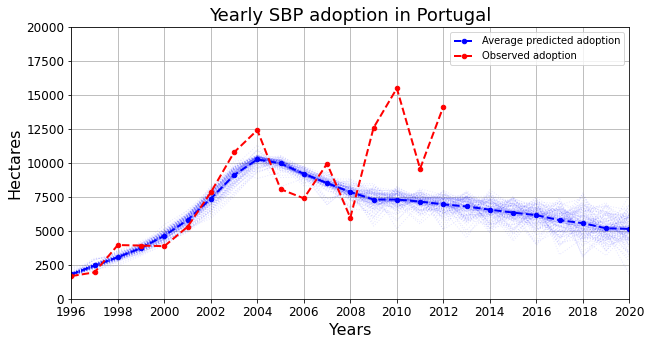

In [22]:
title = "Yearly SBP adoption in Portugal"
plot_adoption_trend_multiple_runs(yearly_adoption_portugal_pred, yearly_adoption_portugal_real, 20000, title, confidence=0.95)

#### Plot predicted vs real cumulative adoption in Portugal

In [23]:
cumulative_adoption_portugal_real = yearly_adoption_portugal_real.cumsum()

[23.955191 43.444770 69.255916 100.444281 145.638287 209.900773 296.785105
 385.395489 425.094174 405.146694 372.296484 357.663855 345.648667
 337.426243 345.954530 353.152434 353.625018 379.568592 361.870662
 377.136707 380.201900 391.705528 417.569642 424.945949 438.404798]
Saving figure Cumulative SBP adoption in Portugal


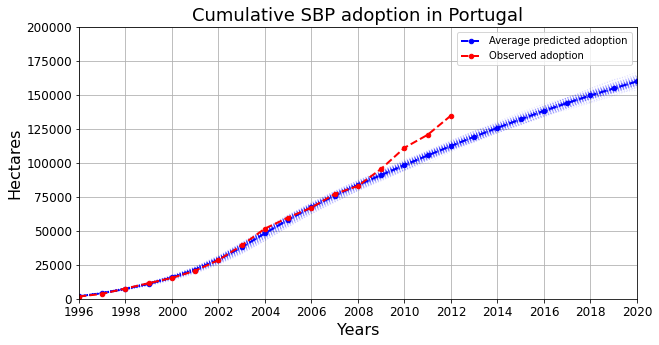

In [24]:
title = "Cumulative SBP adoption in Portugal"
plot_adoption_trend_multiple_runs(cumulative_adoption_portugal_pred, cumulative_adoption_portugal_real, 200000, title)

# Model validation based on average values

In [63]:
munic_yearly_adoption_av = munic_yearly_adoption.mean(axis=1)
munic_yearly_adoption_av.name = "predicted_adoption"

In [64]:
yearly_adoption_portugal_pred_av = yearly_adoption_portugal_pred.mean(axis=1)

In [65]:
cumulative_adoption_portugal_pred_av = cumulative_adoption_portugal_pred.mean(axis=1)

## Macro-validation

### Quantitative

Saving figure Yearly predicted vs. observed adoption


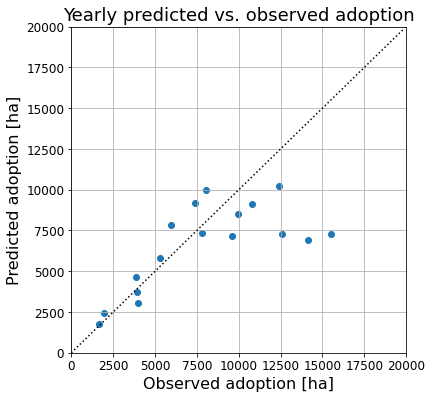

In [66]:
fig_title = "Yearly predicted vs. observed adoption"
fig_pr, ax_pr = plt.subplots()
fig_pr.set_size_inches(6, 6)
ax_pr.set_xlabel("Observed adoption [ha]", fontsize=16)
ax_pr.set_ylabel("Predicted adoption [ha]", fontsize=16)
ax_pr.set_title(fig_title, fontsize=18)
lim = 20000
ax_pr.set_xlim(0, lim)
ax_pr.set_ylim(0, lim)
ax_pr.grid(True)
# Add diagonal
p = np.arange(0, lim, 100)
ax_pr.plot(p, p, 'k:')

yearly_adoption_portugal_pred_av_untill_2012 = yearly_adoption_portugal_pred_av.loc[
    yearly_adoption_portugal_pred_av.index <= 2012
]
ax_pr.scatter(yearly_adoption_portugal_real.values, yearly_adoption_portugal_pred_av_untill_2012.values)
save_fig((fig_title))  

In [67]:
def adjusted_r2(r2, n, p):
    return 1-(1-r2)*(n-1)/(n-p-1)

In [68]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

rmse = np.sqrt(mean_squared_error(yearly_adoption_portugal_real.values, yearly_adoption_portugal_pred_av_untill_2012))
rrmse = rmse / yearly_adoption_portugal_real.values.std()
mae = mean_absolute_error(yearly_adoption_portugal_real.values, yearly_adoption_portugal_pred_av_untill_2012)
r2 = r2_score(yearly_adoption_portugal_real.values, yearly_adoption_portugal_pred_av_untill_2012)
adj_r2 = adjusted_r2(r2, len(munic_yearly_adoption_av), 21)
print("Cumulative adoption score:")
rmse_str = "RMSE: " + str(rmse)
print(rmse_str)
rrmse_str = "Relative RMSE: " + str(rrmse)
print(rrmse_str)
mae_str = "MAE: " + str(mae)
print(mae_str)
adj_r2_str = "Adjusted R2: " + str(adj_r2)
print(adj_r2_str)

with open("model_validation/images/Macro-validation metrics.csv", "w+", newline ='') as file:
    to_print = [[rmse_str], [rrmse_str], [mae_str], [adj_r2_str],]
    wr = csv.writer(file)
    wr.writerows(to_print)

Cumulative adoption score:
RMSE: 3203.874081174984
Relative RMSE: 0.7802315190752418
MAE: 2198.3419875195455
Adjusted R2: 0.38925768479425604


## Micro-validation

Create dataframe with both real and predicted adoption between the starting year of the simulation and 2012, or the ending years of the simulation if it is before 2012.

(Note that for validation purposes the years will always been between 1996 and 2012, unless we want the error only on PCF project years)

### Quantitative

In [69]:
munic_adoption_real_pred = pd.concat([munic_yearly_adoption_real['adoption_in_year'], munic_yearly_adoption_av],
                                      axis=1, join='inner')
final_year_val = min(2012, stop_year)
to_drop = munic_adoption_real_pred.loc[(munic_adoption_real_pred.index.get_level_values(1) < start_year)
                                       | (munic_adoption_real_pred.index.get_level_values(1) > final_year_val)].index
munic_adoption_real_pred.drop(to_drop, inplace=True)

In [70]:
from IPython.display import display

def get_yearly_and_cumul_rmse(adoption_rp):
    years = adoption_rp.index.get_level_values(1).unique()
    rmse_pd = pd.DataFrame(index=['RMSE on year', 'Relative RMSE on year', 'RMSE till year', 'Relative RMSE till year'],
                           columns=years)
    for year in years:
        real = adoption_rp.loc[(slice(None), year),'adoption_in_year'].values
        pred = adoption_rp.loc[(slice(None), year),'predicted_adoption'].values
        y_mse = mean_squared_error(real, pred)
        rmse_pd.loc['RMSE on year', year] = np.sqrt(y_mse)
        rmse_pd.loc['Relative RMSE on year', year] = np.sqrt(y_mse) / real.std()
        
        real_c = adoption_rp.loc[(slice(None), np.arange(start_year, year+1)),'adoption_in_year'].values
        pred_c = adoption_rp.loc[(slice(None), np.arange(start_year, year+1)),'predicted_adoption'].values
        y_mse_c = mean_squared_error(real_c, pred_c)
        rmse_pd.loc['RMSE till year', year] = np.sqrt(y_mse_c)
        rmse_pd.loc['Relative RMSE till year', year] = np.sqrt(y_mse_c) / real_c.std()
    
    display(rmse_pd)
    rmse_pd.T[['RMSE on year', 'RMSE till year']].plot()
    rmse_pd.T[['Relative RMSE on year', 'Relative RMSE till year']].plot()

In [71]:
def micro_validation(pred_adoption_runs, adoption_rp):
    real = adoption_rp['adoption_in_year'].values
    
    rmses = []
    rrmses = []
    maes = []
    adj_r2s = []
    
    for (_, pred) in pred_adoption_runs.iteritems(): 
        mse = mean_squared_error(real, pred)
        rmse = np.sqrt(mse)
        rrmse = rmse / real.std()
        rmses.append(rmse)
        rrmses.append(rrmse)
        
        mae = mean_absolute_error(real, pred)
        maes.append(mae)

        r2 = r2_score(real, pred)
        adj_r2 = adjusted_r2(r2, len(real), 21) # Taken number of features with sbp payments 
        adj_r2s.append(adj_r2)
        
    pred = adoption_rp['predicted_adoption'].values
    mse = mean_squared_error(real, pred)
    rmse = np.sqrt(mse)
    rrmse = rmse / real.std()
    rmse_str = "Average total RMSE: " + str(rmse)
    rmse_str_2 = "Total RMSE standard deviation: " + str(np.std(rmses))
    #print(str(np.mean(rmses)))
    print(rmse_str)
    print(rmse_str_2)
    rrmse_str = "Average total relative RMSE: " + str(rrmse)
    rrmse_str_2 = "Total relative RMSE standard deviation: " + str(np.std(rrmses))
    #print(np.mean(rrmses))
    print(rrmse_str)
    print(rrmse_str_2)
    mae = mean_absolute_error(real, pred)
    mae_str = "Average total MAE: " + str(mae)
    mae_str_2 = "Total MAE standard deviation: " + str(np.std(maes))
    #print(str(np.mean(maes)))
    print(mae_str)
    print(mae_str_2)
    r2 = r2_score(real, pred)
    adj_r2 = adjusted_r2(r2, len(real), 21) # Taken number of features for sbp payments
    #print(str(np.mean(adj_r2s)))
    adj_r2_str = "Average total adjusted R2 score: " + str(adj_r2)
    adj_r2_str_2 = "Total adjusted R2 score standard deviation: " + str(np.std(adj_r2))
    print(adj_r2_str)
    print(adj_r2_str_2)
    
    with open("model_validation/images/Micro-validation metrics and non adopters.csv", "w+", newline ='') as file:
        to_print = [[rmse_str], [rmse_str_2], [rrmse_str], [rrmse_str_2],
                    [mae_str], [mae_str_2], [adj_r2_str], [adj_r2_str_2]]
        wr = csv.writer(file)
        wr.writerows(to_print)
        
    get_yearly_and_cumul_rmse(adoption_rp)

Average total RMSE: 0.008619106806457983
Total RMSE standard deviation: 8.818618493068127e-05
Average total relative RMSE: 0.8637386748385886
Total relative RMSE standard deviation: 0.008837321571885628
Average total MAE: 0.002394392909662862
Total MAE standard deviation: 6.761858712120842e-05
Average total adjusted R2 score: 0.2503793923740525
Total adjusted R2 score standard deviation: 0.0


Year,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012
RMSE on year,0.004608,0.004030,0.002307,0.004308,0.004789,0.003704,0.005610,0.004389,0.005460,0.007461,0.003986,0.006966,0.003419,0.009907,0.019729,0.011821,0.018041
Relative RMSE on year,0.959035,0.929559,0.629170,0.861664,0.907006,0.740834,0.749474,0.609215,0.629123,0.732841,0.793251,0.593405,0.511185,0.882977,0.980105,0.966402,0.976073
RMSE till year,0.004608,0.004329,0.003777,0.003917,0.004106,0.004042,0.004301,0.004312,0.004454,0.004840,0.004768,0.004989,0.004886,0.005402,0.007292,0.007654,0.008619
Relative RMSE till year,0.959035,0.945899,0.877886,0.872492,0.880396,0.853937,0.820071,0.765347,0.729121,0.727831,0.731330,0.694992,0.683416,0.718873,0.815451,0.833538,0.863739


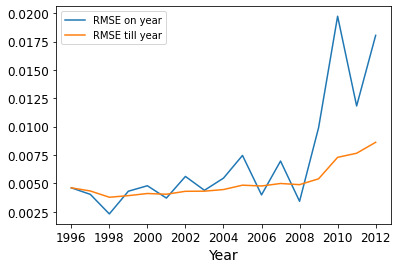

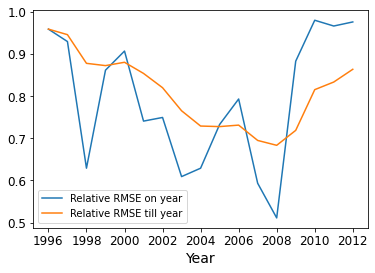

In [72]:
munic_yearly_adoption_untill_2020 = munic_yearly_adoption.loc[munic_yearly_adoption.index.get_level_values('Year') <= 2012]
micro_validation(munic_yearly_adoption_untill_2020, munic_adoption_real_pred)

### Qualitative

In [73]:
munic_adoption_real_pred_dist = munic_adoption_real_pred.copy()
munic_adoption_real_pred_dist.rename(columns={"adoption_in_year": "Observed adoption",
                                              "predicted_adoption": "Predicted adoption"}, inplace=True)

#### Number of predicted adopters over time

In [74]:
mask_real = munic_adoption_real_pred_dist['Observed adoption'] > 0
real_yearly_adopters = (munic_adoption_real_pred_dist['Observed adoption'] > 0).astype(int).groupby('Year').sum()

# For prediction cannot use the averaged data --> need to do the average of the adopters in each run
pred_yearly_adopters = (munic_yearly_adoption > 0).astype(int).groupby('Year').sum()
pred_yearly_adopters_av = pred_yearly_adopters.mean(axis=1)

Saving figure Municipalities adopting over time


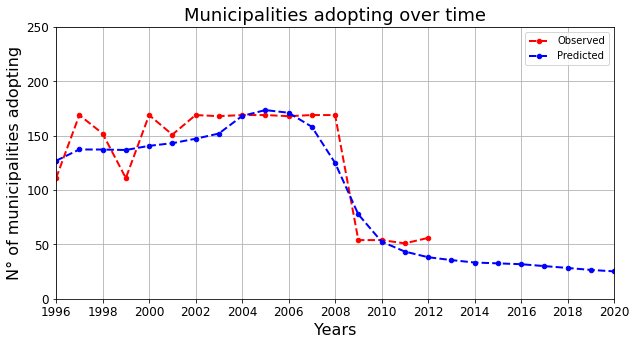

In [75]:
# Base figure
fig_title = 'Municipalities adopting over time'
fig_ad, ax_ad = plt.subplots()
fig_ad.set_size_inches(10, 5)
ax_ad.set_xlabel("Years", fontsize=16)
ax_ad.set_ylabel("N° of municipalities adopting", fontsize=16)
ax_ad.set_title(fig_title, fontsize=18)
ax_ad.set_xlim(pred_yearly_adopters.index[0], pred_yearly_adopters.index[-1])
xticks = [year for year in pred_yearly_adopters.index if year%2 == 0]
ax_ad.set_xticks(xticks)
ax_ad.set_ylim(0, 250)
ax_ad.grid(True)

# Plot adoptions
ax_ad.plot(real_yearly_adopters.index, real_yearly_adopters.values, 'r--', linewidth=2, marker='.', markersize=9,
           label='Observed')
ax_ad.plot(pred_yearly_adopters_av.index, pred_yearly_adopters_av.values, 'b--', linewidth=2, marker='.', markersize=9,
           label='Predicted')
ax_ad.legend(loc='best')

save_fig((fig_title))

#### Average adoption of only adopters over time

In [76]:
pred_av_yearly_adoption = (yearly_adoption_portugal_pred_av / pred_yearly_adopters_av)
real_av_yearly_adoption = (yearly_adoption_portugal_real['Yearly adoption'] / real_yearly_adopters)

Saving figure Average adoption (of only adopters) over time


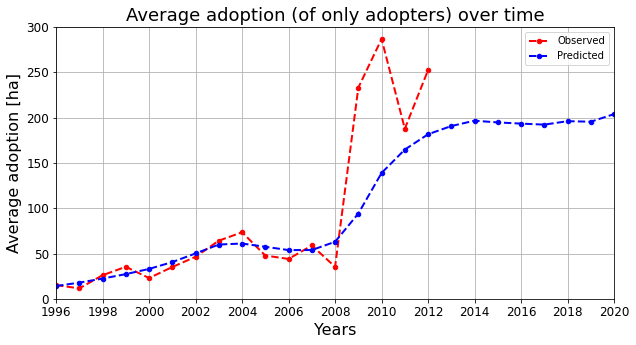

In [77]:
# Base figure
fig_title = 'Average adoption (of only adopters) over time'
fig_ad, ax_ad = plt.subplots()
fig_ad.set_size_inches(10, 5)
ax_ad.set_xlabel("Years", fontsize=16)
ax_ad.set_ylabel("Average adoption [ha]", fontsize=16)
ax_ad.set_title(fig_title, fontsize=18)
ax_ad.set_xlim(pred_av_yearly_adoption.index[0], pred_av_yearly_adoption.index[-1])
xticks = [year for year in pred_av_yearly_adoption.index if year%2 == 0]
ax_ad.set_xticks(xticks)
ax_ad.set_ylim(0, 300)
ax_ad.grid(True)

# Plot adoptions
ax_ad.plot(real_av_yearly_adoption.index, real_av_yearly_adoption.values, 'r--', linewidth=2, marker='.', markersize=9,
           label='Observed')
ax_ad.plot(pred_av_yearly_adoption.index, pred_av_yearly_adoption.values, 'b--', linewidth=2, marker='.', markersize=9,
           label='Predicted')
ax_ad.legend(loc='best')

save_fig((fig_title))

In [78]:
munic_adoption_real_pred_dist

Observed adoption  Predicted adoption
Municipality Year                                       
Abrantes     1996           0.059690            0.001868
             1997           0.032558            0.002379
             1998           0.009302            0.003695
             1999           0.030233            0.004751
             2000           0.028682            0.005765
...                              ...                 ...
Óbidos       2008           0.000734            0.001802
             2009           0.000000            0.000585
             2010           0.000000            0.000018
             2011           0.000000            0.000020
             2012           0.000000            0.000000

[4403 rows x 2 columns]

#### Ditribution of adoption in each year in each municipality

In [79]:
num_0_real = (munic_adoption_real_pred_dist["Observed adoption"] == 0).astype(int).sum()
num_0_real_str = "Total OBSERVED number of times any municipality does NOT adopt 1996-2012: " + str(num_0_real)
print(num_0_real_str)

pred_yearly_non_adopters = (munic_yearly_adoption == 0).astype(int).groupby('Year').sum()
pred_yearly_non_adopters_av = pred_yearly_adopters.mean(axis=1)
num_0_pred = round(pred_yearly_non_adopters_av.sum(), 0).astype(int)
num_0_pred_str = "Average total PREDICTED number of times any municipality does NOT adopt 1996-2012: " + str(num_0_pred)
print(num_0_pred_str)

with open("model_validation/images/Micro-validation metrics and non adopters.csv", "a", newline ='') as file:
    to_print = [" ", [num_0_real_str], [num_0_pred_str]]
    wr = csv.writer(file)
    wr.writerows(to_print)

Total OBSERVED number of times any municipality does NOT adopt 1996-2012: 2144
Average total PREDICTED number of times any municipality does NOT adopt 1996-2012: 2373


Saving figure Distribution of municipalities' adoption


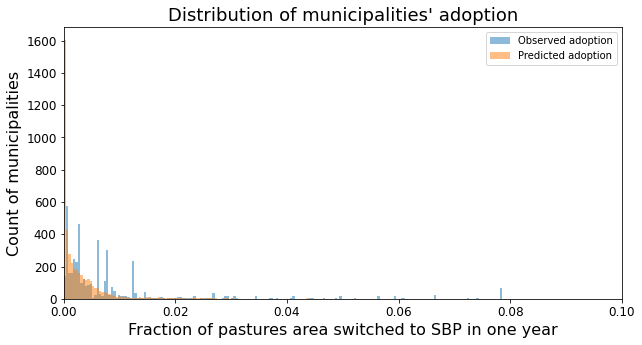

In [80]:
fig_title = "Distribution of municipalities' adoption"
munic_adoption_real_pred_dist.replace(0, None, inplace=True) # To avoid plotting 0s
ax = munic_adoption_real_pred_dist.plot.hist(figsize=(10, 5), bins=500, alpha=0.5) 
ax.set_xlabel("Fraction of pastures area switched to SBP in one year", fontsize=16)
ax.set_ylabel("Count of municipalities", fontsize=16)
ax.set_xlim(0, 0.1)
ax.set_title("Distribution of municipalities' adoption", fontsize=18)
save_fig((fig_title))

In [81]:
model.schedule.agents[0].yearly_adoption

{1995: 0.0,
 1996: 0.00227857247044444,
 1997: 0.0024038402205524174,
 1998: 0.002522519596676121,
 1999: 0.0027530209811301876,
 2000: 0.0032287532517052114,
 2001: 0.003998865752263891,
 2002: 0.005234683717637114,
 2003: 0.006882758766021614,
 2004: 0.00828795864629366,
 2005: 0.008297924607445741,
 2006: 0.007676527447888947,
 2007: 0.008037358364843962,
 2008: 0.00942773862214156,
 2009: 0.012210762781994806,
 2010: 0.015351060766575483,
 2011: 0.018575796492349923,
 2012: 0.020395156177404422,
 2013: 0.02173362727185803,
 2014: 0.022204097950183244,
 2015: 0.022750167712263215,
 2016: 0.022194173007455457,
 2017: 0,
 2018: 0.016993693941871856,
 2019: 0.020149343178982218,
 2020: 0.02009656631173018}

In [82]:
munic_adoption_real_pred_dist['Predicted adoption'].describe()

count   4403.000000
mean       0.002867
std        0.004573
min        0.000000
25%        0.000166
50%        0.001069
75%        0.003734
max        0.043910
Name: Predicted adoption, dtype: float64

#### Map based on adoption level for each municipality at the end of the simulation

In [83]:
import geopandas as gpd

In [84]:
def collect_agent_level_for_map(abm_model, year):
    """
    Function to collect cumulative adoption in a certain year (in ha and in fraction over pastures area)
    and the shape of the municialities in order to plot the map.
    
    Returns
    -------
    munic_cumul_adoption_and_shape : pd DataFrame
        DataFrame reporting for each muninicipality the total cumulative adoption in ha and its shape
    """
    municipality_agents = abm_model.schedule.agents
    #municipalities = [munic.Municipality for munic in municipality_agents]
    
    #munic_cumul_adoption_and_shape = pd.DataFrame(index=municipalities)
    munic_cumul_adoption_and_shape = gpd.GeoDataFrame()
    munic_cumul_adoption_and_shape['Total cumulative adoption [ha]'] = None
    munic_cumul_adoption_and_shape['Total cumulative adoption [fraction]'] = None
    munic_cumul_adoption_and_shape['geometry'] = None
    
    for munic in municipality_agents:
        yearly_adoption_until_year_ha = [v for k, v in munic.yearly_adoption_ha.items()
                                        if k <= year]
        munic_tot_cumul_adoption_year_ha = sum(yearly_adoption_until_year_ha)
        
        yearly_adoption_until_year = [v for k, v in munic.yearly_adoption.items()
                                     if k <= year]
        munic_tot_cumul_adoption_year = sum(yearly_adoption_until_year)
        
        munic_cumul_adoption_and_shape.loc[munic.Municipality] = (
            munic_tot_cumul_adoption_year_ha, 
            munic_tot_cumul_adoption_year,
            munic.shape
        )
    
    return munic_cumul_adoption_and_shape

In [85]:
year_for_map = 2012

In [86]:
pred_for_map = collect_agent_level_for_map(model, year_for_map)

In [89]:
pred_for_map.to_csv("model_validation/images/output/adoption_pred_for_map.csv")

In [90]:
# Collect observed adoption in year
geometry = pred_for_map['geometry']
munic_map_adoption_real = munic_yearly_adoption_real.loc[munic_yearly_adoption_real.index.get_level_values(1) == year_for_map]
munic_map_adoption_real.index = munic_map_adoption_real.index.droplevel(1)

real_for_map = pd.concat([munic_map_adoption_real['tot_cumul_adoption_until_year_ha'], geometry], axis=1)
real_for_map = gpd.GeoDataFrame(real_for_map)

Plot of area adopted in hectares

In [91]:
import contextily as ctx
import matplotlib

def plot_maps_no_0s(geodata, column_data, leg_label, fig_title):
    """
    To plot maps side by side.
    Inputs to be given as lists of two elements, the first referring to the predicted adoption and the second to the
    observed one.
    
    For additional options for plotting with geopandas see https://geopandas.org/mapping.html
    For different backgrounds see https://contextily.readthedocs.io/en/latest/providers_deepdive.html
    """
    fig, axis = plt.subplots(ncols=len(geodata), figsize=(15, 8))
    #fig.suptitle(fig_title, fontsize=18)

    for i in range(len(geodata)):
        geodata_no_0 = geodata[i].loc[geodata[i][column_data[i]] != 0]
        geodata_no_0.crs = "EPSG:3857"
        transparency = 0.8
        if i == 0: # Legend scale based on predicted values
            sc_min = 10
            sc_max = max(geodata_no_0['Total cumulative adoption [ha]']) 
        geodata_no_0.plot(ax=axis[i], column=column_data[i],
                          cmap="OrRd", #cmap='coolwarm',
                          alpha=transparency, edgecolor='k',
                          legend=True, norm=matplotlib.colors.LogNorm(vmin=sc_min, vmax=sc_max),
                          legend_kwds={'label': leg_label[i]})
        ctx.add_basemap(axis[i], source=ctx.providers.Stamen.Terrain)
        axis[i].axis('off')
        
        #geodata_0 = geodata[i].loc[geodata[i][column_data[i]] == 0]
        #geodata_0.crs = "EPSG:3857"
        #geodata_0.boundary.plot(ax=axis[i])

    save_fig((fig_title))

Saving figure Predicted vs observed adoption spatial distribution [ha]


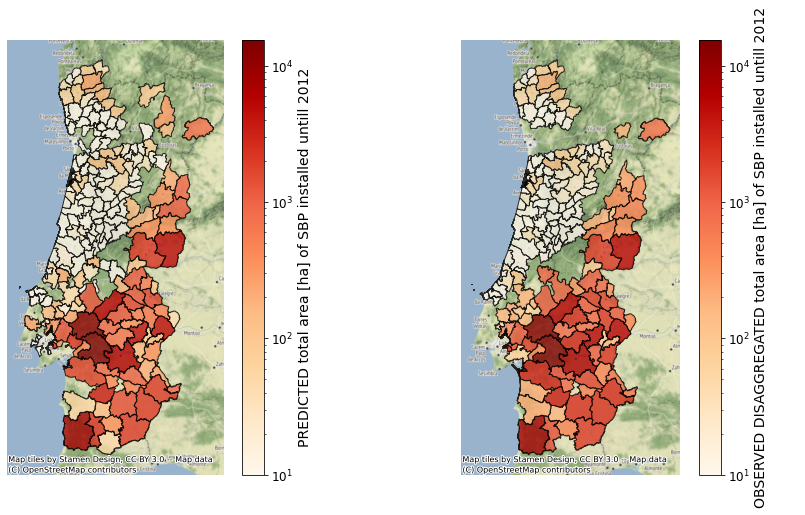

In [92]:
pred_leg_label = "PREDICTED total area [ha] of SBP installed untill " + str(year_for_map)
real_leg_label = "OBSERVED DISAGGREGATED total area [ha] of SBP installed untill " + str(year_for_map)
plot_maps_no_0s([pred_for_map, real_for_map], ['Total cumulative adoption [ha]', 'tot_cumul_adoption_until_year_ha'],
                [pred_leg_label, real_leg_label], "Predicted vs observed adoption spatial distribution [ha]")

Plot of fraction of pastures area adopted (**Not for validation since not compared with real one move to experiments only**)

In [93]:
import contextily as ctx

def plot_map_no_0s(geodata, column_data, leg_label):
    """
    To plot only one map.
    
    For other options for plotting with geopandas see https://geopandas.org/mapping.html
    """
    geodata_no_0 = geodata.loc[geodata[column_data] != 0]
    geodata_no_0.crs = "EPSG:3857"
    transparency = 0.6
    ax = geodata_no_0.plot(figsize=(10, 8), column=column_data,
                            cmap="OrRd", alpha=transparency, edgecolor='k',
                            legend=True,
                            legend_kwds={'label': leg_label})
    ctx.add_basemap(ax, source=ctx.providers.Stamen.Terrain)    

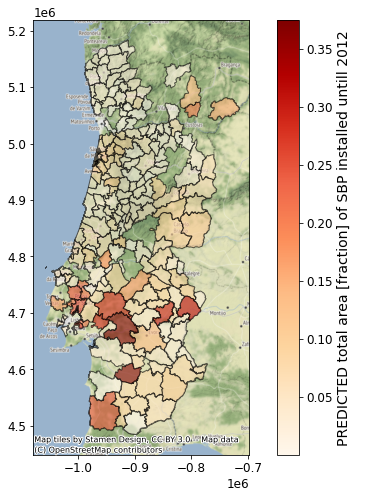

In [94]:
frac_leg_label = "PREDICTED total area [fraction] of SBP installed untill " + str(year_for_map)
plot_map_no_0s(pred_for_map, 'Total cumulative adoption [fraction]', frac_leg_label)